# Models Fusion

## Set up

###  Install required packages.

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
print(torch.__version__)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install optuna

2.2.2
Looking in links: https://data.pyg.org/whl/torch-2.2.2.html
  Using cached torch_scatter-2.1.2-cp312-cp312-macosx_10_9_x86_64.whl
Looking in links: https://data.pyg.org/whl/torch-2.2.2.html
  Using cached torch_sparse-0.6.18.tar.gz (209 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [66 lines of output]
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      running egg_info
      creating /private/var/folders/c8/rmlp9g456b5_c_vt71ncc0nm0000gn/T/pip-pip-egg-info-v9idujcz/torch_sparse.egg-info
      writing /priva

### Unzip Data and Utils

In [2]:
!unzip "utils.zip" -d '.'

unzip:  cannot find or open utils.zip, utils.zip.zip or utils.zip.ZIP.


In [3]:
!unzip "data.zip" -d '.'

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


### Import and Var

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import os
import pandas as pd
from pathlib import Path
import json
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
from torch_geometric.utils import from_networkx

from utils.comparing import report_for_multiple_model_as_same_set, evaluate_multilabel_classification
from utils.threshold import tune_thresholds

PATH = './data/labeled'

## Load Data

In [6]:
def load_feature(file):
    df = pd.read_csv(os.path.join(PATH, file), index_col=0)
    df.index = df.index.str.lower()
    return df

In [7]:
def plot_confusion_matrix(y_test, y_pred):
    print(classification_report(y_test, y_pred, target_names=label_cols))
    mcm = multilabel_confusion_matrix(y_test, y_pred)

    n_labels = len(label_cols)
    fig, axes = plt.subplots(1, n_labels, figsize=(5 * n_labels, 4))  # 5 units wide per plot

    for i, matrix in enumerate(mcm):
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['No ' + label_cols[i], label_cols[i]])
        disp.plot(cmap=plt.cm.Blues, ax=axes[i], colorbar=False)
        axes[i].set_title(f'{label_cols[i]}')

    plt.show()

In [8]:
y = load_feature('groundtruth.csv')
label_cols = [col for col in y.columns]
y.index = y.index.str.lower()
addresses = y.index.tolist()

FileNotFoundError: [Errno 2] No such file or directory: './data/labeled/groundtruth.csv'

### Split Train

In [ ]:
train_idx, test_idx = train_test_split(addresses, test_size=0.3, random_state=42)
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

## Individual Model

In [ ]:
# for txn static, bytecode
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# for source code
from sklearn.linear_model import LogisticRegression

# tuning
import optuna
from sklearn.metrics import f1_score

### Txn Static Feature Model

#### Base

In [ ]:
df = load_feature('transaction_feature.csv')

# Filter train_idx and test_idx to include only addresses present in df.index
txn_train_idx = [idx for idx in train_idx if idx in df.index]
txn_test_idx = [idx for idx in test_idx if idx in df.index]

txn_X_train = df.loc[txn_train_idx]
txn_X_test = df.loc[txn_test_idx]
txn_y_train = y_train.loc[txn_train_idx]
txn_y_test = y_test.loc[txn_test_idx]

In [ ]:
txn_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42))
txn_model.fit(txn_X_train, txn_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       1.00      0.12      0.22         8
        Leak       0.30      0.75      0.43         4
       Limit       0.73      0.67      0.70        12

   micro avg       0.55      0.50      0.52        24
   macro avg       0.68      0.51      0.45        24
weighted avg       0.75      0.50      0.49        24
 samples avg       0.33      0.34      0.32        24



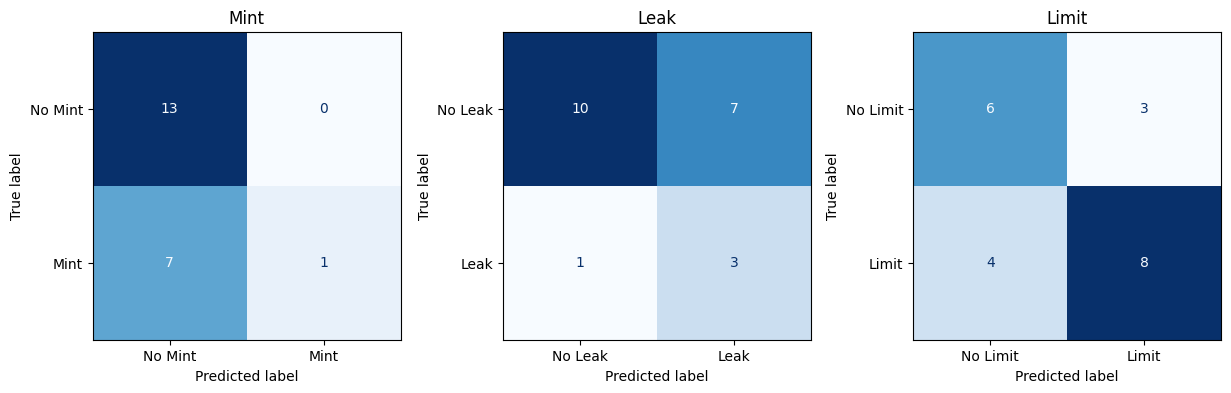

In [ ]:
y_pred = txn_model.predict(txn_X_test)
plot_confusion_matrix(txn_y_test, y_pred)

#### Tuning

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }

    clf = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **params))
    clf.fit(txn_X_train, txn_y_train)
    y_pred = clf.predict(txn_X_test)
    return f1_score(txn_y_test, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-30 07:23:06,682] A new study created in memory with name: no-name-418e62d1-1fce-4200-9662-ac2891d6bfd5
[I 2025-07-30 07:23:07,331] Trial 0 finished with value: 0.4317460317460317 and parameters: {'n_estimators': 140, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.4317460317460317.
[I 2025-07-30 07:23:08,941] Trial 1 finished with value: 0.441407867494824 and parameters: {'n_estimators': 233, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.441407867494824.
[I 2025-07-30 07:23:09,722] Trial 2 finished with value: 0.441407867494824 and parameters: {'n_estimators': 177, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.441407867494824.
[I 2025-07-30 07:23:11,486] Trial 3 finished with value: 0.441407867494824 and parameters: {'n_estimators': 288, 'max_depth': 23, 'min_sam

Best Params: {'n_estimators': 180, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}
Best Score: 0.4488152749022314


##### Evaluation

In [ ]:
tuned_txn_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **study.best_params))
tuned_txn_model.fit(txn_X_train, txn_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=25,
                                                       max_features='log2',
                                                       min_samples_split=3,
                                                       n_estimators=180,
                                                       random_state=42))

              precision    recall  f1-score   support

        Mint       1.00      0.12      0.22         8
        Leak       0.30      0.75      0.43         4
       Limit       0.73      0.67      0.70        12

   micro avg       0.55      0.50      0.52        24
   macro avg       0.68      0.51      0.45        24
weighted avg       0.75      0.50      0.49        24
 samples avg       0.33      0.34      0.32        24



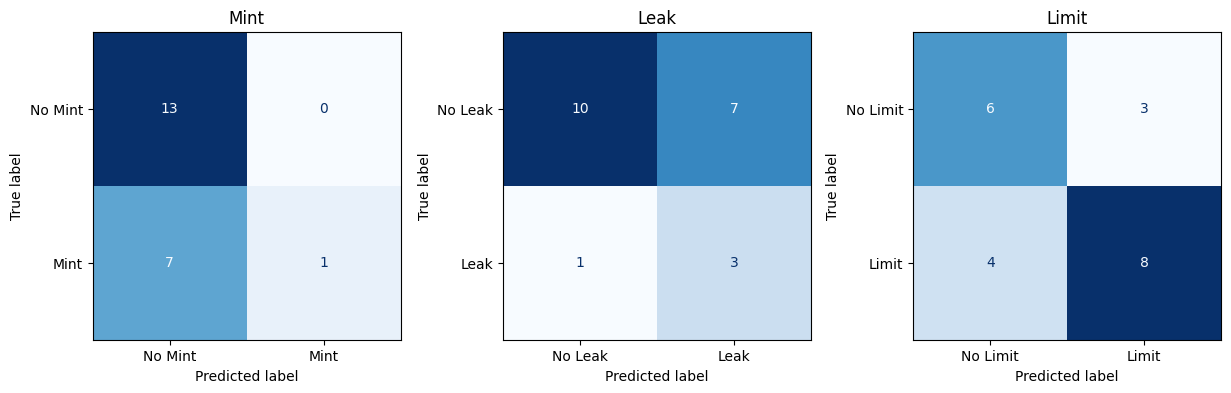

In [ ]:
y_pred = tuned_txn_model.predict(txn_X_test)
plot_confusion_matrix(txn_y_test, y_pred)

### Bytecode Static Feature Model

#### Base

In [ ]:
df = load_feature('bytecode_feature.csv')

# Filter train_idx and test_idx to include only addresses present in df.index
byte_train_idx = [idx for idx in train_idx if idx in df.index]
byte_test_idx = [idx for idx in test_idx if idx in df.index]

byte_X_train = df.loc[byte_train_idx]
byte_X_test = df.loc[byte_test_idx]
byte_y_train = y_train.loc[byte_train_idx]
byte_y_test = y_test.loc[byte_test_idx]

In [ ]:
byte_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42))
byte_model.fit(byte_X_train, byte_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       0.60      0.38      0.46         8
        Leak       1.00      0.25      0.40         4
       Limit       0.78      0.58      0.67        12

   micro avg       0.73      0.46      0.56        24
   macro avg       0.79      0.40      0.51        24
weighted avg       0.76      0.46      0.55        24
 samples avg       0.37      0.36      0.35        24



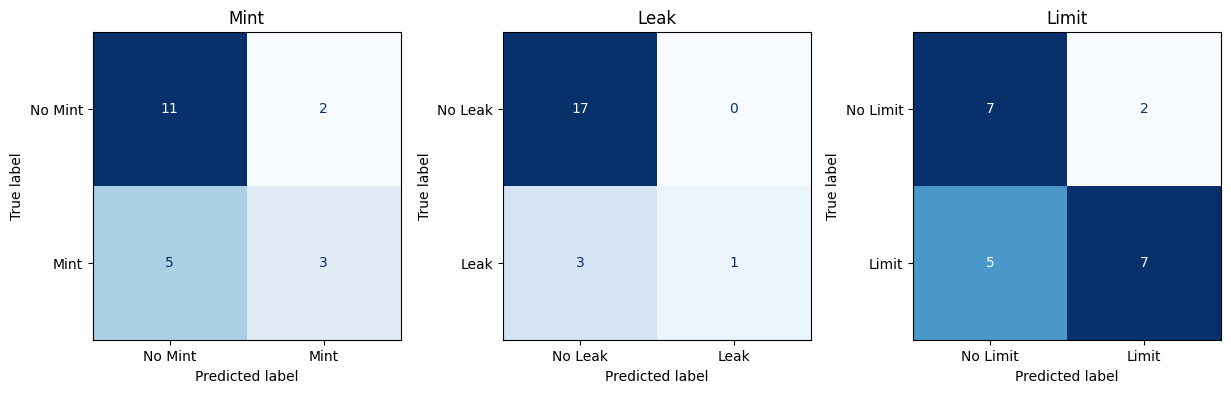

In [ ]:
y_pred = byte_model.predict(byte_X_test)
plot_confusion_matrix(byte_y_test, y_pred)

#### Tuning

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }

    clf = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **params))
    clf.fit(byte_X_train, byte_y_train)
    y_pred = clf.predict(byte_X_test)
    return f1_score(byte_y_test, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-30 07:24:55,820] A new study created in memory with name: no-name-4f2f252d-c85b-4179-bc93-3f225a8a8b2d
[I 2025-07-30 07:24:57,223] Trial 0 finished with value: 0.37606837606837606 and parameters: {'n_estimators': 298, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.37606837606837606.
[I 2025-07-30 07:24:58,388] Trial 1 finished with value: 0.5760683760683761 and parameters: {'n_estimators': 232, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5760683760683761.
[I 2025-07-30 07:24:59,517] Trial 2 finished with value: 0.6 and parameters: {'n_estimators': 243, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 2 with value: 0.6.
[I 2025-07-30 07:25:00,887] Trial 3 finished with value: 0.4871794871794872 and parameters: {'n_estimators': 295, 'max_depth': 20, 'min_samples_split': 8, 'min_s

Best Params: {'n_estimators': 243, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}
Best Score: 0.6


##### Evaluation

In [ ]:
tuned_byte_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **study.best_params))
tuned_byte_model.fit(byte_X_train, byte_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=5,
                                                       max_features='log2',
                                                       min_samples_leaf=3,
                                                       min_samples_split=10,
                                                       n_estimators=243,
                                                       random_state=42))

              precision    recall  f1-score   support

        Mint       0.57      0.50      0.53         8
        Leak       1.00      0.50      0.67         4
       Limit       0.75      0.50      0.60        12

   micro avg       0.71      0.50      0.59        24
   macro avg       0.77      0.50      0.60        24
weighted avg       0.73      0.50      0.59        24
 samples avg       0.41      0.40      0.40        24



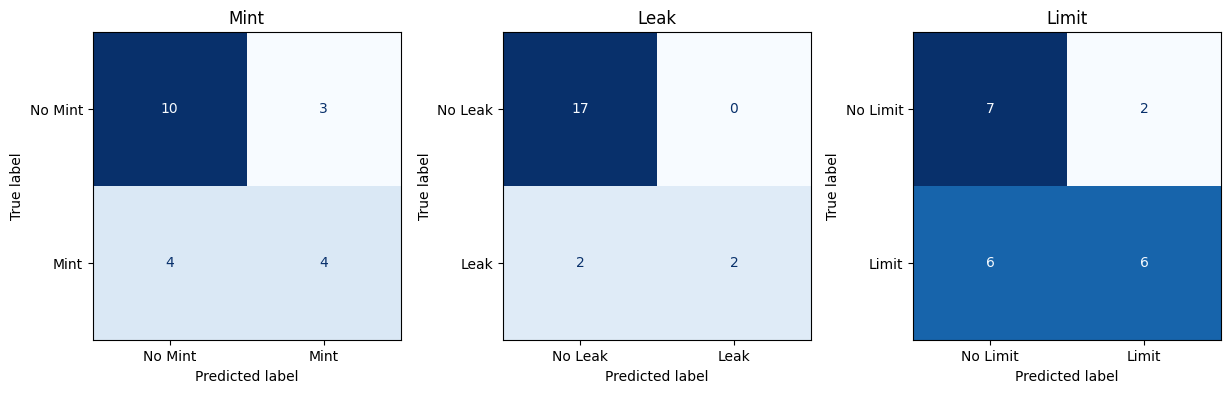

In [ ]:
y_pred = tuned_byte_model.predict(byte_X_test)
plot_confusion_matrix(byte_y_test, y_pred)

### Source Code Static Feature Model

#### Base

In [ ]:
df = load_feature('tf_idf.csv')

# Filter train_idx and test_idx to include only addresses present in df.index
source_train_idx = [idx for idx in train_idx if idx in df.index]
source_test_idx = [idx for idx in test_idx if idx in df.index]

source_X_train = df.loc[source_train_idx]
source_X_test = df.loc[source_test_idx]
source_y_train = y_train.loc[source_train_idx]
source_y_test = y_test.loc[source_test_idx]

In [ ]:
source_model = MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=42))
source_model.fit(source_X_train, source_y_train)

MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       0.50      0.86      0.63         7
        Leak       1.00      0.25      0.40         4
       Limit       0.75      0.55      0.63        11

   micro avg       0.62      0.59      0.60        22
   macro avg       0.75      0.55      0.55        22
weighted avg       0.72      0.59      0.59        22
 samples avg       0.50      0.43      0.44        22



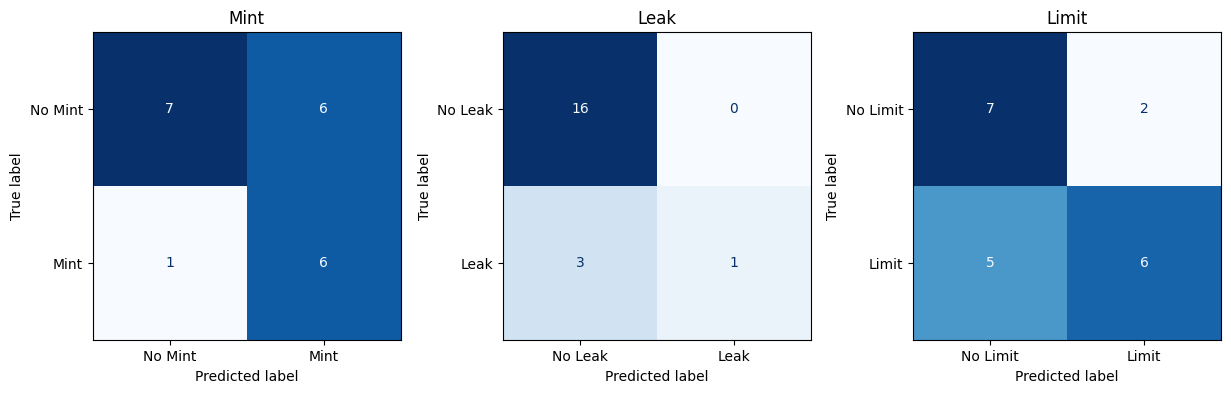

In [ ]:
y_pred = source_model.predict(source_X_test)
plot_confusion_matrix(source_y_test, y_pred)

#### Tuning

In [ ]:
def objective(trial):
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "C": trial.suggest_float("C", 1e-6, 10, log=True),  # regularization strength
        "solver": trial.suggest_categorical(
            "solver", ["liblinear", "saga"]  # both support l1 and l2
        ),
        "max_iter": trial.suggest_int("max_iter", 100, 2000),
    }

    clf = MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=42, **params))
    clf.fit(source_X_train, source_y_train)
    y_pred = clf.predict(source_X_test)
    return f1_score(source_y_test, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-30 07:27:01,575] A new study created in memory with name: no-name-14bc787f-b039-4f0f-b00c-775d575b9d82
[I 2025-07-30 07:27:01,845] Trial 0 finished with value: 0.5087719298245613 and parameters: {'penalty': 'l2', 'C': 0.008172105402526818, 'solver': 'saga', 'max_iter': 1074}. Best is trial 0 with value: 0.5087719298245613.
[I 2025-07-30 07:27:01,969] Trial 1 finished with value: 0.0 and parameters: {'penalty': 'l1', 'C': 0.000127312563186375, 'solver': 'liblinear', 'max_iter': 126}. Best is trial 0 with value: 0.5087719298245613.
[I 2025-07-30 07:27:02,063] Trial 2 finished with value: 0.546031746031746 and parameters: {'penalty': 'l1', 'C': 2.6133379254340365, 'solver': 'liblinear', 'max_iter': 1582}. Best is trial 2 with value: 0.546031746031746.
[I 2025-07-30 07:27:02,142] Trial 3 finished with value: 0.0 and parameters: {'penalty': 'l1', 'C': 3.5334870185688867e-06, 'solver': 'liblinear', 'max_iter': 827}. Best is trial 2 with value: 0.546031746031746.
[I 2025-07-30 07:2

Best Params: {'penalty': 'l2', 'C': 3.0893804961246745, 'solver': 'saga', 'max_iter': 1052}
Best Score: 0.6295739348370927


##### Evaluation

In [ ]:
tuned_source_model = MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=42, **study.best_params))
tuned_source_model.fit(source_X_train, source_y_train)

MultiOutputClassifier(estimator=LogisticRegression(C=3.0893804961246745,
                                                   class_weight='balanced',
                                                   max_iter=1052,
                                                   random_state=42,
                                                   solver='saga'))

              precision    recall  f1-score   support

        Mint       0.86      0.86      0.86         7
        Leak       1.00      0.25      0.40         4
       Limit       0.75      0.55      0.63        11

   micro avg       0.81      0.59      0.68        22
   macro avg       0.87      0.55      0.63        22
weighted avg       0.83      0.59      0.66        22
 samples avg       0.53      0.43      0.46        22



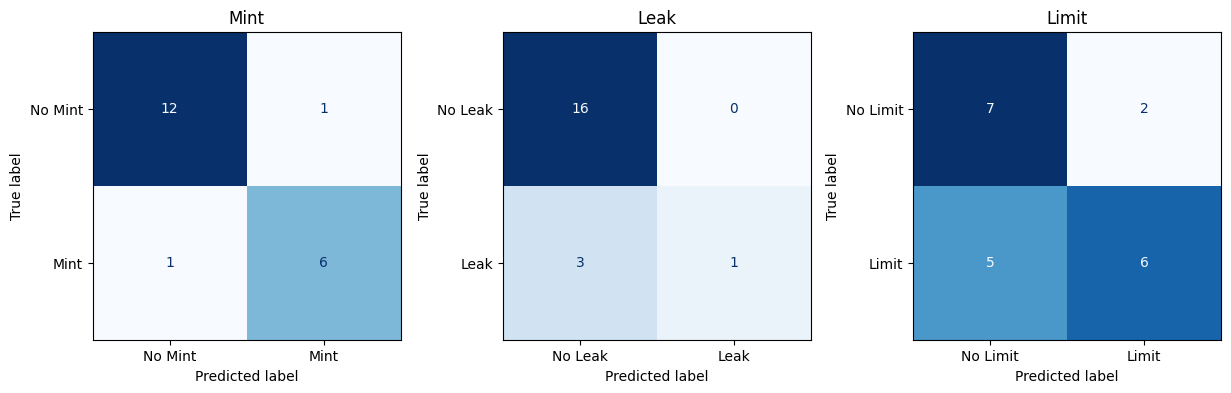

In [ ]:
y_pred = tuned_source_model.predict(source_X_test)
plot_confusion_matrix(source_y_test, y_pred)

### Transaction Time Series

#### import lib

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Masking
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

#### load data

In [ ]:
seq_len = 500
feature_dim = 12

ts_X_train, ts_X_test, ts_y_train, ts_y_test, ts_test_idx  = [], [], [], [], []

for path in tqdm(list(Path(os.path.join(PATH, 'txn')).glob('*.json'))):
    addr = path.stem
    data = json.load(open(path, 'r'))
    txns = sorted(data.get("transaction", []), key=lambda x: int(x.get("timeStamp", 0)))
    seq = [[
        int(tx.get("blockNumber", 0)),
        int(tx.get("timeStamp", 0)),
        int(tx.get("nonce", 0)),
        int(tx.get("transactionIndex", 0)),
        int(tx.get("value", 0)),
        int(tx.get("gas", 0)),
        int(tx.get("gasPrice", 0)),
        int(tx.get("isError", 0)),
        int(tx.get("txreceipt_status", 0)),
        int(tx.get("cumulativeGasUsed", 0)),
        int(tx.get("gasUsed", 0)),
        int(tx.get("confirmations", 0)),
    ] for tx in txns]

    if len(seq) < seq_len:
        seq += [[0]*feature_dim] * (seq_len - len(seq))
    else:
        seq = seq[:seq_len]

    seq = StandardScaler().fit_transform(seq)

    if addr in train_idx:
        ts_X_train.append(seq)
        ts_y_train.append(y.loc[addr].tolist())
    elif addr in test_idx:
        ts_X_test.append(seq)
        ts_y_test.append(y.loc[addr].tolist())
        ts_test_idx.append(addr)

100%|██████████| 69/69 [00:02<00:00, 32.65it/s]


In [ ]:
ts_X_train = np.array(ts_X_train)
ts_X_test = np.array(ts_X_test)
ts_y_train = np.array(ts_y_train)
ts_y_test = np.array(ts_y_test)

#### tuning

In [ ]:
epochs = 100

In [ ]:
def build_gru_model(input_shape, units, lr, output):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=input_shape),
        GRU(units),
        Dense(output, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss=BinaryCrossentropy(), metrics=['accuracy'])
    return model

def scheduler(epoch, lr):
    return lr if epoch < 10 else lr * 0.9

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
def objective(trial):
    units = trial.suggest_int("units", 32, 516)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16, 32])

    model = build_gru_model(
        input_shape=(ts_X_train.shape[1], ts_X_train.shape[2]),
        units=units, lr=lr,
        output=ts_y_train.shape[1]
    )

    model.fit(
        ts_X_train, ts_y_train,
        validation_data=(ts_X_test, ts_y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr, lr_scheduler],
        verbose=1
    )

    y_pred = model.predict(ts_X_test)
    thresholds, _ = tune_thresholds(ts_y_test, y_pred)
    y_pred_bin = (y_pred > thresholds).astype(int)

    return f1_score(ts_y_test, y_pred_bin, average='macro')

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)


[I 2025-07-30 07:32:22,030] A new study created in memory with name: no-name-2581f26e-f753-47a0-b9a6-638e2ac6497f


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3051 - loss: 0.6896 - val_accuracy: 0.1429 - val_loss: 0.6837 - learning_rate: 2.1501e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3232 - loss: 0.6699 - val_accuracy: 0.1905 - val_loss: 0.6709 - learning_rate: 2.1501e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2571 - loss: 0.6546 - val_accuracy: 0.2381 - val_loss: 0.6573 - learning_rate: 2.1501e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3137 - loss: 0.6496 - val_accuracy: 0.2381 - val_loss: 0.6463 - learning_rate: 2.1501e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4167 - loss: 0.6087 - val_accuracy: 0.2381 - val_loss: 0.6346 - learning_rate: 2.1501e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3574 - loss: 0.6108 - val_accuracy: 0.2381 - val_loss: 0.6226 - learning_rate: 2.1501e-04
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3562 - loss: 0.5790 -

[I 2025-07-30 07:34:57,415] Trial 0 finished with value: 0.6333333333333334 and parameters: {'units': 367, 'lr': 0.00021500610646334748, 'batch_size': 8}. Best is trial 0 with value: 0.6333333333333334.


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 893ms/step - accuracy: 0.2771 - loss: 0.6900 - val_accuracy: 0.4286 - val_loss: 0.6804 - learning_rate: 1.7409e-04
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 832ms/step - accuracy: 0.4794 - loss: 0.6669 - val_accuracy: 0.2381 - val_loss: 0.6670 - learning_rate: 1.7409e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 751ms/step - accuracy: 0.4118 - loss: 0.6561 - val_accuracy: 0.2381 - val_loss: 0.6542 - learning_rate: 1.7409e-04
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 728ms/step - accuracy: 0.2938 - loss: 0.6202 - val_accuracy: 0.2381 - val_loss: 0.6410 - learning_rate: 1.7409e-04
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 860ms/step - accuracy: 0.2862 - loss: 0.6283 - val_accuracy: 0.2381 - val_loss: 0.6271 - learning_rate: 1.7409e-04
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 854ms/step - accuracy: 0.3510 - loss: 0.5870 - val_accuracy: 0.1905 - val_loss: 0.6126 - learning_rate: 1.7409e-04
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 843ms/step

[I 2025-07-30 07:38:22,423] Trial 1 finished with value: 0.682051282051282 and parameters: {'units': 301, 'lr': 0.00017409101678190662, 'batch_size': 4}. Best is trial 1 with value: 0.682051282051282.


Label 2: Best threshold = 0.4, Best f1 = 0.8461538461538461
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.2465 - loss: 0.7025 - val_accuracy: 0.5238 - val_loss: 0.6930 - learning_rate: 2.7528e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5312 - loss: 0.6889 - val_accuracy: 0.5238 - val_loss: 0.6850 - learning_rate: 2.7528e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6250 - loss: 0.6771 - val_accuracy: 0.5714 - val_loss: 0.6777 - learning_rate: 2.7528e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6389 - loss: 0.6657 - val_accuracy: 0.6190 - val_loss: 0.6706 - learning_rate: 2.7528e-04
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.6319 - loss: 0.6585 - val_accuracy: 0.4286 - val_loss: 0.6636 - learning_rate: 2.7528e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4097 - loss: 0.6440 - val_accuracy: 0.2381 - val_loss: 0.6566 - learning_rate: 2.7528e-04
Epoch 7/100
2/2 ━━━━━━━━━━━

[I 2025-07-30 07:40:49,382] Trial 2 finished with value: 0.6135531135531136 and parameters: {'units': 383, 'lr': 0.00027527888863143434, 'batch_size': 32}. Best is trial 1 with value: 0.682051282051282.


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5699 - loss: 0.6790 - val_accuracy: 0.3810 - val_loss: 0.6772 - learning_rate: 2.0891e-04
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4086 - loss: 0.6511 - val_accuracy: 0.3333 - val_loss: 0.6563 - learning_rate: 2.0891e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3899 - loss: 0.6081 - val_accuracy: 0.3810 - val_loss: 0.6367 - learning_rate: 2.0891e-04
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5275 - loss: 0.5901 - val_accuracy: 0.4762 - val_loss: 0.6228 - learning_rate: 2.0891e-04
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6013 - loss: 0.5525 - val_accuracy: 0.4286 - val_loss: 0.6192 - learning_rate: 2.0891e-04
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4870 - loss: 0.5467 - val_accuracy: 0.2381 - val_loss: 0.5942 - learning_rate: 2.0891e-04
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3596 

[I 2025-07-30 07:45:38,289] Trial 3 finished with value: 0.6518037518037518 and parameters: {'units': 415, 'lr': 0.0002089143358711865, 'batch_size': 4}. Best is trial 1 with value: 0.682051282051282.


Label 2: Best threshold = 0.39, Best f1 = 0.7857142857142857
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.3542 - loss: 0.6680 - val_accuracy: 0.5238 - val_loss: 0.6628 - learning_rate: 0.0049
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.4306 - loss: 0.6074 - val_accuracy: 0.2381 - val_loss: 0.6593 - learning_rate: 0.0049
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.3715 - loss: 0.5508 - val_accuracy: 0.2381 - val_loss: 0.5952 - learning_rate: 0.0049
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3403 - loss: 0.5225 - val_accuracy: 0.1905 - val_loss: 0.5822 - learning_rate: 0.0049
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.2917 - loss: 0.5282 - val_accuracy: 0.2381 - val_loss: 0.5703 - learning_rate: 0.0049
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.3264 - loss: 0.5050 - val_accuracy: 0.2857 - val_loss: 0.5635 - learning_rate: 0.0049
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
Label 0: Best threshold = 0.29, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.12, Best f1 = 0.5333333333333333


[I 2025-07-30 07:47:52,372] Trial 4 finished with value: 0.7059163059163059 and parameters: {'units': 509, 'lr': 0.004901987607772219, 'batch_size': 32}. Best is trial 4 with value: 0.7059163059163059.


Label 2: Best threshold = 0.35000000000000003, Best f1 = 0.8571428571428571
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3264 - loss: 0.6746 - val_accuracy: 0.2381 - val_loss: 0.6542 - learning_rate: 0.0024
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 937ms/step - accuracy: 0.3264 - loss: 0.6223 - val_accuracy: 0.2381 - val_loss: 0.6217 - learning_rate: 0.0024
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 866ms/step - accuracy: 0.3264 - loss: 0.5710 - val_accuracy: 0.2381 - val_loss: 0.6095 - learning_rate: 0.0024
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 966ms/step - accuracy: 0.3715 - loss: 0.5305 - val_accuracy: 0.2381 - val_loss: 0.6075 - learning_rate: 0.0024
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3889 - loss: 0.5248 - val_accuracy: 0.2381 - val_loss: 0.5807 - learning_rate: 0.0024
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 968ms/step - accuracy: 0.3611 - loss: 0.5207 - val_accuracy: 0.2381 - val_loss: 0.5754 - learning_rate: 0.0024
Epoch 7/100
2/2 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
Label 0: Best threshold = 0.4, Best f1 = 0.6956521739130435
Label 1: Best threshold = 0.13, Best f1 = 0.5


[I 2025-07-30 07:48:25,459] Trial 5 finished with value: 0.6485507246376812 and parameters: {'units': 202, 'lr': 0.0024201238217434694, 'batch_size': 32}. Best is trial 4 with value: 0.7059163059163059.


Label 2: Best threshold = 0.13, Best f1 = 0.75
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3107 - loss: 0.6770 - val_accuracy: 0.4762 - val_loss: 0.6533 - learning_rate: 0.0029
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2628 - loss: 0.5625 - val_accuracy: 0.1905 - val_loss: 0.5992 - learning_rate: 0.0029
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 952ms/step - accuracy: 0.3500 - loss: 0.5786 - val_accuracy: 0.2381 - val_loss: 0.5783 - learning_rate: 0.0029
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2845 - loss: 0.5444 - val_accuracy: 0.3333 - val_loss: 0.5580 - learning_rate: 0.0029
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3128 - loss: 0.5066 - val_accuracy: 0.2857 - val_loss: 0.5269 - learning_rate: 0.0029
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4048 - loss: 0.4681 - val_accuracy: 0.2857 - val_loss: 0.5324 - learning_rate: 0.0029
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 960ms/step - accura

[I 2025-07-30 07:50:27,920] Trial 6 finished with value: 0.6568863235529903 and parameters: {'units': 346, 'lr': 0.00289790561793207, 'batch_size': 8}. Best is trial 4 with value: 0.7059163059163059.


Label 2: Best threshold = 0.27, Best f1 = 0.8148148148148148
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4896 - loss: 0.6781 - val_accuracy: 0.4762 - val_loss: 0.6293 - learning_rate: 0.0033
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.5694 - loss: 0.5816 - val_accuracy: 0.5238 - val_loss: 1.0146 - learning_rate: 0.0033
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5208 - loss: 0.7590 - val_accuracy: 0.2381 - val_loss: 0.5843 - learning_rate: 0.0033
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.3715 - loss: 0.5486 - val_accuracy: 0.2381 - val_loss: 0.5770 - learning_rate: 0.0033
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.3229 - loss: 0.5207 - val_accuracy: 0.2381 - val_loss: 0.5795 - learning_rate: 0.0033
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3264 - loss: 0.5175 - val_accuracy: 0.2857 - val_loss: 0.5864 - learning_rate: 0.0033
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/ste

[I 2025-07-30 07:51:43,839] Trial 7 finished with value: 0.6702020202020202 and parameters: {'units': 461, 'lr': 0.003262996714523232, 'batch_size': 32}. Best is trial 4 with value: 0.7059163059163059.


Label 2: Best threshold = 0.2, Best f1 = 0.75
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 983ms/step - accuracy: 0.4220 - loss: 0.6904 - val_accuracy: 0.1429 - val_loss: 0.6641 - learning_rate: 3.8782e-04
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2182 - loss: 0.6341 - val_accuracy: 0.2857 - val_loss: 0.6348 - learning_rate: 3.8782e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 920ms/step - accuracy: 0.3119 - loss: 0.6129 - val_accuracy: 0.1905 - val_loss: 0.6058 - learning_rate: 3.8782e-04
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 815ms/step - accuracy: 0.2962 - loss: 0.5405 - val_accuracy: 0.3810 - val_loss: 0.5890 - learning_rate: 3.8782e-04
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 888ms/step - accuracy: 0.4022 - loss: 0.5169 - val_accuracy: 0.1905 - val_loss: 0.5846 - learning_rate: 3.8782e-04
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 929ms/step - accuracy: 0.3713 - loss: 0.5606 - val_accuracy: 0.1905 - val_loss: 0.5734 - learning_rate: 3.8782e-04
Epoch 7/1

[I 2025-07-30 07:55:08,365] Trial 8 finished with value: 0.6652173913043479 and parameters: {'units': 332, 'lr': 0.0003878238413962006, 'batch_size': 4}. Best is trial 4 with value: 0.7059163059163059.


Label 1: Best threshold = 0.12, Best f1 = 0.5
Label 2: Best threshold = 0.37, Best f1 = 0.8
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - accuracy: 0.4116 - loss: 0.7109 - val_accuracy: 0.1905 - val_loss: 0.6740 - learning_rate: 6.0672e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.2548 - loss: 0.6924 - val_accuracy: 0.1905 - val_loss: 0.6648 - learning_rate: 6.0672e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.2899 - loss: 0.6832 - val_accuracy: 0.1905 - val_loss: 0.6574 - learning_rate: 6.0672e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.4161 - loss: 0.6584 - val_accuracy: 0.1905 - val_loss: 0.6500 - learning_rate: 6.0672e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.3839 - loss: 0.6405 - val_accuracy: 0.2381 - val_loss: 0.6429 - learning_rate: 6.0672e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.3137 - loss: 0.6580 - val_accuracy: 0.2381 - val_loss: 0.6363 - lear

[I 2025-07-30 07:56:47,499] Trial 9 finished with value: 0.6618010167029774 and parameters: {'units': 40, 'lr': 0.0006067233461833988, 'batch_size': 8}. Best is trial 4 with value: 0.7059163059163059.


Label 2: Best threshold = 0.37, Best f1 = 0.8148148148148148
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.3620 - loss: 0.6825 - val_accuracy: 0.5238 - val_loss: 0.7184 - learning_rate: 0.0100
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5521 - loss: 0.7412 - val_accuracy: 0.1905 - val_loss: 0.6231 - learning_rate: 0.0100
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.3229 - loss: 0.5824 - val_accuracy: 0.3333 - val_loss: 0.8152 - learning_rate: 0.0100
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.5286 - loss: 0.5727 - val_accuracy: 0.2857 - val_loss: 0.8529 - learning_rate: 0.0100
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4323 - loss: 0.6274 - val_accuracy: 0.2381 - val_loss: 0.7640 - learning_rate: 0.0050
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Label 0: Best threshold = 0.47000000000000003, Best f1 = 0.6
Label 1: Best threshold = 0.48, Best f1 = 0.5333333333333333


[I 2025-07-30 07:57:53,479] Trial 10 finished with value: 0.63584229390681 and parameters: {'units': 497, 'lr': 0.009968332464428305, 'batch_size': 16}. Best is trial 4 with value: 0.7059163059163059.


Label 2: Best threshold = 0.41000000000000003, Best f1 = 0.7741935483870968
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 484ms/step - accuracy: 0.4636 - loss: 0.6648 - val_accuracy: 0.2381 - val_loss: 0.6316 - learning_rate: 0.0012
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 497ms/step - accuracy: 0.3631 - loss: 0.5893 - val_accuracy: 0.2381 - val_loss: 0.6142 - learning_rate: 0.0012
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 586ms/step - accuracy: 0.2638 - loss: 0.5451 - val_accuracy: 0.2381 - val_loss: 0.5819 - learning_rate: 0.0012
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 444ms/step - accuracy: 0.5132 - loss: 0.4952 - val_accuracy: 0.1429 - val_loss: 0.5938 - learning_rate: 0.0012
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 561ms/step - accuracy: 0.3578 - loss: 0.5131 - val_accuracy: 0.2381 - val_loss: 0.5534 - learning_rate: 0.0012
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 613ms/step - accuracy: 0.3945 - loss: 0.5021 - val_accuracy: 0.2381 - val_loss: 0.5345 - learning_rate: 0.0012
Epoc

[I 2025-07-30 07:59:13,589] Trial 11 finished with value: 0.6652173913043479 and parameters: {'units': 224, 'lr': 0.001213375251643819, 'batch_size': 4}. Best is trial 4 with value: 0.7059163059163059.


Label 1: Best threshold = 0.09, Best f1 = 0.5
Label 2: Best threshold = 0.23, Best f1 = 0.8
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step - accuracy: 0.4453 - loss: 0.6874 - val_accuracy: 0.2381 - val_loss: 0.6783 - learning_rate: 1.2562e-04
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - accuracy: 0.3359 - loss: 0.6850 - val_accuracy: 0.2381 - val_loss: 0.6770 - learning_rate: 1.2562e-04
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step - accuracy: 0.3125 - loss: 0.6882 - val_accuracy: 0.2857 - val_loss: 0.6757 - learning_rate: 1.2562e-04
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 497ms/step - accuracy: 0.2734 - loss: 0.6824 - val_accuracy: 0.2857 - val_loss: 0.6744 - learning_rate: 1.2562e-04
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - accuracy: 0.2422 - loss: 0.6828 - val_accuracy: 0.2857 - val_loss: 0.6732 - learning_rate: 1.2562e-04
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.2891 - loss: 0.6828 - val_accuracy: 0.2857 - val_loss: 0.6720 - lear

[I 2025-07-30 08:00:30,856] Trial 12 finished with value: 0.651424287856072 and parameters: {'units': 78, 'lr': 0.00012562024693960733, 'batch_size': 16}. Best is trial 4 with value: 0.7059163059163059.


Label 2: Best threshold = 0.49, Best f1 = 0.7586206896551724
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5035 - loss: 0.6981 - val_accuracy: 0.1429 - val_loss: 0.6742 - learning_rate: 0.0011
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step - accuracy: 0.2049 - loss: 0.6775 - val_accuracy: 0.1905 - val_loss: 0.6618 - learning_rate: 0.0011
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step - accuracy: 0.2361 - loss: 0.6568 - val_accuracy: 0.1905 - val_loss: 0.6503 - learning_rate: 0.0011
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step - accuracy: 0.2986 - loss: 0.6437 - val_accuracy: 0.1905 - val_loss: 0.6396 - learning_rate: 0.0011
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step - accuracy: 0.2882 - loss: 0.6240 - val_accuracy: 0.1905 - val_loss: 0.6289 - learning_rate: 0.0011
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step - accuracy: 0.3229 - loss: 0.6060 - val_accuracy: 0.1905 - val_loss: 0.6184 - learning_rate: 0.0011
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━

[I 2025-07-30 08:00:53,910] Trial 13 finished with value: 0.6573599240265907 and parameters: {'units': 136, 'lr': 0.0010744227009289577, 'batch_size': 32}. Best is trial 4 with value: 0.7059163059163059.


Label 2: Best threshold = 0.42, Best f1 = 0.8461538461538461
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 799ms/step - accuracy: 0.3206 - loss: 0.6714 - val_accuracy: 0.4762 - val_loss: 0.5982 - learning_rate: 0.0078
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 769ms/step - accuracy: 0.5192 - loss: 0.5726 - val_accuracy: 0.2381 - val_loss: 0.5706 - learning_rate: 0.0078
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 786ms/step - accuracy: 0.3563 - loss: 0.4724 - val_accuracy: 0.2857 - val_loss: 0.5584 - learning_rate: 0.0078
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 670ms/step - accuracy: 0.3846 - loss: 0.4363 - val_accuracy: 0.2857 - val_loss: 0.5534 - learning_rate: 0.0078
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 898ms/step - accuracy: 0.3555 - loss: 0.5233 - val_accuracy: 0.3810 - val_loss: 0.5721 - learning_rate: 0.0078
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 801ms/step - accuracy: 0.4788 - loss: 0.5130 - val_accuracy: 0.2857 - val_loss: 0.5751 - learning_rate: 0.0078
Epoch 7/100
12/12 

[I 2025-07-30 08:02:35,413] Trial 14 finished with value: 0.6873015873015872 and parameters: {'units': 269, 'lr': 0.007755617163941745, 'batch_size': 4}. Best is trial 4 with value: 0.7059163059163059.


Label 2: Best threshold = 0.09, Best f1 = 0.8
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 673ms/step - accuracy: 0.3079 - loss: 0.6736 - val_accuracy: 0.4762 - val_loss: 0.7940 - learning_rate: 0.0094
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 564ms/step - accuracy: 0.4769 - loss: 0.8062 - val_accuracy: 0.2381 - val_loss: 0.5378 - learning_rate: 0.0094
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 610ms/step - accuracy: 0.4129 - loss: 0.4637 - val_accuracy: 0.4762 - val_loss: 0.5602 - learning_rate: 0.0094
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 682ms/step - accuracy: 0.4630 - loss: 0.5111 - val_accuracy: 0.2381 - val_loss: 0.5165 - learning_rate: 0.0094
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 662ms/step - accuracy: 0.3512 - loss: 0.4588 - val_accuracy: 0.1905 - val_loss: 0.4973 - learning_rate: 0.0094
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 562ms/step - accuracy: 0.4423 - loss: 0.3611 - val_accuracy: 0.2381 - val_loss: 0.4835 - learning_rate: 0.0094
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━

[I 2025-07-30 08:03:58,673] Trial 15 finished with value: 0.6911421911421911 and parameters: {'units': 241, 'lr': 0.009388430964476776, 'batch_size': 4}. Best is trial 4 with value: 0.7059163059163059.


Label 2: Best threshold = 0.1, Best f1 = 0.8461538461538461
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2639 - loss: 0.6782 - val_accuracy: 0.2381 - val_loss: 0.6278 - learning_rate: 0.0052
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 878ms/step - accuracy: 0.3264 - loss: 0.5948 - val_accuracy: 0.3810 - val_loss: 0.6060 - learning_rate: 0.0052
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 763ms/step - accuracy: 0.5729 - loss: 0.5414 - val_accuracy: 0.2381 - val_loss: 0.5888 - learning_rate: 0.0052
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 858ms/step - accuracy: 0.3125 - loss: 0.5167 - val_accuracy: 0.2381 - val_loss: 0.5687 - learning_rate: 0.0052
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 893ms/step - accuracy: 0.3368 - loss: 0.5041 - val_accuracy: 0.2381 - val_loss: 0.5633 - learning_rate: 0.0052
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 878ms/step - accuracy: 0.3611 - loss: 0.4921 - val_accuracy: 0.2857 - val_loss: 0.5626 - learning_rate: 0.0052
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-07-30 08:04:36,615] Trial 16 finished with value: 0.6707980851203358 and parameters: {'units': 172, 'lr': 0.005193934061422235, 'batch_size': 32}. Best is trial 4 with value: 0.7059163059163059.


Label 2: Best threshold = 0.19, Best f1 = 0.8461538461538461
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3776 - loss: 0.6746 - val_accuracy: 0.1429 - val_loss: 0.6032 - learning_rate: 0.0046
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 925ms/step - accuracy: 0.3229 - loss: 0.5577 - val_accuracy: 0.2381 - val_loss: 0.5760 - learning_rate: 0.0046
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 934ms/step - accuracy: 0.4036 - loss: 0.5298 - val_accuracy: 0.3333 - val_loss: 0.5776 - learning_rate: 0.0046
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3411 - loss: 0.5077 - val_accuracy: 0.2381 - val_loss: 0.5616 - learning_rate: 0.0046
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3229 - loss: 0.5011 - val_accuracy: 0.2381 - val_loss: 0.5699 - learning_rate: 0.0046
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3828 - loss: 0.4959 - val_accuracy: 0.2381 - val_loss: 0.5043 - learning_rate: 0.0046
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/st

[I 2025-07-30 08:05:43,274] Trial 17 finished with value: 0.6849529780564264 and parameters: {'units': 249, 'lr': 0.004583018827862499, 'batch_size': 16}. Best is trial 4 with value: 0.7059163059163059.


Label 2: Best threshold = 0.15, Best f1 = 0.8275862068965517
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3291 - loss: 0.6624 - val_accuracy: 0.1429 - val_loss: 1.1156 - learning_rate: 0.0017
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3145 - loss: 0.8969 - val_accuracy: 0.1429 - val_loss: 0.7684 - learning_rate: 0.0017
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4618 - loss: 0.6008 - val_accuracy: 0.1429 - val_loss: 0.6176 - learning_rate: 0.0017
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3358 - loss: 0.5394 - val_accuracy: 0.2381 - val_loss: 0.5999 - learning_rate: 0.0017
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3048 - loss: 0.5611 - val_accuracy: 0.2381 - val_loss: 0.5745 - learning_rate: 0.0017
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4623 - loss: 0.4896 - val_accuracy: 0.2381 - val_loss: 0.5604 - learning_rate: 0.0017
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━

[I 2025-07-30 08:10:17,997] Trial 18 finished with value: 0.6948051948051948 and parameters: {'units': 442, 'lr': 0.0017029059441559715, 'batch_size': 4}. Best is trial 4 with value: 0.7059163059163059.


Label 2: Best threshold = 0.28, Best f1 = 0.8571428571428571
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.4028 - loss: 0.6856 - val_accuracy: 0.2381 - val_loss: 0.6381 - learning_rate: 0.0018
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.3125 - loss: 0.6075 - val_accuracy: 0.2381 - val_loss: 0.6094 - learning_rate: 0.0018
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.3819 - loss: 0.6226 - val_accuracy: 0.2381 - val_loss: 0.6115 - learning_rate: 0.0018
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.3194 - loss: 0.5563 - val_accuracy: 0.2381 - val_loss: 0.6031 - learning_rate: 0.0018
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3611 - loss: 0.5473 - val_accuracy: 0.2381 - val_loss: 0.6038 - learning_rate: 0.0018
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.3021 - loss: 0.5660 - val_accuracy: 0.2381 - val_loss: 0.6005 - learning_rate: 0.0018
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step

[I 2025-07-30 08:12:33,024] Trial 19 finished with value: 0.6701556629092861 and parameters: {'units': 501, 'lr': 0.00175712670542944, 'batch_size': 32}. Best is trial 4 with value: 0.7059163059163059.


Label 2: Best threshold = 0.36, Best f1 = 0.8148148148148148
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2532 - loss: 0.6844 - val_accuracy: 0.2381 - val_loss: 0.6280 - learning_rate: 6.8808e-04
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.1889 - loss: 0.5876 - val_accuracy: 0.2381 - val_loss: 0.5974 - learning_rate: 6.8808e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3501 - loss: 0.5368 - val_accuracy: 0.2381 - val_loss: 0.5798 - learning_rate: 6.8808e-04
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3635 - loss: 0.5410 - val_accuracy: 0.2381 - val_loss: 0.5813 - learning_rate: 6.8808e-04
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3102 - loss: 0.5077 - val_accuracy: 0.4762 - val_loss: 0.7455 - learning_rate: 6.8808e-04
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5885 - loss: 0.4999 - val_accuracy: 0.1429 - val_loss: 0.5685 - learning_rate: 6.8808e-04
Epoch 7/1

[I 2025-07-30 08:17:52,586] Trial 20 finished with value: 0.6953761214630779 and parameters: {'units': 432, 'lr': 0.0006880814492731363, 'batch_size': 4}. Best is trial 4 with value: 0.7059163059163059.


Label 2: Best threshold = 0.21, Best f1 = 0.8571428571428571
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1453 - loss: 0.6889 - val_accuracy: 0.2381 - val_loss: 0.6524 - learning_rate: 7.0247e-04
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3781 - loss: 0.5932 - val_accuracy: 0.4286 - val_loss: 0.6103 - learning_rate: 7.0247e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5014 - loss: 0.5374 - val_accuracy: 0.1905 - val_loss: 0.5879 - learning_rate: 7.0247e-04
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2977 - loss: 0.4949 - val_accuracy: 0.1905 - val_loss: 0.5966 - learning_rate: 7.0247e-04
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3093 - loss: 0.5167 - val_accuracy: 0.2381 - val_loss: 0.5691 - learning_rate: 7.0247e-04
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3171 - loss: 0.4943 - val_accuracy: 0.2381 - val_loss: 0.5442 - learning_rate: 7.0247e-04
Epoch 7/1

[I 2025-07-30 08:22:21,398] Trial 21 finished with value: 0.6812667740203971 and parameters: {'units': 435, 'lr': 0.0007024719683783435, 'batch_size': 4}. Best is trial 4 with value: 0.7059163059163059.


Label 2: Best threshold = 0.41000000000000003, Best f1 = 0.8148148148148148
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4829 - loss: 0.6744 - val_accuracy: 0.1905 - val_loss: 0.6098 - learning_rate: 0.0016
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3367 - loss: 0.5873 - val_accuracy: 0.2381 - val_loss: 0.6052 - learning_rate: 0.0016
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3317 - loss: 0.5811 - val_accuracy: 0.2381 - val_loss: 0.5789 - learning_rate: 0.0016
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2970 - loss: 0.5081 - val_accuracy: 0.5238 - val_loss: 0.6024 - learning_rate: 0.0016
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5163 - loss: 0.5272 - val_accuracy: 0.2381 - val_loss: 0.5490 - learning_rate: 0.0016
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3894 - loss: 0.4759 - val_accuracy: 0.2381 - val_loss: 0.5290 - learning_rate: 0.0016
Epoch 7/100
12/12 

[I 2025-07-30 08:25:29,240] Trial 22 finished with value: 0.7059581320450885 and parameters: {'units': 464, 'lr': 0.0015904954119230705, 'batch_size': 4}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.29, Best f1 = 0.8888888888888888
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.3902 - loss: 0.6759 - val_accuracy: 0.1905 - val_loss: 0.6326 - learning_rate: 6.5924e-04
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.3129 - loss: 0.5663 - val_accuracy: 0.1905 - val_loss: 0.5875 - learning_rate: 6.5924e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.3350 - loss: 0.5417 - val_accuracy: 0.2381 - val_loss: 0.5841 - learning_rate: 6.5924e-04
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3545 - loss: 0.5151 - val_accuracy: 0.2381 - val_loss: 0.5946 - learning_rate: 6.5924e-04
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3662 - loss: 0.5272 - val_accuracy: 0.4286 - val_loss: 0.5850 - learning_rate: 6.5924e-04
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5388 - loss: 0.4849 - val_accuracy: 0.4762 - val_loss: 0.5842 - learning_rate: 3.2962e-04
1/1 ━━━━━

[I 2025-07-30 08:28:47,776] Trial 23 finished with value: 0.6382716049382716 and parameters: {'units': 501, 'lr': 0.0006592392155330849, 'batch_size': 4}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.41000000000000003, Best f1 = 0.8148148148148148
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2987 - loss: 0.6930 - val_accuracy: 0.2381 - val_loss: 0.6515 - learning_rate: 4.7237e-04
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3210 - loss: 0.6236 - val_accuracy: 0.2381 - val_loss: 0.6142 - learning_rate: 4.7237e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2273 - loss: 0.5781 - val_accuracy: 0.2381 - val_loss: 0.5912 - learning_rate: 4.7237e-04
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1885 - loss: 0.5287 - val_accuracy: 0.2381 - val_loss: 0.5787 - learning_rate: 4.7237e-04
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2683 - loss: 0.5480 - val_accuracy: 0.2381 - val_loss: 0.5751 - learning_rate: 4.7237e-04
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3103 - loss: 0.5232 - val_accuracy: 0.2381 - val_loss: 0.5743 - learning_rate: 4.723

[I 2025-07-30 08:33:19,179] Trial 24 finished with value: 0.7022533022533023 and parameters: {'units': 398, 'lr': 0.0004723668025785911, 'batch_size': 4}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.3, Best f1 = 0.8461538461538461
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6076 - loss: 0.6923 - val_accuracy: 0.3333 - val_loss: 0.6819 - learning_rate: 3.8641e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5590 - loss: 0.6754 - val_accuracy: 0.3333 - val_loss: 0.6705 - learning_rate: 3.8641e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4688 - loss: 0.6617 - val_accuracy: 0.2857 - val_loss: 0.6602 - learning_rate: 3.8641e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3472 - loss: 0.6472 - val_accuracy: 0.2381 - val_loss: 0.6501 - learning_rate: 3.8641e-04
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3056 - loss: 0.6322 - val_accuracy: 0.2381 - val_loss: 0.6407 - learning_rate: 3.8641e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3576 - loss: 0.6195 - val_accuracy: 0.2381 - val_loss: 0.6320 - learning_rate: 3.8641e-04
Epoch 7/100
2/2 ━━━━━━━━━━━

[I 2025-07-30 08:36:07,924] Trial 25 finished with value: 0.6469135802469136 and parameters: {'units': 398, 'lr': 0.00038640807946189635, 'batch_size': 32}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.44, Best f1 = 0.8148148148148148
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3685 - loss: 0.6605 - val_accuracy: 0.4762 - val_loss: 0.5960 - learning_rate: 0.0016
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4033 - loss: 0.5842 - val_accuracy: 0.1905 - val_loss: 0.5922 - learning_rate: 0.0016
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3696 - loss: 0.5251 - val_accuracy: 0.4286 - val_loss: 0.5933 - learning_rate: 0.0016
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6143 - loss: 0.5453 - val_accuracy: 0.2381 - val_loss: 0.5804 - learning_rate: 0.0016
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3455 - loss: 0.4596 - val_accuracy: 0.2381 - val_loss: 0.5779 - learning_rate: 0.0016
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2750 - loss: 0.4953 - val_accuracy: 0.2857 - val_loss: 0.5906 - learning_rate: 0.0016
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/s

[I 2025-07-30 08:38:46,164] Trial 26 finished with value: 0.6917131178000743 and parameters: {'units': 458, 'lr': 0.0016384780805753381, 'batch_size': 8}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.26, Best f1 = 0.8461538461538461
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.5104 - loss: 0.6825 - val_accuracy: 0.1905 - val_loss: 0.6181 - learning_rate: 0.0050
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2552 - loss: 0.5959 - val_accuracy: 0.2381 - val_loss: 0.5790 - learning_rate: 0.0050
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3568 - loss: 0.5183 - val_accuracy: 0.4762 - val_loss: 0.5675 - learning_rate: 0.0050
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.5365 - loss: 0.5202 - val_accuracy: 0.2381 - val_loss: 0.5515 - learning_rate: 0.0050
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.2917 - loss: 0.5102 - val_accuracy: 0.2857 - val_loss: 0.5159 - learning_rate: 0.0050
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2734 - loss: 0.4499 - val_accuracy: 0.2857 - val_loss: 0.5288 - learning_rate: 0.0050
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step 

[I 2025-07-30 08:40:24,071] Trial 27 finished with value: 0.7059163059163059 and parameters: {'units': 516, 'lr': 0.004974241224058395, 'batch_size': 16}. Best is trial 22 with value: 0.7059581320450885.


Label 1: Best threshold = 0.26, Best f1 = 0.5333333333333333
Label 2: Best threshold = 0.15, Best f1 = 0.8571428571428571
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3672 - loss: 0.6831 - val_accuracy: 0.1905 - val_loss: 0.6173 - learning_rate: 0.0056
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.3594 - loss: 0.5602 - val_accuracy: 0.2857 - val_loss: 0.6486 - learning_rate: 0.0056
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.3464 - loss: 0.5395 - val_accuracy: 0.2381 - val_loss: 0.5856 - learning_rate: 0.0056
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.5599 - loss: 0.5224 - val_accuracy: 0.4286 - val_loss: 0.5755 - learning_rate: 0.0056
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.5885 - loss: 0.4948 - val_accuracy: 0.4762 - val_loss: 0.5462 - learning_rate: 0.0056
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.4870 - loss: 0.4929 - val_accuracy: 0.2381 - val_loss: 0.5145 - learning

[I 2025-07-30 08:42:10,184] Trial 28 finished with value: 0.6813382695735637 and parameters: {'units': 514, 'lr': 0.005619637286127683, 'batch_size': 16}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.33, Best f1 = 0.8461538461538461
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.2839 - loss: 0.6706 - val_accuracy: 0.4762 - val_loss: 0.6266 - learning_rate: 0.0041
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4245 - loss: 0.5880 - val_accuracy: 0.1429 - val_loss: 0.6026 - learning_rate: 0.0041
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.3047 - loss: 0.5667 - val_accuracy: 0.1905 - val_loss: 0.5733 - learning_rate: 0.0041
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.3229 - loss: 0.5345 - val_accuracy: 0.2381 - val_loss: 0.5551 - learning_rate: 0.0041
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.3724 - loss: 0.5312 - val_accuracy: 0.2857 - val_loss: 0.6362 - learning_rate: 0.0041
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.3932 - loss: 0.4867 - val_accuracy: 0.2381 - val_loss: 0.6500 - learning_rate: 0.0041
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step

[I 2025-07-30 08:44:10,929] Trial 29 finished with value: 0.6762866762866763 and parameters: {'units': 477, 'lr': 0.004128761221875105, 'batch_size': 16}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.27, Best f1 = 0.8571428571428571
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5469 - loss: 0.6457 - val_accuracy: 0.2381 - val_loss: 1.4853 - learning_rate: 0.0067
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4089 - loss: 0.8345 - val_accuracy: 0.1905 - val_loss: 0.6027 - learning_rate: 0.0067
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3516 - loss: 0.5676 - val_accuracy: 0.2381 - val_loss: 0.5855 - learning_rate: 0.0067
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4375 - loss: 0.5487 - val_accuracy: 0.4286 - val_loss: 0.5796 - learning_rate: 0.0067
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5677 - loss: 0.4930 - val_accuracy: 0.4286 - val_loss: 0.5563 - learning_rate: 0.0067
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4401 - loss: 0.5094 - val_accuracy: 0.2381 - val_loss: 0.5463 - learning_rate: 0.0067
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - 

[I 2025-07-30 08:45:38,947] Trial 30 finished with value: 0.6868686868686869 and parameters: {'units': 361, 'lr': 0.006709643628783421, 'batch_size': 16}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.33, Best f1 = 0.8
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3438 - loss: 0.6801 - val_accuracy: 0.2381 - val_loss: 0.6191 - learning_rate: 0.0024
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4219 - loss: 0.5860 - val_accuracy: 0.1429 - val_loss: 0.6443 - learning_rate: 0.0024
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.3542 - loss: 0.5251 - val_accuracy: 0.4286 - val_loss: 0.6041 - learning_rate: 0.0024
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.5703 - loss: 0.5375 - val_accuracy: 0.3333 - val_loss: 0.5830 - learning_rate: 0.0024
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.3385 - loss: 0.5036 - val_accuracy: 0.2381 - val_loss: 0.5689 - learning_rate: 0.0024
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.3464 - loss: 0.5035 - val_accuracy: 0.2857 - val_loss: 0.5501 - learning_rate: 0.0024
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.

[I 2025-07-30 08:47:52,086] Trial 31 finished with value: 0.682051282051282 and parameters: {'units': 485, 'lr': 0.002387348550331202, 'batch_size': 16}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.19, Best f1 = 0.8461538461538461
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5140 - loss: 0.6674 - val_accuracy: 0.4286 - val_loss: 0.6137 - learning_rate: 0.0033
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 897ms/step - accuracy: 0.3595 - loss: 0.5439 - val_accuracy: 0.4286 - val_loss: 0.6030 - learning_rate: 0.0033
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4889 - loss: 0.5477 - val_accuracy: 0.2381 - val_loss: 0.5688 - learning_rate: 0.0033
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3026 - loss: 0.4954 - val_accuracy: 0.3333 - val_loss: 0.5548 - learning_rate: 0.0033
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5645 - loss: 0.4998 - val_accuracy: 0.2857 - val_loss: 0.5166 - learning_rate: 0.0033
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 928ms/step - accuracy: 0.4024 - loss: 0.4334 - val_accuracy: 0.4286 - val_loss: 0.4902 - learning_rate: 0.0033
Epoch 7/100
12/12 ━━━━━━━━━

[I 2025-07-30 08:50:54,176] Trial 32 finished with value: 0.6948051948051948 and parameters: {'units': 400, 'lr': 0.0033248030952097362, 'batch_size': 4}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.18, Best f1 = 0.8571428571428571
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.2905 - loss: 0.6837 - val_accuracy: 0.3810 - val_loss: 0.6734 - learning_rate: 4.8508e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4539 - loss: 0.6371 - val_accuracy: 0.4286 - val_loss: 0.6420 - learning_rate: 4.8508e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5717 - loss: 0.5817 - val_accuracy: 0.4286 - val_loss: 0.6184 - learning_rate: 4.8508e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5542 - loss: 0.5702 - val_accuracy: 0.2381 - val_loss: 0.6270 - learning_rate: 4.8508e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4003 - loss: 0.5527 - val_accuracy: 0.3810 - val_loss: 0.6052 - learning_rate: 4.8508e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4842 - loss: 0.5654 - val_accuracy: 0.3810 - val_loss: 0.6012 - learning_rate: 4.8508e-04
Epoch 7/100
6/6 ━━━━━

[I 2025-07-30 08:54:13,322] Trial 33 finished with value: 0.6285714285714286 and parameters: {'units': 465, 'lr': 0.0004850785080906597, 'batch_size': 8}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.44, Best f1 = 0.7857142857142857
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.2847 - loss: 0.6911 - val_accuracy: 0.1429 - val_loss: 0.6830 - learning_rate: 3.1489e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.2431 - loss: 0.6739 - val_accuracy: 0.1905 - val_loss: 0.6736 - learning_rate: 3.1489e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.3125 - loss: 0.6599 - val_accuracy: 0.2381 - val_loss: 0.6650 - learning_rate: 3.1489e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.3160 - loss: 0.6482 - val_accuracy: 0.2381 - val_loss: 0.6573 - learning_rate: 3.1489e-04
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.3472 - loss: 0.6337 - val_accuracy: 0.2381 - val_loss: 0.6499 - learning_rate: 3.1489e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.2951 - loss: 0.6253 - val_accuracy: 0.2381 - val_loss: 0.6423 - learning_rate: 3.1489e-04
Epoch 7/100
2/2 ━━━━━━━━

[I 2025-07-30 08:57:20,986] Trial 34 finished with value: 0.6419753086419753 and parameters: {'units': 513, 'lr': 0.0003148871450059886, 'batch_size': 32}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.48, Best f1 = 0.8
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2334 - loss: 0.6691 - val_accuracy: 0.1429 - val_loss: 0.6017 - learning_rate: 0.0013
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4514 - loss: 0.5951 - val_accuracy: 0.2381 - val_loss: 0.5912 - learning_rate: 0.0013
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4417 - loss: 0.5289 - val_accuracy: 0.2381 - val_loss: 0.6166 - learning_rate: 0.0013
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4994 - loss: 0.5247 - val_accuracy: 0.3810 - val_loss: 0.5926 - learning_rate: 0.0013
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4722 - loss: 0.5451 - val_accuracy: 0.3810 - val_loss: 0.5763 - learning_rate: 0.0013
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5654 - loss: 0.4914 - val_accuracy: 0.2381 - val_loss: 0.5630 - learning_rate: 0.0013
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/st

[I 2025-07-30 09:03:49,314] Trial 35 finished with value: 0.6948051948051948 and parameters: {'units': 413, 'lr': 0.0012925124705954378, 'batch_size': 4}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.05, Best f1 = 0.8571428571428571
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4375 - loss: 0.6744 - val_accuracy: 0.4286 - val_loss: 0.6222 - learning_rate: 0.0023
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4792 - loss: 0.5896 - val_accuracy: 0.1905 - val_loss: 0.6088 - learning_rate: 0.0023
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3151 - loss: 0.5613 - val_accuracy: 0.3810 - val_loss: 0.5748 - learning_rate: 0.0023
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5443 - loss: 0.5321 - val_accuracy: 0.3810 - val_loss: 0.5786 - learning_rate: 0.0023
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3307 - loss: 0.5370 - val_accuracy: 0.2381 - val_loss: 0.5850 - learning_rate: 0.0023
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3672 - loss: 0.5121 - val_accuracy: 0.4762 - val_loss: 0.6133 - learning_rate: 0.0011
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
Label 0: Bes

[I 2025-07-30 09:04:27,465] Trial 36 finished with value: 0.6652173913043479 and parameters: {'units': 327, 'lr': 0.0022695346320631225, 'batch_size': 16}. Best is trial 22 with value: 0.7059581320450885.


Label 1: Best threshold = 0.12, Best f1 = 0.5
Label 2: Best threshold = 0.43, Best f1 = 0.8
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4583 - loss: 0.6932 - val_accuracy: 0.2857 - val_loss: 0.6710 - learning_rate: 8.3181e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.2743 - loss: 0.6582 - val_accuracy: 0.2381 - val_loss: 0.6504 - learning_rate: 8.3181e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3160 - loss: 0.6301 - val_accuracy: 0.1905 - val_loss: 0.6323 - learning_rate: 8.3181e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3368 - loss: 0.6030 - val_accuracy: 0.1905 - val_loss: 0.6163 - learning_rate: 8.3181e-04
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3264 - loss: 0.5724 - val_accuracy: 0.1905 - val_loss: 0.6189 - learning_rate: 8.3181e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3368 - loss: 0.5562 - val_accuracy: 0.1905 - val_loss: 0.6238 - learning_rate: 8.3181e

[I 2025-07-30 09:06:20,098] Trial 37 finished with value: 0.6660720921590486 and parameters: {'units': 373, 'lr': 0.0008318112794806547, 'batch_size': 32}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.35000000000000003, Best f1 = 0.7692307692307693
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.1888 - loss: 0.6878 - val_accuracy: 0.5238 - val_loss: 0.8296 - learning_rate: 0.0040
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4462 - loss: 0.6838 - val_accuracy: 0.1905 - val_loss: 0.6032 - learning_rate: 0.0040
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2853 - loss: 0.5634 - val_accuracy: 0.2381 - val_loss: 0.5885 - learning_rate: 0.0040
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4365 - loss: 0.5001 - val_accuracy: 0.2381 - val_loss: 0.5678 - learning_rate: 0.0040
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3595 - loss: 0.4832 - val_accuracy: 0.2381 - val_loss: 0.5474 - learning_rate: 0.0040
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4068 - loss: 0.4462 - val_accuracy: 0.1905 - val_loss: 0.5482 - learning_rate: 0.0040
Epoch 7/100
12/12 

[I 2025-07-30 09:11:08,343] Trial 38 finished with value: 0.6911421911421911 and parameters: {'units': 441, 'lr': 0.003997815556479263, 'batch_size': 4}. Best is trial 22 with value: 0.7059581320450885.


Label 1: Best threshold = 0.19, Best f1 = 0.5
Label 2: Best threshold = 0.14, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2449 - loss: 0.6911 - val_accuracy: 0.1905 - val_loss: 0.6885 - learning_rate: 2.1086e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 839ms/step - accuracy: 0.2810 - loss: 0.6784 - val_accuracy: 0.2381 - val_loss: 0.6759 - learning_rate: 2.1086e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3693 - loss: 0.6577 - val_accuracy: 0.2381 - val_loss: 0.6638 - learning_rate: 2.1086e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4042 - loss: 0.6400 - val_accuracy: 0.2381 - val_loss: 0.6537 - learning_rate: 2.1086e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 823ms/step - accuracy: 0.3979 - loss: 0.6097 - val_accuracy: 0.2381 - val_loss: 0.6432 - learning_rate: 2.1086e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 931ms/step - accuracy: 0.2973 - loss: 0.6172 - val_accuracy: 0.2381 - val_loss: 0.632

[I 2025-07-30 09:13:14,067] Trial 39 finished with value: 0.6333333333333334 and parameters: {'units': 299, 'lr': 0.00021086415216335172, 'batch_size': 8}. Best is trial 22 with value: 0.7059581320450885.


Label 1: Best threshold = 0.11, Best f1 = 0.5
Label 2: Best threshold = 0.44, Best f1 = 0.8
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.3958 - loss: 0.6740 - val_accuracy: 0.6190 - val_loss: 0.8789 - learning_rate: 0.0070
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7326 - loss: 0.6040 - val_accuracy: 0.2381 - val_loss: 0.6800 - learning_rate: 0.0070
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.3403 - loss: 0.5793 - val_accuracy: 0.3333 - val_loss: 0.6162 - learning_rate: 0.0070
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.2917 - loss: 0.5678 - val_accuracy: 0.2381 - val_loss: 0.5804 - learning_rate: 0.0070
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.3472 - loss: 0.5147 - val_accuracy: 0.4286 - val_loss: 0.6207 - learning_rate: 0.0070
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.5382 - loss: 0.5160 - val_accuracy: 0.2381 - val_loss: 0.6009 - learning_rate: 0.0070
Epoch 7/100
2/2 ━━

[I 2025-07-30 09:14:23,662] Trial 40 finished with value: 0.6766122766122766 and parameters: {'units': 475, 'lr': 0.0069737592027947, 'batch_size': 32}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.48, Best f1 = 0.7692307692307693
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2798 - loss: 0.6825 - val_accuracy: 0.1905 - val_loss: 0.6243 - learning_rate: 8.8078e-04
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3442 - loss: 0.6098 - val_accuracy: 0.2381 - val_loss: 0.5966 - learning_rate: 8.8078e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3406 - loss: 0.5536 - val_accuracy: 0.2381 - val_loss: 0.5852 - learning_rate: 8.8078e-04
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2610 - loss: 0.5646 - val_accuracy: 0.2381 - val_loss: 0.5773 - learning_rate: 8.8078e-04
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2840 - loss: 0.5135 - val_accuracy: 0.4762 - val_loss: 0.6112 - learning_rate: 8.8078e-04
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5234 - loss: 0.5424 - val_accuracy: 0.2381 - val_loss: 0.5495 - learning_rate: 8.8078e-04
Epoch 7/1

[I 2025-07-30 09:17:58,090] Trial 41 finished with value: 0.6948470209339774 and parameters: {'units': 427, 'lr': 0.000880776631145585, 'batch_size': 4}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.3, Best f1 = 0.8888888888888888
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5291 - loss: 0.6713 - val_accuracy: 0.4286 - val_loss: 0.6297 - learning_rate: 5.2428e-04
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4501 - loss: 0.5976 - val_accuracy: 0.2381 - val_loss: 0.6100 - learning_rate: 5.2428e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5341 - loss: 0.5620 - val_accuracy: 0.2381 - val_loss: 0.5840 - learning_rate: 5.2428e-04
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3626 - loss: 0.5531 - val_accuracy: 0.4286 - val_loss: 0.5809 - learning_rate: 5.2428e-04
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4672 - loss: 0.5199 - val_accuracy: 0.2381 - val_loss: 0.5722 - learning_rate: 5.2428e-04
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2973 - loss: 0.5144 - val_accuracy: 0.1905 - val_loss: 0.5716 - learning_rate: 5.2428e-04
Epoch 7/10

[I 2025-07-30 09:21:34,198] Trial 42 finished with value: 0.6701556629092861 and parameters: {'units': 456, 'lr': 0.000524278499381877, 'batch_size': 4}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.4, Best f1 = 0.8148148148148148
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3811 - loss: 0.6868 - val_accuracy: 0.5238 - val_loss: 0.6658 - learning_rate: 2.9681e-04
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5339 - loss: 0.6535 - val_accuracy: 0.2857 - val_loss: 0.6403 - learning_rate: 2.9681e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3497 - loss: 0.6155 - val_accuracy: 0.3810 - val_loss: 0.6168 - learning_rate: 2.9681e-04
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4923 - loss: 0.5608 - val_accuracy: 0.2381 - val_loss: 0.5934 - learning_rate: 2.9681e-04
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3818 - loss: 0.5670 - val_accuracy: 0.1905 - val_loss: 0.5867 - learning_rate: 2.9681e-04
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2581 - loss: 0.5427 - val_accuracy: 0.2857 - val_loss: 0.5817 - learning_rate: 2.9681e-04
Epoch 7/10

[I 2025-07-30 09:26:03,541] Trial 43 finished with value: 0.6652173913043479 and parameters: {'units': 404, 'lr': 0.00029680982845117364, 'batch_size': 4}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.44, Best f1 = 0.8
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4318 - loss: 0.6963 - val_accuracy: 0.2381 - val_loss: 0.7131 - learning_rate: 0.0033
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2600 - loss: 0.5667 - val_accuracy: 0.3810 - val_loss: 0.5865 - learning_rate: 0.0033
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4225 - loss: 0.5799 - val_accuracy: 0.4762 - val_loss: 0.5652 - learning_rate: 0.0033
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5481 - loss: 0.4813 - val_accuracy: 0.2381 - val_loss: 0.5217 - learning_rate: 0.0033
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3659 - loss: 0.4835 - val_accuracy: 0.3810 - val_loss: 0.5082 - learning_rate: 0.0033
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3157 - loss: 0.5300 - val_accuracy: 0.4286 - val_loss: 0.5308 - learning_rate: 0.0033
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/st

[I 2025-07-30 09:29:47,341] Trial 44 finished with value: 0.7022533022533023 and parameters: {'units': 490, 'lr': 0.0032579051639226963, 'batch_size': 4}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.2, Best f1 = 0.8461538461538461
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4677 - loss: 0.7131 - val_accuracy: 0.1905 - val_loss: 0.5980 - learning_rate: 0.0033
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4105 - loss: 0.5902 - val_accuracy: 0.4286 - val_loss: 0.5784 - learning_rate: 0.0033
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4973 - loss: 0.5222 - val_accuracy: 0.2381 - val_loss: 0.5331 - learning_rate: 0.0033
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3072 - loss: 0.5012 - val_accuracy: 0.3333 - val_loss: 0.5339 - learning_rate: 0.0033
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3567 - loss: 0.4378 - val_accuracy: 0.2381 - val_loss: 0.5362 - learning_rate: 0.0033
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3268 - loss: 0.5002 - val_accuracy: 0.1429 - val_loss: 0.5070 - learning_rate: 0.0033
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━

[I 2025-07-30 09:33:53,977] Trial 45 finished with value: 0.6813382695735637 and parameters: {'units': 481, 'lr': 0.003265691806456743, 'batch_size': 4}. Best is trial 22 with value: 0.7059581320450885.


Label 2: Best threshold = 0.44, Best f1 = 0.8461538461538461
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5519 - loss: 0.7636 - val_accuracy: 0.5238 - val_loss: 0.6183 - learning_rate: 0.0026
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4709 - loss: 0.5751 - val_accuracy: 0.2381 - val_loss: 0.5759 - learning_rate: 0.0026
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3678 - loss: 0.5570 - val_accuracy: 0.4286 - val_loss: 0.5889 - learning_rate: 0.0026
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5163 - loss: 0.4956 - val_accuracy: 0.2381 - val_loss: 0.5508 - learning_rate: 0.0026
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3763 - loss: 0.5469 - val_accuracy: 0.2381 - val_loss: 0.5367 - learning_rate: 0.0026
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3525 - loss: 0.5858 - val_accuracy: 0.2381 - val_loss: 0.5084 - learning_rate: 0.0026
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━

[I 2025-07-30 09:38:25,018] Trial 46 finished with value: 0.7164983164983165 and parameters: {'units': 494, 'lr': 0.0025667301860772354, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.



Label 2: Best threshold = 0.27, Best f1 = 0.8888888888888888
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.5078 - loss: 0.6888 - val_accuracy: 0.4286 - val_loss: 0.6235 - learning_rate: 0.0021
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5651 - loss: 0.5984 - val_accuracy: 0.4286 - val_loss: 0.5998 - learning_rate: 0.0021
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.6276 - loss: 0.5508 - val_accuracy: 0.3810 - val_loss: 0.5862 - learning_rate: 0.0021
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4062 - loss: 0.5318 - val_accuracy: 0.2381 - val_loss: 0.5778 - learning_rate: 0.0021
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.3125 - loss: 0.5453 - val_accuracy: 0.2381 - val_loss: 0.5688 - learning_rate: 0.0021
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.3281 - loss: 0.5346 - val_accuracy: 0.2381 - val_loss: 0.5442 - learning_rate: 0.0021
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/st

[I 2025-07-30 09:41:02,580] Trial 47 finished with value: 0.6850012732365673 and parameters: {'units': 515, 'lr': 0.002148482616036062, 'batch_size': 16}. Best is trial 46 with value: 0.7164983164983165.


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.3854 - loss: 0.6956 - val_accuracy: 0.2857 - val_loss: 0.6812 - learning_rate: 1.3895e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.2153 - loss: 0.6878 - val_accuracy: 0.2857 - val_loss: 0.6769 - learning_rate: 1.3895e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2917 - loss: 0.6815 - val_accuracy: 0.2857 - val_loss: 0.6727 - learning_rate: 1.3895e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.2882 - loss: 0.6751 - val_accuracy: 0.2381 - val_loss: 0.6687 - learning_rate: 1.3895e-04
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2778 - loss: 0.6693 - val_accuracy: 0.2381 - val_loss: 0.6648 - learning_rate: 1.3895e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2882 - loss: 0.6605 - val_accuracy: 0.2381 - val_loss: 0.6609 - learning_rate: 1.3895e-04
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3125 - loss: 0.6554 - va

[I 2025-07-30 09:50:34,077] Trial 48 finished with value: 0.643859649122807 and parameters: {'units': 456, 'lr': 0.00013894878450074107, 'batch_size': 32}. Best is trial 46 with value: 0.7164983164983165.


Label 1: Best threshold = 0.39, Best f1 = 0.5
Label 2: Best threshold = 0.47000000000000003, Best f1 = 0.8
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4428 - loss: 0.6692 - val_accuracy: 0.4286 - val_loss: 0.6099 - learning_rate: 0.0015
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5942 - loss: 0.5559 - val_accuracy: 0.2381 - val_loss: 0.5837 - learning_rate: 0.0015
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2733 - loss: 0.5454 - val_accuracy: 0.1905 - val_loss: 0.5766 - learning_rate: 0.0015
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3233 - loss: 0.5523 - val_accuracy: 0.2381 - val_loss: 0.5527 - learning_rate: 0.0015
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3511 - loss: 0.5603 - val_accuracy: 0.2381 - val_loss: 0.5418 - learning_rate: 0.0015
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3934 - loss: 0.4602 - val_accuracy: 0.2381 - val_loss: 0.5268 - learning_

[I 2025-07-30 09:55:12,812] Trial 49 finished with value: 0.7164983164983165 and parameters: {'units': 380, 'lr': 0.001455991690802924, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 1: Best threshold = 0.17, Best f1 = 0.5333333333333333
Label 2: Best threshold = 0.19, Best f1 = 0.8888888888888888
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3122 - loss: 0.6773 - val_accuracy: 0.2381 - val_loss: 0.6167 - learning_rate: 0.0014
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4137 - loss: 0.5910 - val_accuracy: 0.2381 - val_loss: 0.5908 - learning_rate: 0.0014
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2693 - loss: 0.5679 - val_accuracy: 0.2381 - val_loss: 0.5792 - learning_rate: 0.0014
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2696 - loss: 0.5465 - val_accuracy: 0.2381 - val_loss: 0.5848 - learning_rate: 0.0014
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3211 - loss: 0.5531 - val_accuracy: 0.2381 - val_loss: 0.5669 - learning_rate: 0.0014
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3631 - loss: 0.4950 - val_accuracy: 0.3333 - val_loss: 0.5617 - learning_ra

[I 2025-07-30 09:58:05,754] Trial 50 finished with value: 0.6911421911421911 and parameters: {'units': 349, 'lr': 0.0014167363514720548, 'batch_size': 8}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.26, Best f1 = 0.8461538461538461
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4883 - loss: 0.6753 - val_accuracy: 0.3333 - val_loss: 1.4382 - learning_rate: 0.0027
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.2795 - loss: 0.8794 - val_accuracy: 0.1429 - val_loss: 0.6558 - learning_rate: 0.0027
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3213 - loss: 0.5589 - val_accuracy: 0.4762 - val_loss: 0.6008 - learning_rate: 0.0027
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5638 - loss: 0.5340 - val_accuracy: 0.2381 - val_loss: 0.5543 - learning_rate: 0.0027
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.2737 - loss: 0.5595 - val_accuracy: 0.2381 - val_loss: 0.5532 - learning_rate: 0.0027
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4201 - loss: 0.5689 - val_accuracy: 0.2381 - val_loss: 0.5441 - learning_rate: 0.0027
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━

[I 2025-07-30 10:02:23,576] Trial 51 finished with value: 0.6849529780564264 and parameters: {'units': 389, 'lr': 0.0026620229992781234, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.18, Best f1 = 0.8275862068965517
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 817ms/step - accuracy: 0.4689 - loss: 0.6813 - val_accuracy: 0.4286 - val_loss: 0.6242 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 770ms/step - accuracy: 0.6438 - loss: 0.5734 - val_accuracy: 0.1429 - val_loss: 0.8006 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 860ms/step - accuracy: 0.2981 - loss: 0.6012 - val_accuracy: 0.2381 - val_loss: 0.5794 - learning_rate: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 858ms/step - accuracy: 0.2226 - loss: 0.5354 - val_accuracy: 0.3810 - val_loss: 0.5825 - learning_rate: 0.0010
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 861ms/step - accuracy: 0.5855 - loss: 0.4676 - val_accuracy: 0.2857 - val_loss: 0.5770 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 776ms/step - accuracy: 0.2434 - loss: 0.5573 - val_accuracy: 0.2381 - val_loss: 0.5887 - learning_rate: 0.0010
Epoch 7/100
12/1

[I 2025-07-30 10:04:59,492] Trial 52 finished with value: 0.7059163059163059 and parameters: {'units': 316, 'lr': 0.0010435175215801104, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.22, Best f1 = 0.8571428571428571
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 929ms/step - accuracy: 0.3029 - loss: 0.6620 - val_accuracy: 0.4286 - val_loss: 0.6252 - learning_rate: 0.0019
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 894ms/step - accuracy: 0.5106 - loss: 0.5390 - val_accuracy: 0.1429 - val_loss: 0.5915 - learning_rate: 0.0019
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 800ms/step - accuracy: 0.3325 - loss: 0.5737 - val_accuracy: 0.2381 - val_loss: 0.5715 - learning_rate: 0.0019
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 850ms/step - accuracy: 0.4644 - loss: 0.4975 - val_accuracy: 0.2381 - val_loss: 0.5518 - learning_rate: 0.0019
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3248 - loss: 0.5085 - val_accuracy: 0.2381 - val_loss: 0.5096 - learning_rate: 0.0019
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 787ms/step - accuracy: 0.2580 - loss: 0.4786 - val_accuracy: 0.2857 - val_loss: 0.5175 - learning_rate: 0.0019
Epoch 7/100
12/12 

[I 2025-07-30 10:06:56,723] Trial 53 finished with value: 0.682051282051282 and parameters: {'units': 317, 'lr': 0.0019135427577485473, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.34, Best f1 = 0.8461538461538461
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 799ms/step - accuracy: 0.2433 - loss: 0.6766 - val_accuracy: 0.1429 - val_loss: 0.6122 - learning_rate: 0.0011
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 781ms/step - accuracy: 0.3916 - loss: 0.5793 - val_accuracy: 0.3810 - val_loss: 0.6164 - learning_rate: 0.0011
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 820ms/step - accuracy: 0.5623 - loss: 0.4949 - val_accuracy: 0.2381 - val_loss: 0.5768 - learning_rate: 0.0011
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 658ms/step - accuracy: 0.2795 - loss: 0.5276 - val_accuracy: 0.2381 - val_loss: 0.5682 - learning_rate: 0.0011
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 681ms/step - accuracy: 0.3077 - loss: 0.4837 - val_accuracy: 0.2381 - val_loss: 0.5660 - learning_rate: 0.0011
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 797ms/step - accuracy: 0.3297 - loss: 0.4566 - val_accuracy: 0.2381 - val_loss: 0.5883 - learning_rate: 0.0011
Epoch 7/100
12/12

[I 2025-07-30 10:08:36,397] Trial 54 finished with value: 0.6652173913043479 and parameters: {'units': 277, 'lr': 0.0010886436196759059, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.32, Best f1 = 0.8
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 795ms/step - accuracy: 0.5445 - loss: 0.6652 - val_accuracy: 0.2381 - val_loss: 0.5906 - learning_rate: 0.0014
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 856ms/step - accuracy: 0.4402 - loss: 0.5619 - val_accuracy: 0.3810 - val_loss: 0.5795 - learning_rate: 0.0014
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 837ms/step - accuracy: 0.4712 - loss: 0.4991 - val_accuracy: 0.1905 - val_loss: 0.5758 - learning_rate: 0.0014
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 831ms/step - accuracy: 0.3605 - loss: 0.5161 - val_accuracy: 0.1905 - val_loss: 0.5675 - learning_rate: 0.0014
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 739ms/step - accuracy: 0.3521 - loss: 0.5386 - val_accuracy: 0.2381 - val_loss: 0.5364 - learning_rate: 0.0014
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 785ms/step - accuracy: 0.3653 - loss: 0.4170 - val_accuracy: 0.3810 - val_loss: 0.5486 - learning_rate: 0.0014
Epoch 7/100
12/12 ━━━━━━━━━━━━━

[I 2025-07-30 10:10:31,110] Trial 55 finished with value: 0.6911421911421911 and parameters: {'units': 304, 'lr': 0.0013783780529377668, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 1: Best threshold = 0.14, Best f1 = 0.5
Label 2: Best threshold = 0.12, Best f1 = 0.8461538461538461
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3180 - loss: 0.8341 - val_accuracy: 0.1429 - val_loss: 0.9864 - learning_rate: 0.0058
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3493 - loss: nan - val_accuracy: 0.7143 - val_loss: nan - learning_rate: 0.0058
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7064 - loss: nan - val_accuracy: 0.7143 - val_loss: nan - learning_rate: 0.0058
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7864 - loss: nan - val_accuracy: 0.7143 - val_loss: nan - learning_rate: 0.0029
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
Label 0: Best threshold = 0.1, Best f1 = 0.5714285714285714
Label 1: Best threshold = 0.48, Best f1 = 0.38095238095238093


[I 2025-07-30 10:11:49,370] Trial 56 finished with value: 0.5598845598845599 and parameters: {'units': 496, 'lr': 0.0058226812130546856, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.0, Best f1 = 0.7272727272727273
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5833 - loss: 0.6851 - val_accuracy: 0.4286 - val_loss: 0.6792 - learning_rate: 8.9300e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 998ms/step - accuracy: 0.5486 - loss: 0.6594 - val_accuracy: 0.3810 - val_loss: 0.6660 - learning_rate: 8.9300e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 987ms/step - accuracy: 0.5139 - loss: 0.6459 - val_accuracy: 0.3810 - val_loss: 0.6540 - learning_rate: 8.9300e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 886ms/step - accuracy: 0.5312 - loss: 0.6248 - val_accuracy: 0.3810 - val_loss: 0.6425 - learning_rate: 8.9300e-04
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6042 - loss: 0.6035 - val_accuracy: 0.3810 - val_loss: 0.6325 - learning_rate: 8.9300e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 949ms/step - accuracy: 0.5521 - loss: 0.5945 - val_accuracy: 0.4286 - val_loss: 0.6235 - learning_rate: 8.9300e-04
Epoch 7/100
2/2 

[I 2025-07-30 10:12:38,049] Trial 57 finished with value: 0.634920634920635 and parameters: {'units': 192, 'lr': 0.0008930046925647957, 'batch_size': 32}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.49, Best f1 = 0.8
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5156 - loss: 0.6691 - val_accuracy: 0.5238 - val_loss: 0.8044 - learning_rate: 0.0047
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4688 - loss: 0.6085 - val_accuracy: 0.2381 - val_loss: 0.5846 - learning_rate: 0.0047
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3620 - loss: 0.5675 - val_accuracy: 0.2857 - val_loss: 0.5854 - learning_rate: 0.0047
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2839 - loss: 0.5436 - val_accuracy: 0.2381 - val_loss: 0.5831 - learning_rate: 0.0047
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4141 - loss: 0.4745 - val_accuracy: 0.2381 - val_loss: 0.5541 - learning_rate: 0.0047
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3125 - loss: 0.4847 - val_accuracy: 0.2381 - val_loss: 0.5124 - learning_rate: 0.0047
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.34

[I 2025-07-30 10:13:39,241] Trial 58 finished with value: 0.6917131178000743 and parameters: {'units': 356, 'lr': 0.004721585178186158, 'batch_size': 16}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.32, Best f1 = 0.8461538461538461
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2049 - loss: 0.6704 - val_accuracy: 0.1905 - val_loss: 0.6187 - learning_rate: 0.0015
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4558 - loss: 0.5738 - val_accuracy: 0.1429 - val_loss: 0.5876 - learning_rate: 0.0015
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3157 - loss: 0.5790 - val_accuracy: 0.2381 - val_loss: 0.5659 - learning_rate: 0.0015
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3300 - loss: 0.5473 - val_accuracy: 0.2381 - val_loss: 0.5515 - learning_rate: 0.0015
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3793 - loss: 0.4862 - val_accuracy: 0.2857 - val_loss: 0.5133 - learning_rate: 0.0015
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.2775 - loss: 0.5177 - val_accuracy: 0.4286 - val_loss: 0.5235 - learning_rate: 0.0015
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━

[I 2025-07-30 10:15:59,847] Trial 59 finished with value: 0.6659536541889483 and parameters: {'units': 373, 'lr': 0.0015443082783695352, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.38, Best f1 = 0.8
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3266 - loss: 0.6655 - val_accuracy: 0.1905 - val_loss: 0.9964 - learning_rate: 0.0082
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4224 - loss: nan - val_accuracy: 0.7143 - val_loss: nan - learning_rate: 0.0082
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6213 - loss: nan - val_accuracy: 0.7143 - val_loss: nan - learning_rate: 0.0082
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6637 - loss: nan - val_accuracy: 0.7143 - val_loss: nan - learning_rate: 0.0041
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
Label 0: Best threshold = 0.06, Best f1 = 0.5925925925925926
Label 1: Best threshold = 0.05, Best f1 = 0.42857142857142855
Label 2: Best threshold = 0.0, Best f1 = 0.7272727272727273


[I 2025-07-30 10:17:20,668] Trial 60 finished with value: 0.5828122494789162 and parameters: {'units': 420, 'lr': 0.008238822658089572, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3309 - loss: 0.6910 - val_accuracy: 0.1905 - val_loss: 0.6283 - learning_rate: 0.0020
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3371 - loss: 0.5553 - val_accuracy: 0.4286 - val_loss: 0.6245 - learning_rate: 0.0020
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5489 - loss: 0.5319 - val_accuracy: 0.2381 - val_loss: 0.6109 - learning_rate: 0.0020
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3922 - loss: 0.5485 - val_accuracy: 0.2381 - val_loss: 0.6185 - learning_rate: 0.0020
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3460 - loss: 0.5205 - val_accuracy: 0.1429 - val_loss: 0.5536 - learning_rate: 0.0020
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3655 - loss: 0.4797 - val_accuracy: 0.2381 - val_loss: 0.5322 - learning_rate: 0.0020
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3162 - loss: 0.4988 - val_acc

[I 2025-07-30 10:21:57,759] Trial 61 finished with value: 0.6911421911421911 and parameters: {'units': 445, 'lr': 0.001967465415898365, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.45, Best f1 = 0.8461538461538461
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.4147 - loss: 0.6725 - val_accuracy: 0.2381 - val_loss: 0.6026 - learning_rate: 0.0011
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3913 - loss: 0.5889 - val_accuracy: 0.3810 - val_loss: 0.6106 - learning_rate: 0.0011
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4172 - loss: 0.5423 - val_accuracy: 0.2381 - val_loss: 0.5906 - learning_rate: 0.0011
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3320 - loss: 0.4950 - val_accuracy: 0.2857 - val_loss: 0.5918 - learning_rate: 0.0011
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3703 - loss: 0.4975 - val_accuracy: 0.2381 - val_loss: 0.5413 - learning_rate: 0.0011
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.2540 - loss: 0.4748 - val_accuracy: 0.1905 - val_loss: 0.5296 - learning_rate: 0.0011
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━

[I 2025-07-30 10:29:56,852] Trial 62 finished with value: 0.7022533022533023 and parameters: {'units': 501, 'lr': 0.0011259290304763932, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.25, Best f1 = 0.8461538461538461
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4761 - loss: 0.6791 - val_accuracy: 0.5238 - val_loss: 0.7978 - learning_rate: 0.0029
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4420 - loss: 0.5441 - val_accuracy: 0.2381 - val_loss: 0.5853 - learning_rate: 0.0029
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2922 - loss: 0.5492 - val_accuracy: 0.4286 - val_loss: 0.5736 - learning_rate: 0.0029
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3687 - loss: 0.5113 - val_accuracy: 0.2381 - val_loss: 0.5883 - learning_rate: 0.0029
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4059 - loss: 0.5273 - val_accuracy: 0.2381 - val_loss: 0.5502 - learning_rate: 0.0029
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3966 - loss: 0.5300 - val_accuracy: 0.2857 - val_loss: 0.5337 - learning_rate: 0.0029
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━

[I 2025-07-30 10:34:46,214] Trial 63 finished with value: 0.6911421911421911 and parameters: {'units': 472, 'lr': 0.0029008027037791847, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.18, Best f1 = 0.8461538461538461
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5509 - loss: 0.6874 - val_accuracy: 0.2381 - val_loss: 0.6790 - learning_rate: 1.0273e-04
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2956 - loss: 0.6732 - val_accuracy: 0.2381 - val_loss: 0.6708 - learning_rate: 1.0273e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 974ms/step - accuracy: 0.3020 - loss: 0.6590 - val_accuracy: 0.2857 - val_loss: 0.6622 - learning_rate: 1.0273e-04
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 932ms/step - accuracy: 0.3569 - loss: 0.6545 - val_accuracy: 0.2381 - val_loss: 0.6531 - learning_rate: 1.0273e-04
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3266 - loss: 0.6332 - val_accuracy: 0.2381 - val_loss: 0.6449 - learning_rate: 1.0273e-04
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4720 - loss: 0.6024 - val_accuracy: 0.2381 - val_loss: 0.6352 - learning_rate: 1.0273e-04
Epo

[I 2025-07-30 10:40:37,485] Trial 64 finished with value: 0.6238095238095238 and parameters: {'units': 382, 'lr': 0.00010272940000193239, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.44, Best f1 = 0.8
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 520ms/step - accuracy: 0.4557 - loss: 0.6995 - val_accuracy: 0.3810 - val_loss: 0.6822 - learning_rate: 9.6687e-04
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step - accuracy: 0.5312 - loss: 0.6773 - val_accuracy: 0.4762 - val_loss: 0.6708 - learning_rate: 9.6687e-04
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step - accuracy: 0.6016 - loss: 0.6535 - val_accuracy: 0.4762 - val_loss: 0.6592 - learning_rate: 9.6687e-04
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - accuracy: 0.5417 - loss: 0.6473 - val_accuracy: 0.5238 - val_loss: 0.6482 - learning_rate: 9.6687e-04
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - accuracy: 0.6276 - loss: 0.6166 - val_accuracy: 0.5238 - val_loss: 0.6368 - learning_rate: 9.6687e-04
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - accuracy: 0.6042 - loss: 0.6086 - val_accuracy: 0.5238 - val_loss: 0.6251 - learning_rate: 9.6687e-04
Epoch 7/100
3/3 ━━━━━━━━

[I 2025-07-30 10:41:02,964] Trial 65 finished with value: 0.6555555555555556 and parameters: {'units': 108, 'lr': 0.0009668661092734649, 'batch_size': 16}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.42, Best f1 = 0.8
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.2361 - loss: 0.7021 - val_accuracy: 0.4286 - val_loss: 0.6303 - learning_rate: 0.0027
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step - accuracy: 0.4236 - loss: 0.5980 - val_accuracy: 0.1905 - val_loss: 0.6258 - learning_rate: 0.0027
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.3160 - loss: 0.5526 - val_accuracy: 0.4762 - val_loss: 0.5854 - learning_rate: 0.0027
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4757 - loss: 0.5299 - val_accuracy: 0.2381 - val_loss: 0.5936 - learning_rate: 0.0027
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.3958 - loss: 0.5234 - val_accuracy: 0.2381 - val_loss: 0.5928 - learning_rate: 0.0027
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step - accuracy: 0.2847 - loss: 0.5223 - val_accuracy: 0.1905 - val_loss: 0.5881 - learning_rate: 0.0014
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
Label 0: Best threshold =

[I 2025-07-30 10:41:56,500] Trial 66 finished with value: 0.6660720921590486 and parameters: {'units': 449, 'lr': 0.002705861212315314, 'batch_size': 32}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.45, Best f1 = 0.7692307692307693
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3773 - loss: 0.6727 - val_accuracy: 0.4762 - val_loss: 0.7067 - learning_rate: 0.0038
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 862ms/step - accuracy: 0.4019 - loss: 0.6100 - val_accuracy: 0.4286 - val_loss: 0.5778 - learning_rate: 0.0038
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 958ms/step - accuracy: 0.5272 - loss: 0.5311 - val_accuracy: 0.2381 - val_loss: 0.5404 - learning_rate: 0.0038
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 946ms/step - accuracy: 0.2990 - loss: 0.5028 - val_accuracy: 0.2381 - val_loss: 0.6493 - learning_rate: 0.0038
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 960ms/step - accuracy: 0.3956 - loss: 0.5308 - val_accuracy: 0.2857 - val_loss: 0.5164 - learning_rate: 0.0038
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 954ms/step - accuracy: 0.2482 - loss: 0.6584 - val_accuracy: 0.2857 - val_loss: 0.5248 - learning_rate: 0.0038
Epoch 7/100
12/12 

[I 2025-07-30 10:44:48,236] Trial 67 finished with value: 0.6911421911421911 and parameters: {'units': 333, 'lr': 0.0037514318342455775, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.32, Best f1 = 0.8461538461538461
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 774ms/step - accuracy: 0.2423 - loss: 0.6744 - val_accuracy: 0.2381 - val_loss: 0.6358 - learning_rate: 7.6963e-04
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 671ms/step - accuracy: 0.3433 - loss: 0.6049 - val_accuracy: 0.2381 - val_loss: 0.6075 - learning_rate: 7.6963e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 668ms/step - accuracy: 0.5647 - loss: 0.5349 - val_accuracy: 0.3810 - val_loss: 0.5827 - learning_rate: 7.6963e-04
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 689ms/step - accuracy: 0.3376 - loss: 0.5172 - val_accuracy: 0.1905 - val_loss: 0.5653 - learning_rate: 7.6963e-04
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 758ms/step - accuracy: 0.4766 - loss: 0.5330 - val_accuracy: 0.4286 - val_loss: 0.5788 - learning_rate: 7.6963e-04
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 682ms/step - accuracy: 0.6665 - loss: 0.5044 - val_accuracy: 0.4286 - val_loss: 0.5652 - learning_rate: 7.696

[I 2025-07-30 10:47:16,133] Trial 68 finished with value: 0.6911421911421911 and parameters: {'units': 275, 'lr': 0.0007696343000885906, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.27, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.2470 - loss: 0.6881 - val_accuracy: 0.2381 - val_loss: 0.6430 - learning_rate: 5.8194e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3223 - loss: 0.6364 - val_accuracy: 0.2381 - val_loss: 0.6140 - learning_rate: 5.8194e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2988 - loss: 0.5829 - val_accuracy: 0.2381 - val_loss: 0.6157 - learning_rate: 5.8194e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2515 - loss: 0.5246 - val_accuracy: 0.2381 - val_loss: 0.5817 - learning_rate: 5.8194e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3226 - loss: 0.5524 - val_accuracy: 0.2381 - val_loss: 0.5798 - learning_rate: 5.8194e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4170 - loss: 0.5011 - val_accuracy: 0.2857 - val_loss: 0.6049 - learning_rate: 5.8194e-04
Epoch 7/100
6/6 ━━━━━

[I 2025-07-30 10:49:38,246] Trial 69 finished with value: 0.6393162393162393 and parameters: {'units': 516, 'lr': 0.000581941791418784, 'batch_size': 8}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.49, Best f1 = 0.7692307692307693
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.3021 - loss: 0.6922 - val_accuracy: 0.1905 - val_loss: 0.6808 - learning_rate: 4.1371e-04
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2682 - loss: 0.6710 - val_accuracy: 0.1905 - val_loss: 0.6665 - learning_rate: 4.1371e-04
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2995 - loss: 0.6477 - val_accuracy: 0.1905 - val_loss: 0.6537 - learning_rate: 4.1371e-04
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.3125 - loss: 0.6309 - val_accuracy: 0.1905 - val_loss: 0.6413 - learning_rate: 4.1371e-04
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3464 - loss: 0.6023 - val_accuracy: 0.2381 - val_loss: 0.6284 - learning_rate: 4.1371e-04
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3464 - loss: 0.5841 - val_accuracy: 0.2381 - val_loss: 0.6169 - learning_rate: 4.1371e-04
Epoch 7/100
3/3 ━━━━━━━━━━

[I 2025-07-30 10:51:28,674] Trial 70 finished with value: 0.6398589065255732 and parameters: {'units': 414, 'lr': 0.00041371174491043264, 'batch_size': 16}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.45, Best f1 = 0.8148148148148148
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2872 - loss: 0.6568 - val_accuracy: 0.2381 - val_loss: 0.6136 - learning_rate: 0.0036
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4112 - loss: 0.5387 - val_accuracy: 0.4286 - val_loss: 0.6158 - learning_rate: 0.0036
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5367 - loss: 0.5033 - val_accuracy: 0.1429 - val_loss: 0.5816 - learning_rate: 0.0036
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3668 - loss: 0.5341 - val_accuracy: 0.2857 - val_loss: 0.5668 - learning_rate: 0.0036
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3638 - loss: 0.4911 - val_accuracy: 0.2857 - val_loss: 0.5411 - learning_rate: 0.0036
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4406 - loss: 0.4491 - val_accuracy: 0.2857 - val_loss: 0.5493 - learning_rate: 0.0036
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━

[I 2025-07-30 10:54:04,594] Trial 71 finished with value: 0.6751490564877988 and parameters: {'units': 484, 'lr': 0.00362103562487086, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.35000000000000003, Best f1 = 0.8275862068965517
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4122 - loss: 0.6992 - val_accuracy: 0.5238 - val_loss: 0.6510 - learning_rate: 0.0046
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3504 - loss: 0.6068 - val_accuracy: 0.2381 - val_loss: 0.5724 - learning_rate: 0.0046
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3162 - loss: 0.5172 - val_accuracy: 0.2381 - val_loss: 0.5456 - learning_rate: 0.0046
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3845 - loss: 0.4752 - val_accuracy: 0.4286 - val_loss: 0.5640 - learning_rate: 0.0046
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3346 - loss: 0.6732 - val_accuracy: 0.2381 - val_loss: 0.5539 - learning_rate: 0.0046
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4418 - loss: 0.5840 - val_accuracy: 0.1905 - val_loss: 0.6843 - learning_rate: 0.0023
1/1 ━━━━━━━━━━━━━━

[I 2025-07-30 10:56:52,270] Trial 72 finished with value: 0.6666666666666666 and parameters: {'units': 494, 'lr': 0.004605545229381872, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.39, Best f1 = 0.8
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3596 - loss: 0.7594 - val_accuracy: 0.2857 - val_loss: 0.6038 - learning_rate: 0.0060
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3789 - loss: 0.5631 - val_accuracy: 0.4762 - val_loss: 0.5845 - learning_rate: 0.0060
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5067 - loss: 0.5242 - val_accuracy: 0.2381 - val_loss: 0.5628 - learning_rate: 0.0060
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4213 - loss: 0.4896 - val_accuracy: 0.4286 - val_loss: 0.6624 - learning_rate: 0.0060
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6339 - loss: 0.5883 - val_accuracy: 0.2857 - val_loss: 0.5086 - learning_rate: 0.0060
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3480 - loss: nan - val_accuracy: 0.7143 - val_loss: nan - learning_rate: 0.0060
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - a

[I 2025-07-30 10:59:32,935] Trial 73 finished with value: 0.7053872053872053 and parameters: {'units': 466, 'lr': 0.006004058774441881, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.22, Best f1 = 0.8888888888888888
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4271 - loss: 1.0129 - val_accuracy: 0.5238 - val_loss: 0.6185 - learning_rate: 0.0062
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4379 - loss: 0.5912 - val_accuracy: 0.2857 - val_loss: 0.6202 - learning_rate: 0.0062
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3922 - loss: 0.5426 - val_accuracy: 0.2381 - val_loss: 0.5817 - learning_rate: 0.0062
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3371 - loss: nan - val_accuracy: 0.7143 - val_loss: nan - learning_rate: 0.0062
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6821 - loss: nan - val_accuracy: 0.7143 - val_loss: nan - learning_rate: 0.0062
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6602 - loss: nan - val_accuracy: 0.7143 - val_loss: nan - learning_rate: 0.0031
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
Label 0: Bes

[I 2025-07-30 11:01:42,593] Trial 74 finished with value: 0.6333333333333334 and parameters: {'units': 468, 'lr': 0.00622516481141628, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.48, Best f1 = 0.8
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3889 - loss: 0.6933 - val_accuracy: 0.1429 - val_loss: 0.6048 - learning_rate: 0.0086
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.2986 - loss: 0.5896 - val_accuracy: 0.4762 - val_loss: 0.6196 - learning_rate: 0.0086
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5556 - loss: 0.5635 - val_accuracy: 0.3333 - val_loss: 0.6062 - learning_rate: 0.0086
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.4410 - loss: 0.5170 - val_accuracy: 0.2857 - val_loss: 0.5560 - learning_rate: 0.0086
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.3854 - loss: 0.4958 - val_accuracy: 0.4286 - val_loss: 0.5833 - learning_rate: 0.0086
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.5069 - loss: 0.5083 - val_accuracy: 0.2381 - val_loss: 0.5457 - learning_rate: 0.0086
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.33

[I 2025-07-30 11:03:06,885] Trial 75 finished with value: 0.6523809523809524 and parameters: {'units': 463, 'lr': 0.008590791047454551, 'batch_size': 32}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.26, Best f1 = 0.8571428571428571
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6432 - loss: 0.6671 - val_accuracy: 0.2857 - val_loss: 0.6099 - learning_rate: 0.0052
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5442 - loss: 0.5422 - val_accuracy: 0.2381 - val_loss: 0.5598 - learning_rate: 0.0052
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3260 - loss: 0.5123 - val_accuracy: 0.4286 - val_loss: 0.5613 - learning_rate: 0.0052
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4278 - loss: 0.4481 - val_accuracy: 0.4286 - val_loss: 0.5603 - learning_rate: 0.0052
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3586 - loss: 0.4471 - val_accuracy: 0.3810 - val_loss: 0.5095 - learning_rate: 0.0052
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4541 - loss: 0.3886 - val_accuracy: 0.3333 - val_loss: 0.5132 - learning_rate: 0.0052
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━

[I 2025-07-30 11:06:14,140] Trial 76 finished with value: 0.6842650103519669 and parameters: {'units': 432, 'lr': 0.005214004432601911, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.11, Best f1 = 0.8571428571428571
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.2995 - loss: 0.7073 - val_accuracy: 0.2381 - val_loss: 1.2906 - learning_rate: 0.0075
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4196 - loss: 0.8843 - val_accuracy: 0.1429 - val_loss: 0.6347 - learning_rate: 0.0075
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2461 - loss: 0.5291 - val_accuracy: 0.1429 - val_loss: 0.6098 - learning_rate: 0.0075
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4376 - loss: 0.5608 - val_accuracy: 0.5238 - val_loss: 0.6869 - learning_rate: 0.0075
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2648 - loss: 0.6231 - val_accuracy: 0.5238 - val_loss: 0.7559 - learning_rate: 0.0075
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4534 - loss: 0.5305 - val_accuracy: 0.1429 - val_loss: 0.5990 - learning_rate: 0.0075
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━

[I 2025-07-30 11:11:19,633] Trial 77 finished with value: 0.6481481481481481 and parameters: {'units': 500, 'lr': 0.007464159781093076, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.39, Best f1 = 0.8
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4922 - loss: 0.6856 - val_accuracy: 0.3333 - val_loss: 0.6793 - learning_rate: 2.5642e-04
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5365 - loss: 0.6696 - val_accuracy: 0.2857 - val_loss: 0.6717 - learning_rate: 2.5642e-04
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4375 - loss: 0.6598 - val_accuracy: 0.1905 - val_loss: 0.6640 - learning_rate: 2.5642e-04
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3464 - loss: 0.6528 - val_accuracy: 0.2381 - val_loss: 0.6572 - learning_rate: 2.5642e-04
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3542 - loss: 0.6381 - val_accuracy: 0.2381 - val_loss: 0.6502 - learning_rate: 2.5642e-04
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3073 - loss: 0.6382 - val_accuracy: 0.2381 - val_loss: 0.6435 - learning_rate: 2.5642e-04
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s

[I 2025-07-30 11:13:30,818] Trial 78 finished with value: 0.6419753086419753 and parameters: {'units': 340, 'lr': 0.00025641650620623354, 'batch_size': 16}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.44, Best f1 = 0.8
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3088 - loss: 0.6615 - val_accuracy: 0.1905 - val_loss: 0.6133 - learning_rate: 0.0013
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3797 - loss: 0.5596 - val_accuracy: 0.3810 - val_loss: 0.5842 - learning_rate: 0.0013
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3693 - loss: 0.5469 - val_accuracy: 0.1905 - val_loss: 0.5788 - learning_rate: 0.0013
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3510 - loss: 0.4947 - val_accuracy: 0.2381 - val_loss: 0.5681 - learning_rate: 0.0013
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4244 - loss: 0.5196 - val_accuracy: 0.2381 - val_loss: 0.5574 - learning_rate: 0.0013
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4021 - loss: 0.4712 - val_accuracy: 0.2857 - val_loss: 0.6039 - learning_rate: 0.0013
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/st

[I 2025-07-30 11:17:19,503] Trial 79 finished with value: 0.6917131178000743 and parameters: {'units': 391, 'lr': 0.0012619345729178147, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.22, Best f1 = 0.8461538461538461
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.3403 - loss: 0.6943 - val_accuracy: 0.3810 - val_loss: 0.6426 - learning_rate: 0.0016
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.4306 - loss: 0.6251 - val_accuracy: 0.3333 - val_loss: 0.6079 - learning_rate: 0.0016
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.3472 - loss: 0.5798 - val_accuracy: 0.4762 - val_loss: 0.6191 - learning_rate: 0.0016
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.6076 - loss: 0.5423 - val_accuracy: 0.2381 - val_loss: 0.5807 - learning_rate: 0.0016
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.3368 - loss: 0.5349 - val_accuracy: 0.1905 - val_loss: 0.5869 - learning_rate: 0.0016
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.3472 - loss: 0.5318 - val_accuracy: 0.2381 - val_loss: 0.5765 - learning_rate: 0.0016
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 5s/step 

[I 2025-07-30 11:19:09,733] Trial 80 finished with value: 0.6701556629092861 and parameters: {'units': 483, 'lr': 0.0015529278588206177, 'batch_size': 32}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.41000000000000003, Best f1 = 0.8148148148148148
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3616 - loss: 0.6718 - val_accuracy: 0.5238 - val_loss: 0.6219 - learning_rate: 0.0030
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5467 - loss: 0.5178 - val_accuracy: 0.1429 - val_loss: 0.6034 - learning_rate: 0.0030
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3428 - loss: 0.5722 - val_accuracy: 0.2381 - val_loss: 0.5726 - learning_rate: 0.0030
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.3253 - loss: 0.5650 - val_accuracy: 0.2381 - val_loss: 0.5545 - learning_rate: 0.0030
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3259 - loss: 0.5276 - val_accuracy: 0.3810 - val_loss: 0.5830 - learning_rate: 0.0030
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4444 - loss: 0.5050 - val_accuracy: 0.1905 - val_loss: 0.5457 - learning_rate: 0.0030
Epoch 7/100
12/12 

[I 2025-07-30 11:24:43,480] Trial 81 finished with value: 0.7022533022533023 and parameters: {'units': 489, 'lr': 0.0030107984601445777, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 1: Best threshold = 0.23, Best f1 = 0.5333333333333333
Label 2: Best threshold = 0.11, Best f1 = 0.8461538461538461
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4802 - loss: 1.0294 - val_accuracy: 0.4762 - val_loss: 0.6542 - learning_rate: 0.0053
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3875 - loss: 0.6916 - val_accuracy: 0.2381 - val_loss: 0.5676 - learning_rate: 0.0053
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4829 - loss: 0.5275 - val_accuracy: 0.2381 - val_loss: 0.5589 - learning_rate: 0.0053
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3455 - loss: 0.5209 - val_accuracy: 0.2857 - val_loss: 0.5549 - learning_rate: 0.0053
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3978 - loss: 0.4886 - val_accuracy: 0.3810 - val_loss: 0.5743 - learning_rate: 0.0053
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4519 - loss: 0.4748 - val_accuracy: 0.2381 - val_loss: 0.5

[I 2025-07-30 11:28:09,926] Trial 82 finished with value: 0.6726236726236726 and parameters: {'units': 502, 'lr': 0.005251649082031433, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.47000000000000003, Best f1 = 0.8461538461538461
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3191 - loss: 0.6819 - val_accuracy: 0.1429 - val_loss: 0.6034 - learning_rate: 0.0043
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4673 - loss: 0.5615 - val_accuracy: 0.4762 - val_loss: 0.5889 - learning_rate: 0.0043
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3381 - loss: 0.5628 - val_accuracy: 0.2381 - val_loss: 0.5647 - learning_rate: 0.0043
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3745 - loss: 0.5271 - val_accuracy: 0.4286 - val_loss: 0.5673 - learning_rate: 0.0043
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4547 - loss: 0.4931 - val_accuracy: 0.2381 - val_loss: 0.5607 - learning_rate: 0.0043
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3169 - loss: 0.5109 - val_accuracy: 0.2381 - val_loss: 0.5619 - learning_rate: 0.0043
Epoch 7/100
12/12 

[I 2025-07-30 11:30:41,888] Trial 83 finished with value: 0.680695847362514 and parameters: {'units': 452, 'lr': 0.004271776351506965, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.31, Best f1 = 0.8148148148148148
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5763 - loss: 0.6687 - val_accuracy: 0.1429 - val_loss: 0.6001 - learning_rate: 0.0025
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.2705 - loss: 0.6288 - val_accuracy: 0.2381 - val_loss: 0.5782 - learning_rate: 0.0025
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4843 - loss: 0.5752 - val_accuracy: 0.4762 - val_loss: 0.5765 - learning_rate: 0.0025
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5632 - loss: 0.5645 - val_accuracy: 0.2381 - val_loss: 0.5493 - learning_rate: 0.0025
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3383 - loss: 0.4967 - val_accuracy: 0.2381 - val_loss: 0.5237 - learning_rate: 0.0025
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4202 - loss: 0.4773 - val_accuracy: 0.2381 - val_loss: 0.5215 - learning_rate: 0.0025
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━

[I 2025-07-30 11:33:43,603] Trial 84 finished with value: 0.7022533022533023 and parameters: {'units': 471, 'lr': 0.0024870610088275225, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.34, Best f1 = 0.8461538461538461
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3890 - loss: 0.9322 - val_accuracy: 0.4286 - val_loss: 0.6132 - learning_rate: 0.0038
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7087 - loss: 0.5447 - val_accuracy: 0.1429 - val_loss: 0.5939 - learning_rate: 0.0038
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3408 - loss: 0.5914 - val_accuracy: 0.2381 - val_loss: 0.5808 - learning_rate: 0.0038
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3723 - loss: 0.5447 - val_accuracy: 0.4286 - val_loss: 0.5925 - learning_rate: 0.0038
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5033 - loss: 0.5231 - val_accuracy: 0.2381 - val_loss: 0.5455 - learning_rate: 0.0038
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3799 - loss: 0.4776 - val_accuracy: 0.4286 - val_loss: 0.5121 - learning_rate: 0.0038
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━

[I 2025-07-30 11:37:27,163] Trial 85 finished with value: 0.6673326673326674 and parameters: {'units': 508, 'lr': 0.003777503180093415, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.32, Best f1 = 0.8461538461538461
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 747ms/step - accuracy: 0.3515 - loss: 0.6931 - val_accuracy: 0.2381 - val_loss: 0.6248 - learning_rate: 0.0020
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 797ms/step - accuracy: 0.4321 - loss: 0.5783 - val_accuracy: 0.2381 - val_loss: 0.6300 - learning_rate: 0.0020
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 641ms/step - accuracy: 0.3583 - loss: 0.5317 - val_accuracy: 0.2381 - val_loss: 0.5827 - learning_rate: 0.0020
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 834ms/step - accuracy: 0.3565 - loss: 0.5172 - val_accuracy: 0.1905 - val_loss: 0.5810 - learning_rate: 0.0020
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 667ms/step - accuracy: 0.3830 - loss: 0.4651 - val_accuracy: 0.3333 - val_loss: 0.6048 - learning_rate: 0.0020
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 659ms/step - accuracy: 0.4235 - loss: 0.5231 - val_accuracy: 0.2381 - val_loss: 0.5534 - learning_rate: 0.0020
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━

[I 2025-07-30 11:38:51,842] Trial 86 finished with value: 0.6911421911421911 and parameters: {'units': 236, 'lr': 0.00196045859413921, 'batch_size': 8}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.45, Best f1 = 0.8461538461538461
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5270 - loss: 0.6972 - val_accuracy: 0.3810 - val_loss: 0.7100 - learning_rate: 0.0066
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.2849 - loss: 0.7255 - val_accuracy: 0.1905 - val_loss: 0.5921 - learning_rate: 0.0066
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2018 - loss: 0.5465 - val_accuracy: 0.2381 - val_loss: 0.5650 - learning_rate: 0.0066
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2714 - loss: 0.5541 - val_accuracy: 0.2857 - val_loss: 0.5515 - learning_rate: 0.0066
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6561 - loss: nan - val_accuracy: 0.7143 - val_loss: nan - learning_rate: 0.0066
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6356 - loss: nan - val_accuracy: 0.7143 - val_loss: nan - learning_rate: 0.0066
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s

[I 2025-07-30 11:41:04,774] Trial 87 finished with value: 0.6918069584736252 and parameters: {'units': 431, 'lr': 0.006593259282455749, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 1: Best threshold = 0.14, Best f1 = 0.5333333333333333
Label 2: Best threshold = 0.24, Best f1 = 0.8148148148148148
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3222 - loss: 0.6676 - val_accuracy: 0.1905 - val_loss: 0.6069 - learning_rate: 0.0018
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2936 - loss: 0.5553 - val_accuracy: 0.2381 - val_loss: 0.5992 - learning_rate: 0.0018
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2874 - loss: 0.5566 - val_accuracy: 0.2381 - val_loss: 0.5802 - learning_rate: 0.0018
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3881 - loss: 0.5708 - val_accuracy: 0.2381 - val_loss: 0.5540 - learning_rate: 0.0018
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2476 - loss: 0.5326 - val_accuracy: 0.2857 - val_loss: 0.5290 - learning_rate: 0.0018
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3823 - loss: 0.4702 - val_accuracy: 0.2381 - val_loss: 0.5

[I 2025-07-30 11:44:25,462] Trial 88 finished with value: 0.7059581320450885 and parameters: {'units': 480, 'lr': 0.001764040639837437, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 1: Best threshold = 0.15, Best f1 = 0.5333333333333333
Label 2: Best threshold = 0.23, Best f1 = 0.8888888888888888
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2682 - loss: 0.6928 - val_accuracy: 0.2381 - val_loss: 0.6459 - learning_rate: 0.0017
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5026 - loss: 0.6068 - val_accuracy: 0.4762 - val_loss: 0.6127 - learning_rate: 0.0017
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.4245 - loss: 0.5630 - val_accuracy: 0.2381 - val_loss: 0.5859 - learning_rate: 0.0017
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3698 - loss: 0.5095 - val_accuracy: 0.4286 - val_loss: 0.6185 - learning_rate: 0.0017
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4766 - loss: 0.5228 - val_accuracy: 0.1905 - val_loss: 0.5890 - learning_rate: 0.0017
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.2760 - loss: 0.5267 - val_accuracy: 0.2857 - val_loss: 0.5672 - learning

[I 2025-07-30 11:47:36,674] Trial 89 finished with value: 0.7026862026862027 and parameters: {'units': 409, 'lr': 0.0016915069114818342, 'batch_size': 16}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.45, Best f1 = 0.8461538461538461
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4271 - loss: 0.6916 - val_accuracy: 0.1905 - val_loss: 0.6261 - learning_rate: 0.0018
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.3464 - loss: 0.5960 - val_accuracy: 0.2381 - val_loss: 0.6082 - learning_rate: 0.0018
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4297 - loss: 0.5455 - val_accuracy: 0.2381 - val_loss: 0.5982 - learning_rate: 0.0018
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3568 - loss: 0.5608 - val_accuracy: 0.2381 - val_loss: 0.5934 - learning_rate: 0.0018
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3307 - loss: 0.5149 - val_accuracy: 0.2381 - val_loss: 0.5993 - learning_rate: 0.0018
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3151 - loss: 0.5511 - val_accuracy: 0.2381 - val_loss: 0.5909 - learning_rate: 0.0018
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step 

[I 2025-07-30 11:49:41,613] Trial 90 finished with value: 0.6647992530345471 and parameters: {'units': 442, 'lr': 0.0017564289057626955, 'batch_size': 16}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.25, Best f1 = 0.8571428571428571
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.5781 - loss: 0.6889 - val_accuracy: 0.4286 - val_loss: 0.6573 - learning_rate: 0.0015
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5052 - loss: 0.6088 - val_accuracy: 0.4286 - val_loss: 0.6168 - learning_rate: 0.0015
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4323 - loss: 0.5866 - val_accuracy: 0.2381 - val_loss: 0.5994 - learning_rate: 0.0015
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4609 - loss: 0.5073 - val_accuracy: 0.2381 - val_loss: 0.5777 - learning_rate: 0.0015
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3646 - loss: 0.5230 - val_accuracy: 0.2381 - val_loss: 0.5852 - learning_rate: 0.0015
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.3359 - loss: 0.5438 - val_accuracy: 0.2381 - val_loss: 0.5748 - learning_rate: 0.0015
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step 

[I 2025-07-30 11:51:08,540] Trial 91 finished with value: 0.6655011655011656 and parameters: {'units': 403, 'lr': 0.0014821599944161864, 'batch_size': 16}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.46, Best f1 = 0.7692307692307693
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.3229 - loss: 0.6908 - val_accuracy: 0.4286 - val_loss: 0.6509 - learning_rate: 0.0012
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3776 - loss: 0.6308 - val_accuracy: 0.1905 - val_loss: 0.6211 - learning_rate: 0.0012
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.2812 - loss: 0.5635 - val_accuracy: 0.2381 - val_loss: 0.6452 - learning_rate: 0.0012
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2760 - loss: 0.5664 - val_accuracy: 0.2381 - val_loss: 0.5965 - learning_rate: 0.0012
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2734 - loss: 0.5383 - val_accuracy: 0.2381 - val_loss: 0.5828 - learning_rate: 0.0012
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.2865 - loss: 0.5624 - val_accuracy: 0.2381 - val_loss: 0.5867 - learning_rate: 0.0012
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step 

[I 2025-07-30 11:52:29,018] Trial 92 finished with value: 0.6868686868686869 and parameters: {'units': 422, 'lr': 0.0011884030008342823, 'batch_size': 16}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.48, Best f1 = 0.8
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5182 - loss: 0.6716 - val_accuracy: 0.2381 - val_loss: 0.6271 - learning_rate: 0.0021
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3828 - loss: 0.5784 - val_accuracy: 0.3810 - val_loss: 0.6387 - learning_rate: 0.0021
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4870 - loss: 0.5564 - val_accuracy: 0.2381 - val_loss: 0.5778 - learning_rate: 0.0021
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3411 - loss: 0.5459 - val_accuracy: 0.2381 - val_loss: 0.5786 - learning_rate: 0.0021
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.3932 - loss: 0.5243 - val_accuracy: 0.2381 - val_loss: 0.6011 - learning_rate: 0.0021
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4297 - loss: 0.5029 - val_accuracy: 0.4286 - val_loss: 0.6122 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Label 0: Best threshold = 0

[I 2025-07-30 11:53:12,629] Trial 93 finished with value: 0.65 and parameters: {'units': 364, 'lr': 0.002056174351874624, 'batch_size': 16}. Best is trial 46 with value: 0.7164983164983165.


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3802 - loss: 0.6795 - val_accuracy: 0.2381 - val_loss: 0.6206 - learning_rate: 0.0017
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.2812 - loss: 0.5943 - val_accuracy: 0.3810 - val_loss: 0.6123 - learning_rate: 0.0017
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.4089 - loss: 0.5353 - val_accuracy: 0.2381 - val_loss: 0.5846 - learning_rate: 0.0017
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3464 - loss: 0.5092 - val_accuracy: 0.2381 - val_loss: 0.5836 - learning_rate: 0.0017
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4349 - loss: 0.5399 - val_accuracy: 0.4286 - val_loss: 0.5914 - learning_rate: 0.0017
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.5130 - loss: 0.5266 - val_accuracy: 0.2381 - val_loss: 0.5608 - learning_rate: 0.0017
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.2682 - loss: 0.5397 - val_accuracy: 0.2857 - va

[I 2025-07-30 11:55:40,695] Trial 94 finished with value: 0.6917131178000743 and parameters: {'units': 463, 'lr': 0.0017337520918093902, 'batch_size': 16}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.42, Best f1 = 0.8461538461538461
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.2847 - loss: 0.6867 - val_accuracy: 0.1905 - val_loss: 0.6667 - learning_rate: 9.5690e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.2361 - loss: 0.6501 - val_accuracy: 0.1905 - val_loss: 0.6461 - learning_rate: 9.5690e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2674 - loss: 0.6196 - val_accuracy: 0.1905 - val_loss: 0.6284 - learning_rate: 9.5690e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3264 - loss: 0.5923 - val_accuracy: 0.2381 - val_loss: 0.6129 - learning_rate: 9.5690e-04
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3438 - loss: 0.5628 - val_accuracy: 0.2857 - val_loss: 0.6318 - learning_rate: 9.5690e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3611 - loss: 0.5619 - val_accuracy: 0.2381 - val_loss: 0.6248 - learning_rate: 9.5690e-04
Epoch 7/100
2/2 ━━━━━━━━━━━

[I 2025-07-30 11:57:18,936] Trial 95 finished with value: 0.6655011655011656 and parameters: {'units': 381, 'lr': 0.0009569013083961901, 'batch_size': 32}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.48, Best f1 = 0.7692307692307693
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4906 - loss: 0.6761 - val_accuracy: 0.5238 - val_loss: 0.6305 - learning_rate: 0.0022
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4663 - loss: 0.5762 - val_accuracy: 0.1905 - val_loss: 0.5847 - learning_rate: 0.0022
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.2377 - loss: 0.5240 - val_accuracy: 0.2381 - val_loss: 0.5538 - learning_rate: 0.0022
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2898 - loss: 0.5282 - val_accuracy: 0.2381 - val_loss: 0.5256 - learning_rate: 0.0022
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.2419 - loss: 0.5033 - val_accuracy: 0.2381 - val_loss: 0.6058 - learning_rate: 0.0022
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3575 - loss: 0.4719 - val_accuracy: 0.2381 - val_loss: 0.4917 - learning_rate: 0.0022
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━

[I 2025-07-30 12:00:48,013] Trial 96 finished with value: 0.6911421911421911 and parameters: {'units': 475, 'lr': 0.0022286191079606645, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 1: Best threshold = 0.08, Best f1 = 0.5
Label 2: Best threshold = 0.1, Best f1 = 0.8461538461538461
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.3119 - loss: 0.7368 - val_accuracy: 0.1905 - val_loss: 0.7077 - learning_rate: 0.0013
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.2916 - loss: 0.6796 - val_accuracy: 0.1429 - val_loss: 0.6773 - learning_rate: 0.0013
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.3399 - loss: 0.6466 - val_accuracy: 0.1429 - val_loss: 0.6551 - learning_rate: 0.0013
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.2949 - loss: 0.6084 - val_accuracy: 0.1429 - val_loss: 0.6292 - learning_rate: 0.0013
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.1519 - loss: 0.5769 - val_accuracy: 0.1429 - val_loss: 0.6069 - learning_rate: 0.0013
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.3324 - loss: 0.5212 - val_accuracy: 0.1429 - val_loss: 0.6035 

[I 2025-07-30 12:01:27,932] Trial 97 finished with value: 0.641407867494824 and parameters: {'units': 42, 'lr': 0.0013483057921344186, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.27, Best f1 = 0.8
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 903ms/step - accuracy: 0.2223 - loss: 0.6830 - val_accuracy: 0.2381 - val_loss: 0.6267 - learning_rate: 0.0011
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 866ms/step - accuracy: 0.3381 - loss: 0.5771 - val_accuracy: 0.2381 - val_loss: 0.5994 - learning_rate: 0.0011
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 861ms/step - accuracy: 0.2691 - loss: 0.5753 - val_accuracy: 0.4286 - val_loss: 0.5884 - learning_rate: 0.0011
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 734ms/step - accuracy: 0.5061 - loss: 0.5181 - val_accuracy: 0.2381 - val_loss: 0.5770 - learning_rate: 0.0011
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 817ms/step - accuracy: 0.3540 - loss: 0.4810 - val_accuracy: 0.2381 - val_loss: 0.5657 - learning_rate: 0.0011
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 857ms/step - accuracy: 0.3117 - loss: 0.5044 - val_accuracy: 0.2381 - val_loss: 0.5531 - learning_rate: 0.0011
Epoch 7/100
12/12 ━━━━━━━━━━━━━

[I 2025-07-30 12:05:25,732] Trial 98 finished with value: 0.6806020066889632 and parameters: {'units': 291, 'lr': 0.0010793516264357918, 'batch_size': 4}. Best is trial 46 with value: 0.7164983164983165.


Label 2: Best threshold = 0.2, Best f1 = 0.8461538461538461
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3516 - loss: 0.7106 - val_accuracy: 0.5238 - val_loss: 0.6229 - learning_rate: 0.0099
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.5469 - loss: 0.5677 - val_accuracy: 0.1905 - val_loss: 0.6117 - learning_rate: 0.0099
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.3047 - loss: 0.8926 - val_accuracy: 0.2857 - val_loss: 0.5926 - learning_rate: 0.0099
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3255 - loss: 0.5392 - val_accuracy: 0.2857 - val_loss: 0.9365 - learning_rate: 0.0099
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4609 - loss: 0.7147 - val_accuracy: 0.4286 - val_loss: 0.6787 - learning_rate: 0.0099
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4297 - loss: 0.6134 - val_accuracy: 0.4286 - val_loss: 0.6278 - learning_rate: 0.0049
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
Label 0:

[I 2025-07-30 12:06:28,240] Trial 99 finished with value: 0.6327248140635565 and parameters: {'units': 409, 'lr': 0.0098887603582714, 'batch_size': 16}. Best is trial 46 with value: 0.7164983164983165.


Label 1: Best threshold = 0.17, Best f1 = 0.47058823529411764
Label 2: Best threshold = 0.41000000000000003, Best f1 = 0.8275862068965517
Best Params: {'units': 494, 'lr': 0.0025667301860772354, 'batch_size': 4}
Best Score: 0.7164983164983165


#### final

In [ ]:
tuned_gru_model = build_gru_model(input_shape=(ts_X_train.shape[1], ts_X_train.shape[2]), units=study.best_params['units'], lr=study.best_params['lr'], output=ts_y_train.shape[1])
tuned_gru_model.fit(
        ts_X_train, ts_y_train,
        validation_data=(ts_X_test, ts_y_test),
        epochs=epochs,
        batch_size=study.best_params['batch_size'],
        callbacks=[early_stop, reduce_lr, lr_scheduler],
        verbose=2
)

Epoch 1/100
12/12 - 23s - 2s/step - accuracy: 0.3958 - loss: 0.6208 - val_accuracy: 0.4762 - val_loss: 0.6657 - learning_rate: 0.0026
Epoch 2/100
12/12 - 39s - 3s/step - accuracy: 0.4167 - loss: 0.6101 - val_accuracy: 0.2381 - val_loss: 0.5994 - learning_rate: 0.0026
Epoch 3/100
12/12 - 21s - 2s/step - accuracy: 0.4375 - loss: 0.5516 - val_accuracy: 0.3810 - val_loss: 0.5871 - learning_rate: 0.0026
Epoch 4/100
12/12 - 42s - 4s/step - accuracy: 0.3750 - loss: 0.5277 - val_accuracy: 0.2381 - val_loss: 0.5677 - learning_rate: 0.0026
Epoch 5/100
12/12 - 39s - 3s/step - accuracy: 0.3750 - loss: 0.4962 - val_accuracy: 0.2857 - val_loss: 0.5730 - learning_rate: 0.0026
Epoch 6/100
12/12 - 21s - 2s/step - accuracy: 0.4792 - loss: 0.4756 - val_accuracy: 0.2381 - val_loss: 0.5352 - learning_rate: 0.0026
Epoch 7/100
12/12 - 42s - 3s/step - accuracy: 0.2917 - loss: 0.5058 - val_accuracy: 0.2381 - val_loss: 0.5250 - learning_rate: 0.0026
Epoch 8/100
12/12 - 41s - 3s/step - accuracy: 0.3750 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
Label 0: Best threshold = 0.28, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.13, Best f1 = 0.47058823529411764
Label 2: Best threshold = 0.41000000000000003, Best f1 = 0.8461538461538461
              precision    recall  f1-score   support

        Mint       0.57      1.00      0.73         8
        Leak       0.31      1.00      0.47         4
       Limit       0.79      0.92      0.85        12

   micro avg       0.56      0.96      0.71        24
   macro avg       0.55      0.97      0.68        24
weighted avg       0.63      0.96      0.74        24
 samples avg       0.48      0.64      0.52        24



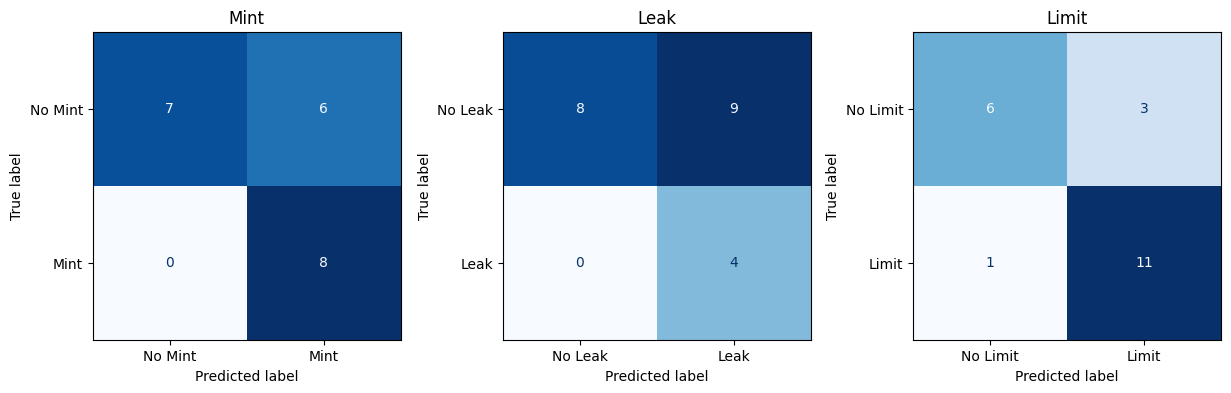

In [ ]:
y_pred = tuned_gru_model.predict(ts_X_test)
thresholds, _ = tune_thresholds(ts_y_test, y_pred)

y_pred = (y_pred > thresholds).astype(int)
plot_confusion_matrix(ts_y_test, y_pred)

### Graph

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

class GCN(nn.Module):
    def __init__(self, in_channels, hidden, out_channels, dropout=0.0):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin = nn.Linear(hidden, out_channels)
        self.dropout = dropout
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

#### Transaction

##### Load Data

In [ ]:
graph_feature = load_feature('txn_graph_features.csv')
graph_feature.index = graph_feature.index.str.lower()
graphs = pickle.load(open(os.path.join(PATH, 'txn.pkl'), 'rb'))

In [ ]:
train_dataset, test_dataset = [], []
txn_graph_y_train, txn_graph_y_test = [], []
txn_graph_test_idx = []
for i, (address, graph_data) in enumerate(graphs.items()):
    feature = graph_feature.loc[address]
    data = from_networkx(graph_data)

    data.x = torch.tensor(feature, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
    data.y = torch.tensor(y.loc[address][label_cols].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension

    if address in train_idx:
        train_dataset.append(data)
        txn_graph_y_train.append(y.loc[address])
    elif address in test_idx:
        test_dataset.append(data)
        txn_graph_y_test.append(y.loc[address])
        txn_graph_test_idx.append(address)

    if i < 10:
        print(data)

Data(edge_index=[2, 1], tx_hash=[1], label=[1], gas=[1], num_nodes=2, x=[2, 6], y=[1, 3])
Data(edge_index=[2, 13], tx_hash=[13], label=[13], gas=[13], num_nodes=14, x=[14, 6], y=[1, 3])
Data(edge_index=[2, 65], tx_hash=[65], label=[65], gas=[65], num_nodes=66, x=[66, 6], y=[1, 3])
Data(edge_index=[2, 56], tx_hash=[56], label=[56], gas=[56], num_nodes=57, x=[57, 6], y=[1, 3])
Data(edge_index=[2, 252], tx_hash=[252], label=[252], gas=[252], num_nodes=253, x=[253, 6], y=[1, 3])
Data(edge_index=[2, 2], tx_hash=[2], label=[2], gas=[2], num_nodes=3, x=[3, 6], y=[1, 3])
Data(edge_index=[2, 5869], tx_hash=[5869], label=[5869], gas=[5869], num_nodes=5870, x=[5870, 6], y=[1, 3])
Data(edge_index=[2, 944], tx_hash=[944], label=[944], gas=[944], num_nodes=945, x=[945, 6], y=[1, 3])
Data(edge_index=[2, 58], tx_hash=[58], label=[58], gas=[58], num_nodes=59, x=[59, 6], y=[1, 3])
Data(edge_index=[2, 2], tx_hash=[2], label=[2], gas=[2], num_nodes=3, x=[3, 6], y=[1, 3])


In [ ]:
len(train_dataset), len(test_dataset)

(26, 11)

In [ ]:
txn_graph_train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
txn_graph_test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

##### Tuning

In [ ]:
epochs = 30

In [ ]:
def objective(trial):
    # Tune hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.8)

    # Model setup
    model = GCN(in_channels=graph_feature.shape[1], hidden=hidden_dim, out_channels=len(label_cols), dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Training
    model.train()
    for epoch in range(epochs):
        for batch in txn_graph_train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y.float())
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in txn_graph_test_loader:
            out = model(batch)
            preds = (torch.sigmoid(out) > 0.5).cpu().int()
            y_true.append(batch.y.cpu())
            y_pred.append(preds)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    best_thresholds, _ = tune_thresholds(y_true, y_pred)
    y_pred = (y_pred > thresholds).astype(int)

    return f1_score(y_true, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-30 12:13:01,829] A new study created in memory with name: no-name-dbc80dd1-9e27-45bd-b240-f2c608ccfa56


Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:13:19,008] Trial 0 finished with value: 0.4083333333333334 and parameters: {'hidden_dim': 247, 'lr': 6.837693864099463e-05, 'dropout': 0.5875908682370697}. Best is trial 0 with value: 0.4083333333333334.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-30 12:13:25,454] Trial 1 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 124, 'lr': 1.7251934211497234e-06, 'dropout': 0.7496970176303249}. Best is trial 0 with value: 0.4083333333333334.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-30 12:13:45,326] Trial 2 finished with value: 0.0 and parameters: {'hidden_dim': 236, 'lr': 0.0008490425994054099, 'dropout': 0.7015095359268344}. Best is trial 0 with value: 0.4083333333333334.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:13:49,053] Trial 3 finished with value: 0.0 and parameters: {'hidden_dim': 52, 'lr': 0.00026992490655525, 'dropout': 0.45319217630015163}. Best is trial 0 with value: 0.4083333333333334.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:14:10,194] Trial 4 finished with value: 0.4222222222222222 and parameters: {'hidden_dim': 248, 'lr': 0.00010085820271994675, 'dropout': 0.6502194570938172}. Best is trial 4 with value: 0.4222222222222222.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:14:21,536] Trial 5 finished with value: 0.0 and parameters: {'hidden_dim': 162, 'lr': 0.002028788373503358, 'dropout': 0.30138895378858915}. Best is trial 4 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625


[I 2025-07-30 12:14:29,300] Trial 6 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 127, 'lr': 0.0007690205130419934, 'dropout': 0.7989897538142838}. Best is trial 4 with value: 0.4222222222222222.


Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:14:36,816] Trial 7 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 104, 'lr': 0.0008283312084906758, 'dropout': 0.4725125262908271}. Best is trial 4 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:14:50,457] Trial 8 finished with value: 0.36507936507936506 and parameters: {'hidden_dim': 200, 'lr': 3.899068836073228e-05, 'dropout': 0.47437727137916347}. Best is trial 4 with value: 0.4222222222222222.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:14:56,043] Trial 9 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 100, 'lr': 0.00020939850064805756, 'dropout': 0.04367526696264808}. Best is trial 4 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.01, Best f1 = 0.3333333333333333


[I 2025-07-30 12:15:06,879] Trial 10 finished with value: 0.3194444444444444 and parameters: {'hidden_dim': 187, 'lr': 8.464564978212103e-06, 'dropout': 0.17821693110850167}. Best is trial 4 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:15:22,287] Trial 11 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 255, 'lr': 5.309533278196318e-05, 'dropout': 0.5904862489033661}. Best is trial 4 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-30 12:15:35,717] Trial 12 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 221, 'lr': 0.006670875410470489, 'dropout': 0.6174867233456663}. Best is trial 4 with value: 0.4222222222222222.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:15:50,648] Trial 13 finished with value: 0.0 and parameters: {'hidden_dim': 255, 'lr': 1.3949573612121218e-05, 'dropout': 0.6467738905956499}. Best is trial 4 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-30 12:16:01,715] Trial 14 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 201, 'lr': 1.3676458401745964e-05, 'dropout': 0.5452849606506951}. Best is trial 4 with value: 0.4222222222222222.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:16:10,635] Trial 15 finished with value: 0.2380952380952381 and parameters: {'hidden_dim': 173, 'lr': 9.415573968878904e-05, 'dropout': 0.31721560324999476}. Best is trial 4 with value: 0.4222222222222222.


Label 2: Best threshold = 0.01, Best f1 = 0.7142857142857143
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.01, Best f1 = 0.4


[I 2025-07-30 12:16:23,625] Trial 16 finished with value: 0.4984126984126984 and parameters: {'hidden_dim': 224, 'lr': 3.1768660446974716e-06, 'dropout': 0.3681430658053837}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:16:36,214] Trial 17 finished with value: 0.2638888888888889 and parameters: {'hidden_dim': 222, 'lr': 1.864633450649447e-06, 'dropout': 0.35181282606501907}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:16:48,059] Trial 18 finished with value: 0.0 and parameters: {'hidden_dim': 211, 'lr': 5.239124963845714e-06, 'dropout': 0.21213075647418148}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:16:56,242] Trial 19 finished with value: 0.1984126984126984 and parameters: {'hidden_dim': 152, 'lr': 3.5285785664542883e-06, 'dropout': 0.21267907275105116}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625


[I 2025-07-30 12:17:00,692] Trial 20 finished with value: 0.3386243386243386 and parameters: {'hidden_dim': 62, 'lr': 2.2681209719254605e-05, 'dropout': 0.03327247125753685}. Best is trial 16 with value: 0.4984126984126984.


Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:17:22,123] Trial 21 finished with value: 0.0 and parameters: {'hidden_dim': 237, 'lr': 0.0001632471096877052, 'dropout': 0.5402460352171445}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:17:39,313] Trial 22 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 244, 'lr': 6.924531189301766e-05, 'dropout': 0.41161893845644404}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:17:52,370] Trial 23 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 227, 'lr': 2.9385899673640675e-05, 'dropout': 0.655313910054612}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.01, Best f1 = 0.4


[I 2025-07-30 12:18:02,640] Trial 24 finished with value: 0.27619047619047615 and parameters: {'hidden_dim': 193, 'lr': 1.0411307147922887e-06, 'dropout': 0.5640257746887771}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:18:26,721] Trial 25 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 253, 'lr': 0.00024990508260840083, 'dropout': 0.7102815255707476}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:18:39,275] Trial 26 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 214, 'lr': 0.006592245923228805, 'dropout': 0.5132694780194498}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:18:51,309] Trial 27 finished with value: 0.0 and parameters: {'hidden_dim': 175, 'lr': 0.00045539995704984936, 'dropout': 0.3519615095941854}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:19:06,964] Trial 28 finished with value: 0.4222222222222222 and parameters: {'hidden_dim': 228, 'lr': 9.391353703709564e-05, 'dropout': 0.4043970538961894}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625


[I 2025-07-30 12:19:10,748] Trial 29 finished with value: 0.0 and parameters: {'hidden_dim': 33, 'lr': 0.001762640151050066, 'dropout': 0.12895165853954021}. Best is trial 16 with value: 0.4984126984126984.


Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:19:27,022] Trial 30 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 237, 'lr': 0.00012578880791814105, 'dropout': 0.28022962199474655}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:19:45,979] Trial 31 finished with value: 0.07407407407407407 and parameters: {'hidden_dim': 229, 'lr': 9.179824602999263e-05, 'dropout': 0.39368189217806043}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:20:03,608] Trial 32 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 210, 'lr': 0.00037543899527212315, 'dropout': 0.7265355966220255}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:20:18,721] Trial 33 finished with value: 0.0 and parameters: {'hidden_dim': 243, 'lr': 1.9731525189111074e-05, 'dropout': 0.6622317213774146}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:20:33,949] Trial 34 finished with value: 0.0 and parameters: {'hidden_dim': 240, 'lr': 5.9204082217677115e-05, 'dropout': 0.38982911700652184}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:20:43,143] Trial 35 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 176, 'lr': 3.3246923760303377e-06, 'dropout': 0.7918977866493255}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:20:51,942] Trial 36 finished with value: 0.32996632996632996 and parameters: {'hidden_dim': 134, 'lr': 0.001805022484282006, 'dropout': 0.5053174631638043}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:21:08,408] Trial 37 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 227, 'lr': 0.0004383930436093842, 'dropout': 0.43550915493785325}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:21:25,214] Trial 38 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 207, 'lr': 3.3553344295018895e-05, 'dropout': 0.7621064163205247}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:21:31,727] Trial 39 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 107, 'lr': 0.00014746890537314182, 'dropout': 0.2505931565881109}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-30 12:21:53,652] Trial 40 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 247, 'lr': 8.500316988278494e-06, 'dropout': 0.6009826448482635}. Best is trial 16 with value: 0.4984126984126984.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:22:03,171] Trial 41 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 192, 'lr': 3.9360280726692044e-05, 'dropout': 0.47878534501522174}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666


[I 2025-07-30 12:22:13,472] Trial 42 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 200, 'lr': 4.798647407332059e-05, 'dropout': 0.4630303433538235}. Best is trial 16 with value: 0.4984126984126984.


Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:22:25,642] Trial 43 finished with value: 0.0 and parameters: {'hidden_dim': 219, 'lr': 8.614703096458088e-05, 'dropout': 0.3496582730363825}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:22:38,755] Trial 44 finished with value: 0.36507936507936506 and parameters: {'hidden_dim': 233, 'lr': 1.408357720847019e-05, 'dropout': 0.5763614676002409}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:22:49,312] Trial 45 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 159, 'lr': 0.0002244971296761545, 'dropout': 0.62438021811447}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:23:17,706] Trial 46 finished with value: 0.0 and parameters: {'hidden_dim': 254, 'lr': 0.0010540672405331833, 'dropout': 0.5195518417768679}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:23:30,300] Trial 47 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 185, 'lr': 0.0001385646059142875, 'dropout': 0.47990064531123977}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:23:44,456] Trial 48 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 201, 'lr': 7.688212856122993e-06, 'dropout': 0.6791639248344314}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:23:56,646] Trial 49 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 217, 'lr': 2.1974042212595917e-05, 'dropout': 0.29975569031811755}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-30 12:24:10,816] Trial 50 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 231, 'lr': 1.8964248661003304e-06, 'dropout': 0.4322367397075983}. Best is trial 16 with value: 0.4984126984126984.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-30 12:24:28,844] Trial 51 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 234, 'lr': 1.3786297722265533e-05, 'dropout': 0.5713224317306752}. Best is trial 16 with value: 0.4984126984126984.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:24:47,997] Trial 52 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 247, 'lr': 6.19813585323609e-05, 'dropout': 0.6268912090126664}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:25:00,421] Trial 53 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 223, 'lr': 5.223011449732131e-06, 'dropout': 0.5785461089815503}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:25:26,064] Trial 54 finished with value: 0.0 and parameters: {'hidden_dim': 247, 'lr': 4.4184331197906864e-05, 'dropout': 0.533784709533542}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:25:39,412] Trial 55 finished with value: 0.0 and parameters: {'hidden_dim': 235, 'lr': 2.727315470645573e-05, 'dropout': 0.36711377078098284}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:25:50,995] Trial 56 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 209, 'lr': 1.001741484338661e-05, 'dropout': 0.4899293028126368}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:26:03,346] Trial 57 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 221, 'lr': 7.379020384058875e-05, 'dropout': 0.44547318246283785}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.01, Best f1 = 0.4


[I 2025-07-30 12:26:08,020] Trial 58 finished with value: 0.2814814814814815 and parameters: {'hidden_dim': 83, 'lr': 1.8939830523295362e-05, 'dropout': 0.5459132089013928}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:26:25,691] Trial 59 finished with value: 0.0 and parameters: {'hidden_dim': 251, 'lr': 1.2594279740555546e-06, 'dropout': 0.689842018820714}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:26:50,828] Trial 60 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 239, 'lr': 0.00033093612105728783, 'dropout': 0.4175531393733278}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625


[I 2025-07-30 12:26:55,695] Trial 61 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 76, 'lr': 2.921524073376952e-06, 'dropout': 0.017796955844101625}. Best is trial 16 with value: 0.4984126984126984.


Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.01, Best f1 = 0.3333333333333333


[I 2025-07-30 12:26:59,178] Trial 62 finished with value: 0.3194444444444444 and parameters: {'hidden_dim': 49, 'lr': 0.00010228220611645433, 'dropout': 0.11060149816842726}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:27:05,644] Trial 63 finished with value: 0.3511904761904762 and parameters: {'hidden_dim': 114, 'lr': 5.540163703209048e-06, 'dropout': 0.0691393553455738}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:27:12,167] Trial 64 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 125, 'lr': 4.859016917958781e-06, 'dropout': 0.11972830555508715}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.01, Best f1 = 0.4


[I 2025-07-30 12:27:17,888] Trial 65 finished with value: 0.13333333333333333 and parameters: {'hidden_dim': 100, 'lr': 2.330272305794065e-06, 'dropout': 0.0897409188010085}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:27:25,452] Trial 66 finished with value: 0.2638888888888889 and parameters: {'hidden_dim': 143, 'lr': 1.1079892965006043e-05, 'dropout': 0.18103701301580372}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.01, Best f1 = 0.18181818181818182


[I 2025-07-30 12:27:40,271] Trial 67 finished with value: 0.26060606060606056 and parameters: {'hidden_dim': 256, 'lr': 7.378338245004368e-06, 'dropout': 0.3258511442130641}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:27:47,275] Trial 68 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 117, 'lr': 0.0001772783086352613, 'dropout': 0.6051495784464357}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:28:04,130] Trial 69 finished with value: 0.0 and parameters: {'hidden_dim': 228, 'lr': 3.985483818639683e-06, 'dropout': 0.6441670429726725}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:28:17,444] Trial 70 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 240, 'lr': 1.610117250125863e-05, 'dropout': 0.7209869578107403}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:28:22,050] Trial 71 finished with value: 0.0 and parameters: {'hidden_dim': 66, 'lr': 2.553262792233963e-05, 'dropout': 0.06382744222920173}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:28:25,103] Trial 72 finished with value: 0.07407407407407407 and parameters: {'hidden_dim': 33, 'lr': 3.6942095481282785e-05, 'dropout': 0.0041035145647703025}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:28:31,459] Trial 73 finished with value: 0.36507936507936506 and parameters: {'hidden_dim': 93, 'lr': 1.1719605768186413e-05, 'dropout': 0.5540355615294228}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625


[I 2025-07-30 12:28:36,902] Trial 74 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 83, 'lr': 6.209986452941975e-06, 'dropout': 0.5688368624174207}. Best is trial 16 with value: 0.4984126984126984.


Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:28:42,193] Trial 75 finished with value: 0.0 and parameters: {'hidden_dim': 99, 'lr': 1.195191922639848e-05, 'dropout': 0.504854664925883}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:28:48,586] Trial 76 finished with value: 0.2169312169312169 and parameters: {'hidden_dim': 89, 'lr': 5.515670843768115e-05, 'dropout': 0.5418063109180821}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625


[I 2025-07-30 12:28:55,146] Trial 77 finished with value: 0.3333333333333333 and parameters: {'hidden_dim': 132, 'lr': 1.7409215387472498e-05, 'dropout': 0.5925355807234871}. Best is trial 16 with value: 0.4984126984126984.


Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:29:02,020] Trial 78 finished with value: 0.3703703703703704 and parameters: {'hidden_dim': 115, 'lr': 0.00011378704782358481, 'dropout': 0.6652181571998113}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:29:07,480] Trial 79 finished with value: 0.3703703703703704 and parameters: {'hidden_dim': 94, 'lr': 0.00018650795919820378, 'dropout': 0.7425696199515978}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:29:39,447] Trial 80 finished with value: 0.07407407407407407 and parameters: {'hidden_dim': 225, 'lr': 0.0006638865745652265, 'dropout': 0.7374649046396502}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:29:44,880] Trial 81 finished with value: 0.0 and parameters: {'hidden_dim': 94, 'lr': 0.0001909585089210533, 'dropout': 0.7581802074489019}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6


[I 2025-07-30 12:29:51,081] Trial 82 finished with value: 0.29523809523809524 and parameters: {'hidden_dim': 108, 'lr': 0.00010857524610942366, 'dropout': 0.6671357392823283}. Best is trial 16 with value: 0.4984126984126984.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:29:57,385] Trial 83 finished with value: 0.19047619047619047 and parameters: {'hidden_dim': 119, 'lr': 7.995748184180248e-05, 'dropout': 0.7012623796959124}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:30:17,008] Trial 84 finished with value: 0.0 and parameters: {'hidden_dim': 214, 'lr': 0.0002699697788310871, 'dropout': 0.6345357684543272}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:30:21,220] Trial 85 finished with value: 0.4222222222222222 and parameters: {'hidden_dim': 73, 'lr': 6.438962037585302e-05, 'dropout': 0.3893312991424377}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.01, Best f1 = 0.5
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:30:25,279] Trial 86 finished with value: 0.38888888888888884 and parameters: {'hidden_dim': 64, 'lr': 0.0001213296408885274, 'dropout': 0.3731177150792801}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:30:30,016] Trial 87 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 69, 'lr': 0.00011231181017342285, 'dropout': 0.37229693360577637}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:30:34,226] Trial 88 finished with value: 0.2740740740740741 and parameters: {'hidden_dim': 54, 'lr': 0.000142532401669085, 'dropout': 0.3339281036111752}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:30:38,240] Trial 89 finished with value: 0.0 and parameters: {'hidden_dim': 57, 'lr': 0.0002443000394970416, 'dropout': 0.3885135968452393}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666


[I 2025-07-30 12:30:43,072] Trial 90 finished with value: 0.3703703703703704 and parameters: {'hidden_dim': 77, 'lr': 0.00032504003729694935, 'dropout': 0.42135006595234215}. Best is trial 16 with value: 0.4984126984126984.


Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:30:47,844] Trial 91 finished with value: 0.0 and parameters: {'hidden_dim': 72, 'lr': 0.0005779232669044901, 'dropout': 0.45037495296655616}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:30:51,600] Trial 92 finished with value: 0.4222222222222222 and parameters: {'hidden_dim': 44, 'lr': 6.539774639706939e-05, 'dropout': 0.4161502308159454}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:30:55,220] Trial 93 finished with value: 0.4222222222222222 and parameters: {'hidden_dim': 47, 'lr': 0.00031873014908862565, 'dropout': 0.2779878852060894}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:30:58,897] Trial 94 finished with value: 0.0 and parameters: {'hidden_dim': 43, 'lr': 7.368103346656893e-05, 'dropout': 0.28253682939756897}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:31:02,450] Trial 95 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 44, 'lr': 0.00011833293543346656, 'dropout': 0.260538354696248}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:31:07,106] Trial 96 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 64, 'lr': 0.0011234040161437896, 'dropout': 0.3061354952533345}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:31:10,443] Trial 97 finished with value: 0.0 and parameters: {'hidden_dim': 44, 'lr': 0.0001589642745631369, 'dropout': 0.23815105804884915}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:31:14,279] Trial 98 finished with value: 0.2857142857142857 and parameters: {'hidden_dim': 59, 'lr': 0.008658758610460827, 'dropout': 0.7987513001724587}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-30 12:31:19,074] Trial 99 finished with value: 0.36507936507936506 and parameters: {'hidden_dim': 49, 'lr': 6.337190805056535e-05, 'dropout': 0.40093530151109247}. Best is trial 16 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Best Params: {'hidden_dim': 224, 'lr': 3.1768660446974716e-06, 'dropout': 0.3681430658053837}
Best Score: 0.4984126984126984


##### Final

Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
              precision    recall  f1-score   support

        Mint       0.43      1.00      0.60         3
        Leak       0.00      0.00      0.00         1
       Limit       0.00      0.00      0.00         5

   micro avg       0.43      0.33      0.38         9
   macro avg       0.14      0.33      0.20         9
weighted avg       0.14      0.33      0.20         9
 samples avg       0.27      0.14      0.18         9



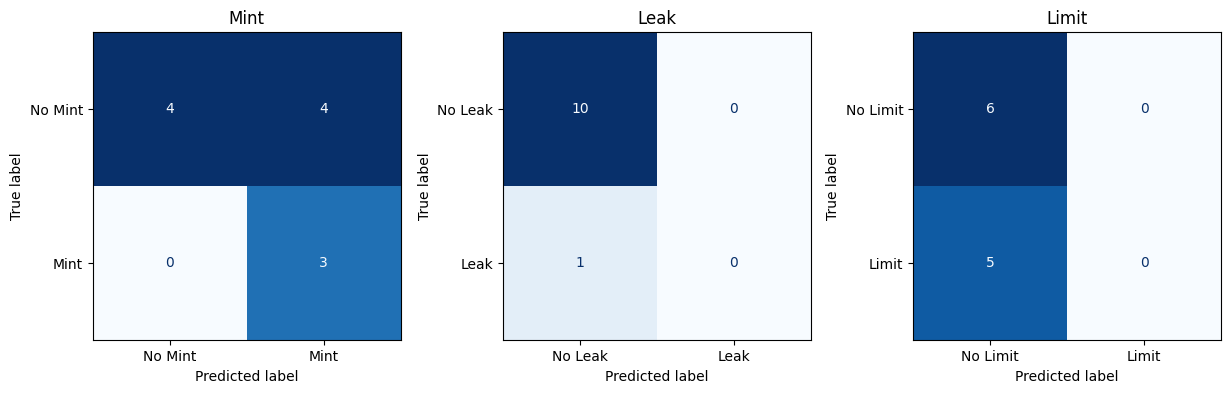

In [ ]:
# Model setup
tuned_txn_gcn_model = GCN(in_channels=graph_feature.shape[1], hidden=study.best_params['hidden_dim'], out_channels=len(label_cols), dropout=study.best_params['dropout'])
optimizer = torch.optim.Adam(tuned_txn_gcn_model.parameters(), lr=study.best_params['lr'])
criterion = nn.BCEWithLogitsLoss()

# Training
tuned_txn_gcn_model.train()
for epoch in range(epochs):
    for batch in txn_graph_train_loader:
        optimizer.zero_grad()
        out = tuned_txn_gcn_model(batch)
        loss = criterion(out, batch.y.float())
        loss.backward()
        optimizer.step()

# Validation
tuned_txn_gcn_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in txn_graph_test_loader:
        out = tuned_txn_gcn_model(batch)
        preds = (torch.sigmoid(out) > 0.5).cpu().int()
        y_true.append(batch.y.cpu())
        y_pred.append(preds)

y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

best_thresholds, _ = tune_thresholds(y_true, y_pred)
y_pred = (y_pred > thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

#### Control Flow

##### Load Data

In [ ]:
graph_feature = load_feature('cfg_graph_features.csv')
graph_feature.index = graph_feature.index.str.lower()
graphs = pickle.load(open(os.path.join(PATH, 'cfg.pkl'), 'rb'))

In [ ]:
train_dataset, test_dataset = [], []
cfg_graph_y_train, cfg_graph_y_test = [], []
cfg_graph_test_idx = []
for i, (address, graph_data) in enumerate(graphs.items()):
    feature = graph_feature.loc[address]
    data = from_networkx(graph_data)

    data.x = torch.tensor(feature, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
    data.y = torch.tensor(y.loc[address][label_cols].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension

    if address in train_idx:
        train_dataset.append(data)
        cfg_graph_y_train.append(y.loc[address])
    elif address in test_idx:
        test_dataset.append(data)
        cfg_graph_y_test.append(y.loc[address])
        cfg_graph_test_idx.append(address)

    if i < 10:
        print(data)

Data(edge_index=[2, 118], num_nodes=155, x=[155, 6], y=[1, 3])
Data(edge_index=[2, 96], num_nodes=194, x=[194, 6], y=[1, 3])
Data(edge_index=[2, 178], num_nodes=339, x=[339, 6], y=[1, 3])
Data(edge_index=[2, 78], num_nodes=113, x=[113, 6], y=[1, 3])
Data(edge_index=[2, 211], num_nodes=303, x=[303, 6], y=[1, 3])
Data(edge_index=[2, 158], num_nodes=377, x=[377, 6], y=[1, 3])
Data(edge_index=[2, 365], num_nodes=683, x=[683, 6], y=[1, 3])
Data(edge_index=[2, 137], num_nodes=215, x=[215, 6], y=[1, 3])
Data(edge_index=[2, 96], num_nodes=192, x=[192, 6], y=[1, 3])
Data(edge_index=[2, 4], num_nodes=584, x=[584, 6], y=[1, 3])


In [ ]:
len(train_dataset), len(test_dataset)

(47, 20)

In [ ]:
cfg_graph_train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
cfg_graph_test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

##### Tuning

In [ ]:
epochs = 30

In [ ]:
def objective(trial):
    # Tune hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.8)

    # Model setup
    model = GCN(in_channels=graph_feature.shape[1], hidden=hidden_dim, out_channels=len(label_cols), dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Training
    model.train()
    for epoch in range(epochs):
        for batch in cfg_graph_train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y.float())
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in cfg_graph_test_loader:
            out = model(batch)
            preds = (torch.sigmoid(out) > 0.5).cpu().int()
            y_true.append(batch.y.cpu())
            y_pred.append(preds)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    best_thresholds, _ = tune_thresholds(y_true, y_pred)
    y_pred = (y_pred > thresholds).astype(int)

    return f1_score(y_true, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-30 12:32:03,714] A new study created in memory with name: no-name-efd947fc-540f-4a63-bbb2-60c6a66c0055


Label 0: Best threshold = 0.01, Best f1 = 0.5333333333333333
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:32:09,520] Trial 0 finished with value: 0.32929292929292925 and parameters: {'hidden_dim': 111, 'lr': 0.007526447376422313, 'dropout': 0.675924061609684}. Best is trial 0 with value: 0.32929292929292925.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:32:17,285] Trial 1 finished with value: 0.41798941798941797 and parameters: {'hidden_dim': 204, 'lr': 0.0008323879660456759, 'dropout': 0.7411244528888498}. Best is trial 1 with value: 0.41798941798941797.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:32:21,834] Trial 2 finished with value: 0.28417818740399386 and parameters: {'hidden_dim': 83, 'lr': 1.9279519246377155e-06, 'dropout': 0.07178065270053828}. Best is trial 1 with value: 0.41798941798941797.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-30 12:32:27,567] Trial 3 finished with value: 0.0 and parameters: {'hidden_dim': 148, 'lr': 4.189813205303813e-06, 'dropout': 0.7042929988920247}. Best is trial 1 with value: 0.41798941798941797.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-30 12:32:34,467] Trial 4 finished with value: 0.21728395061728392 and parameters: {'hidden_dim': 158, 'lr': 2.7037578632348107e-05, 'dropout': 0.4168285857448417}. Best is trial 1 with value: 0.41798941798941797.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:32:43,862] Trial 5 finished with value: 0.2839506172839506 and parameters: {'hidden_dim': 227, 'lr': 3.950749947019263e-05, 'dropout': 0.7942414377847201}. Best is trial 1 with value: 0.41798941798941797.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.5833333333333334
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:32:49,691] Trial 6 finished with value: 0.5421146953405018 and parameters: {'hidden_dim': 148, 'lr': 3.3624123867297943e-06, 'dropout': 0.4445914547094325}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 1: Best threshold = 0.01, Best f1 = 0.36363636363636365


[I 2025-07-30 12:32:53,526] Trial 7 finished with value: 0.47676767676767673 and parameters: {'hidden_dim': 73, 'lr': 0.0017533520962926543, 'dropout': 0.6493027639983945}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.56
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:32:59,071] Trial 8 finished with value: 0.2342857142857143 and parameters: {'hidden_dim': 109, 'lr': 0.0008924278568111293, 'dropout': 0.34122330766013614}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-30 12:33:03,496] Trial 9 finished with value: 0.4587813620071685 and parameters: {'hidden_dim': 91, 'lr': 8.300852251138297e-06, 'dropout': 0.5576437058151836}. Best is trial 6 with value: 0.5421146953405018.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-30 12:33:06,596] Trial 10 finished with value: 0.0 and parameters: {'hidden_dim': 35, 'lr': 1.0310665928585025e-06, 'dropout': 0.19388028791093914}. Best is trial 6 with value: 0.5421146953405018.


Label 0: Best threshold = 0.01, Best f1 = 0.56
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:33:10,398] Trial 11 finished with value: 0.40888888888888886 and parameters: {'hidden_dim': 41, 'lr': 0.00041503118736524594, 'dropout': 0.5244654004848996}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:33:17,119] Trial 12 finished with value: 0.29971988795518206 and parameters: {'hidden_dim': 173, 'lr': 0.009643468223629435, 'dropout': 0.5403901762805119}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.4


[I 2025-07-30 12:33:25,022] Trial 13 finished with value: 0.48566001899335226 and parameters: {'hidden_dim': 189, 'lr': 0.00017987630601206273, 'dropout': 0.34673795242805655}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:33:35,871] Trial 14 finished with value: 0.3950617283950617 and parameters: {'hidden_dim': 255, 'lr': 0.00011231324458211855, 'dropout': 0.303734482516677}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:33:42,817] Trial 15 finished with value: 0.14035087719298245 and parameters: {'hidden_dim': 186, 'lr': 0.00015070075499786713, 'dropout': 0.2534852911784789}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-30 12:33:48,771] Trial 16 finished with value: 0.08333333333333333 and parameters: {'hidden_dim': 136, 'lr': 1.5068865392907293e-05, 'dropout': 0.4230076982595113}. Best is trial 6 with value: 0.5421146953405018.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:33:56,245] Trial 17 finished with value: 0.26837606837606837 and parameters: {'hidden_dim': 204, 'lr': 5.9552492028726825e-05, 'dropout': 0.1271283108235315}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:34:02,505] Trial 18 finished with value: 0.20448179271708686 and parameters: {'hidden_dim': 137, 'lr': 0.0002209011909104823, 'dropout': 0.46797849788807455}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:34:11,626] Trial 19 finished with value: 0.24509803921568626 and parameters: {'hidden_dim': 228, 'lr': 5.61758419171913e-06, 'dropout': 0.20731397555701797}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:34:18,139] Trial 20 finished with value: 0.24691358024691357 and parameters: {'hidden_dim': 165, 'lr': 1.9373035742121145e-05, 'dropout': 0.3468773959924139}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.5333333333333333
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:34:22,215] Trial 21 finished with value: 0.17777777777777778 and parameters: {'hidden_dim': 78, 'lr': 0.00267139290225, 'dropout': 0.620433024365402}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.5714285714285714
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:34:27,782] Trial 22 finished with value: 0.19047619047619047 and parameters: {'hidden_dim': 117, 'lr': 0.002431144403790898, 'dropout': 0.46897960096300156}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:34:31,367] Trial 23 finished with value: 0.34767025089605735 and parameters: {'hidden_dim': 61, 'lr': 0.0003689031580258736, 'dropout': 0.6158762135777301}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.5333333333333333
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:34:39,293] Trial 24 finished with value: 0.3922027290448343 and parameters: {'hidden_dim': 187, 'lr': 0.00251151630875309, 'dropout': 0.3503949029121053}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-30 12:34:44,525] Trial 25 finished with value: 0.2272727272727273 and parameters: {'hidden_dim': 129, 'lr': 6.75037380115557e-05, 'dropout': 0.010177539098007393}. Best is trial 6 with value: 0.5421146953405018.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:34:48,413] Trial 26 finished with value: 0.2828282828282828 and parameters: {'hidden_dim': 57, 'lr': 0.0011126524499003305, 'dropout': 0.6098955753101856}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:34:55,768] Trial 27 finished with value: 0.30617283950617286 and parameters: {'hidden_dim': 183, 'lr': 0.0002519553518328833, 'dropout': 0.4789322626875767}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:35:04,862] Trial 28 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 205, 'lr': 0.003798915516055037, 'dropout': 0.2778646153279353}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.4444444444444444


[I 2025-07-30 12:35:10,595] Trial 29 finished with value: 0.4607244607244607 and parameters: {'hidden_dim': 148, 'lr': 0.0005723496812149559, 'dropout': 0.6957047700442643}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:35:16,112] Trial 30 finished with value: 0.31070889894419307 and parameters: {'hidden_dim': 109, 'lr': 0.0060119964033311804, 'dropout': 0.7995824418477906}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.34782608695652173


[I 2025-07-30 12:35:22,147] Trial 31 finished with value: 0.28878153515834676 and parameters: {'hidden_dim': 154, 'lr': 0.0005716983484642813, 'dropout': 0.6706592268986488}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:35:29,348] Trial 32 finished with value: 0.2878151260504202 and parameters: {'hidden_dim': 169, 'lr': 0.0014484067544310202, 'dropout': 0.7161782371244416}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.7058823529411765
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:35:35,015] Trial 33 finished with value: 0.420479302832244 and parameters: {'hidden_dim': 126, 'lr': 0.0005949598120644217, 'dropout': 0.6617013229660709}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:35:41,833] Trial 34 finished with value: 0.24242424242424243 and parameters: {'hidden_dim': 147, 'lr': 0.00015665369064529964, 'dropout': 0.7525514209942166}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:35:50,083] Trial 35 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 217, 'lr': 0.0015498734204374405, 'dropout': 0.5727398918194436}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:35:55,026] Trial 36 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 99, 'lr': 1.6820369120154721e-06, 'dropout': 0.7408207270305847}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-30 12:35:58,909] Trial 37 finished with value: 0.11594202898550725 and parameters: {'hidden_dim': 75, 'lr': 6.999700592551652e-05, 'dropout': 0.3843751928470361}. Best is trial 6 with value: 0.5421146953405018.


Label 1: Best threshold = 0.01, Best f1 = 0.34782608695652173
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:36:05,625] Trial 38 finished with value: 0.047619047619047616 and parameters: {'hidden_dim': 156, 'lr': 0.00030821741320984927, 'dropout': 0.5022978040095752}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-30 12:36:10,451] Trial 39 finished with value: 0.5176054506683311 and parameters: {'hidden_dim': 120, 'lr': 0.000665700052524996, 'dropout': 0.40762612907663986}. Best is trial 6 with value: 0.5421146953405018.


Label 1: Best threshold = 0.01, Best f1 = 0.47058823529411764
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.5882352941176471
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:36:14,912] Trial 40 finished with value: 0.25163398692810457 and parameters: {'hidden_dim': 98, 'lr': 3.2573559138132734e-05, 'dropout': 0.42892426588749766}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-30 12:36:20,672] Trial 41 finished with value: 0.3473389355742296 and parameters: {'hidden_dim': 119, 'lr': 0.0006120095495021834, 'dropout': 0.30249415367570104}. Best is trial 6 with value: 0.5421146953405018.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:36:26,434] Trial 42 finished with value: 0.16944444444444443 and parameters: {'hidden_dim': 143, 'lr': 0.0015180079898403614, 'dropout': 0.40020741703873536}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:36:33,883] Trial 43 finished with value: 0.34975369458128075 and parameters: {'hidden_dim': 177, 'lr': 0.0008917627757335832, 'dropout': 0.5722515490736468}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:36:41,553] Trial 44 finished with value: 0.24542124542124544 and parameters: {'hidden_dim': 193, 'lr': 0.005115315965027973, 'dropout': 0.22276942160872495}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:36:45,957] Trial 45 finished with value: 0.36507936507936506 and parameters: {'hidden_dim': 86, 'lr': 0.00017129643557120409, 'dropout': 0.3692898284829722}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:36:49,468] Trial 46 finished with value: 0.08333333333333333 and parameters: {'hidden_dim': 58, 'lr': 9.904173088289858e-05, 'dropout': 0.43728033500067354}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:36:59,617] Trial 47 finished with value: 0.2561728395061728 and parameters: {'hidden_dim': 250, 'lr': 0.00044366839500771207, 'dropout': 0.13788059045637707}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:37:06,329] Trial 48 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 164, 'lr': 1.2037836010332667e-05, 'dropout': 0.3167012672485673}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:37:10,343] Trial 49 finished with value: 0.08695652173913043 and parameters: {'hidden_dim': 70, 'lr': 0.0007941699410323301, 'dropout': 0.5220789412709556}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-30 12:37:14,830] Trial 50 finished with value: 0.0 and parameters: {'hidden_dim': 98, 'lr': 9.627259513150303e-05, 'dropout': 0.7041584820087343}. Best is trial 6 with value: 0.5421146953405018.


Label 0: Best threshold = 0.01, Best f1 = 0.5833333333333334
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:37:19,892] Trial 51 finished with value: 0.2611111111111111 and parameters: {'hidden_dim': 91, 'lr': 2.7950810703598546e-06, 'dropout': 0.5624987549188101}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:37:24,689] Trial 52 finished with value: 0.36437246963562747 and parameters: {'hidden_dim': 107, 'lr': 8.521684833324811e-06, 'dropout': 0.6002853888544766}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.56
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:37:27,811] Trial 53 finished with value: 0.18666666666666668 and parameters: {'hidden_dim': 41, 'lr': 4.225694934955509e-06, 'dropout': 0.6491023720196673}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:37:34,172] Trial 54 finished with value: 0.34767025089605735 and parameters: {'hidden_dim': 135, 'lr': 1.221470550972955e-06, 'dropout': 0.44881688303525014}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:37:39,043] Trial 55 finished with value: 0.2711111111111111 and parameters: {'hidden_dim': 120, 'lr': 6.529205983194577e-06, 'dropout': 0.4957862417132032}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:37:43,170] Trial 56 finished with value: 0.0 and parameters: {'hidden_dim': 88, 'lr': 2.374589285650699e-06, 'dropout': 0.6344075816762497}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:37:47,275] Trial 57 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 68, 'lr': 0.000259861552919635, 'dropout': 0.6894903853328666}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-30 12:37:52,722] Trial 58 finished with value: 0.37142857142857144 and parameters: {'hidden_dim': 131, 'lr': 2.0903921811758598e-05, 'dropout': 0.5515656219102367}. Best is trial 6 with value: 0.5421146953405018.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:37:56,118] Trial 59 finished with value: 0.4093986459577857 and parameters: {'hidden_dim': 48, 'lr': 3.222244901092457e-06, 'dropout': 0.7720755084820076}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:38:02,466] Trial 60 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 143, 'lr': 0.0019155291958966266, 'dropout': 0.5929148905877435}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.5833333333333334
Label 1: Best threshold = 0.01, Best f1 = 0.36363636363636365


[I 2025-07-30 12:38:07,535] Trial 61 finished with value: 0.5225531173807036 and parameters: {'hidden_dim': 121, 'lr': 0.0006069836747704348, 'dropout': 0.6571014677779248}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:38:12,983] Trial 62 finished with value: 0.4093986459577857 and parameters: {'hidden_dim': 114, 'lr': 4.4486481878914816e-05, 'dropout': 0.7128643298549213}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:38:19,193] Trial 63 finished with value: 0.291005291005291 and parameters: {'hidden_dim': 151, 'lr': 0.0011417887729803088, 'dropout': 0.5289955268222675}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.4


[I 2025-07-30 12:38:24,932] Trial 64 finished with value: 0.42356321839080463 and parameters: {'hidden_dim': 124, 'lr': 0.0004502668017426473, 'dropout': 0.39967762783084776}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:38:29,538] Trial 65 finished with value: 0.0 and parameters: {'hidden_dim': 102, 'lr': 0.0007701410272521145, 'dropout': 0.6437180095055526}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:38:35,548] Trial 66 finished with value: 0.22826086956521738 and parameters: {'hidden_dim': 136, 'lr': 0.0034845490364244155, 'dropout': 0.6815372744690054}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:38:44,617] Trial 67 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 231, 'lr': 0.0011456887021406863, 'dropout': 0.3615115704907106}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-30 12:38:51,867] Trial 68 finished with value: 0.22222222222222224 and parameters: {'hidden_dim': 163, 'lr': 0.00018927284135965972, 'dropout': 0.3264015101469556}. Best is trial 6 with value: 0.5421146953405018.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:38:55,965] Trial 69 finished with value: 0.21296296296296294 and parameters: {'hidden_dim': 81, 'lr': 0.00030427957376955435, 'dropout': 0.7505876799997855}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.5333333333333333
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:39:04,127] Trial 70 finished with value: 0.30476190476190473 and parameters: {'hidden_dim': 195, 'lr': 0.0019896319753910582, 'dropout': 0.27398345562059345}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:39:08,950] Trial 71 finished with value: 0.3277777777777778 and parameters: {'hidden_dim': 120, 'lr': 0.0004645579912442688, 'dropout': 0.4115292088471298}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-30 12:39:14,868] Trial 72 finished with value: 0.31800766283524906 and parameters: {'hidden_dim': 127, 'lr': 0.0003561401202304134, 'dropout': 0.4539591777616805}. Best is trial 6 with value: 0.5421146953405018.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:39:20,610] Trial 73 finished with value: 0.37510442773600666 and parameters: {'hidden_dim': 140, 'lr': 0.00013796850123846448, 'dropout': 0.3825714356879666}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:39:26,261] Trial 74 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 108, 'lr': 0.0005126889307215448, 'dropout': 0.47398414441868963}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:39:33,145] Trial 75 finished with value: 0.2967032967032967 and parameters: {'hidden_dim': 159, 'lr': 0.0002232966291234275, 'dropout': 0.3424924566915119}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:39:38,167] Trial 76 finished with value: 0.36538609002377115 and parameters: {'hidden_dim': 92, 'lr': 0.0007587480339338813, 'dropout': 0.5072625903111726}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:39:44,872] Trial 77 finished with value: 0.3316239316239316 and parameters: {'hidden_dim': 173, 'lr': 0.0003602542274603897, 'dropout': 0.38682294727455474}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:39:50,769] Trial 78 finished with value: 0.14035087719298245 and parameters: {'hidden_dim': 126, 'lr': 0.0006500053299885973, 'dropout': 0.4036310114598501}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-30 12:39:56,668] Trial 79 finished with value: 0.3395061728395062 and parameters: {'hidden_dim': 150, 'lr': 0.0010659440553164895, 'dropout': 0.5879731114898156}. Best is trial 6 with value: 0.5421146953405018.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:40:01,716] Trial 80 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 103, 'lr': 4.710176090361718e-06, 'dropout': 0.7267434408320343}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:40:07,105] Trial 81 finished with value: 0.2940516273849607 and parameters: {'hidden_dim': 124, 'lr': 0.0006305033650376891, 'dropout': 0.6773861293785939}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-30 12:40:12,013] Trial 82 finished with value: 0.0 and parameters: {'hidden_dim': 115, 'lr': 0.00043055960702231876, 'dropout': 0.6563319478104328}. Best is trial 6 with value: 0.5421146953405018.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:40:18,085] Trial 83 finished with value: 0.24691358024691357 and parameters: {'hidden_dim': 133, 'lr': 0.0002900426154708362, 'dropout': 0.6237507798419579}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:40:24,095] Trial 84 finished with value: 0.21666666666666667 and parameters: {'hidden_dim': 147, 'lr': 0.0014282367565988353, 'dropout': 0.7734332937935947}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:40:32,706] Trial 85 finished with value: 0.34975369458128075 and parameters: {'hidden_dim': 212, 'lr': 0.0009651917884389299, 'dropout': 0.658345779667007}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-30 12:40:36,585] Trial 86 finished with value: 0.27777777777777773 and parameters: {'hidden_dim': 73, 'lr': 1.62194540324093e-06, 'dropout': 0.2846461448400259}. Best is trial 6 with value: 0.5421146953405018.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:40:44,044] Trial 87 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 179, 'lr': 1.0133252743552184e-05, 'dropout': 0.4331147575964347}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-30 12:40:48,742] Trial 88 finished with value: 0.30536130536130535 and parameters: {'hidden_dim': 112, 'lr': 0.0002063785564046896, 'dropout': 0.7070469696073299}. Best is trial 6 with value: 0.5421146953405018.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:40:53,748] Trial 89 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 93, 'lr': 0.0005778893867605348, 'dropout': 0.6887023693461777}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-30 12:40:58,886] Trial 90 finished with value: 0.15277777777777776 and parameters: {'hidden_dim': 123, 'lr': 0.0001243751660098034, 'dropout': 0.6192626633853239}. Best is trial 6 with value: 0.5421146953405018.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:41:07,188] Trial 91 finished with value: 0.3128205128205128 and parameters: {'hidden_dim': 202, 'lr': 0.0012609642988631775, 'dropout': 0.728795146323568}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:41:15,290] Trial 92 finished with value: 0.0 and parameters: {'hidden_dim': 220, 'lr': 0.0008761708004795074, 'dropout': 0.7612650128963867}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.5833333333333334


[I 2025-07-30 12:41:19,535] Trial 93 finished with value: 0.19444444444444445 and parameters: {'hidden_dim': 64, 'lr': 0.0017969294866798638, 'dropout': 0.7885379552990308}. Best is trial 6 with value: 0.5421146953405018.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:41:28,883] Trial 94 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 238, 'lr': 0.0007033620102640017, 'dropout': 0.36699398924231863}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.6086956521739131
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-30 12:41:36,643] Trial 95 finished with value: 0.32988267770876467 and parameters: {'hidden_dim': 190, 'lr': 0.0005057966926621801, 'dropout': 0.6698105303751922}. Best is trial 6 with value: 0.5421146953405018.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:41:42,775] Trial 96 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 139, 'lr': 0.0003573647345288472, 'dropout': 0.5759605791656942}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:41:50,968] Trial 97 finished with value: 0.2916666666666667 and parameters: {'hidden_dim': 209, 'lr': 0.0030500249452307233, 'dropout': 0.6976406504835534}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-30 12:41:59,298] Trial 98 finished with value: 0.25833333333333336 and parameters: {'hidden_dim': 199, 'lr': 0.004694593634400776, 'dropout': 0.7394857636675334}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.4


[I 2025-07-30 12:42:03,208] Trial 99 finished with value: 0.35555555555555557 and parameters: {'hidden_dim': 80, 'lr': 8.610549495897131e-05, 'dropout': 0.49147820647107543}. Best is trial 6 with value: 0.5421146953405018.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Best Params: {'hidden_dim': 148, 'lr': 3.3624123867297943e-06, 'dropout': 0.4445914547094325}
Best Score: 0.5421146953405018


##### Final

Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
              precision    recall  f1-score   support

        Mint       0.35      1.00      0.52         7
        Leak       0.00      0.00      0.00         4
       Limit       0.00      0.00      0.00        11

   micro avg       0.35      0.32      0.33        22
   macro avg       0.12      0.33      0.17        22
weighted avg       0.11      0.32      0.16        22
 samples avg       0.35      0.22      0.26        22



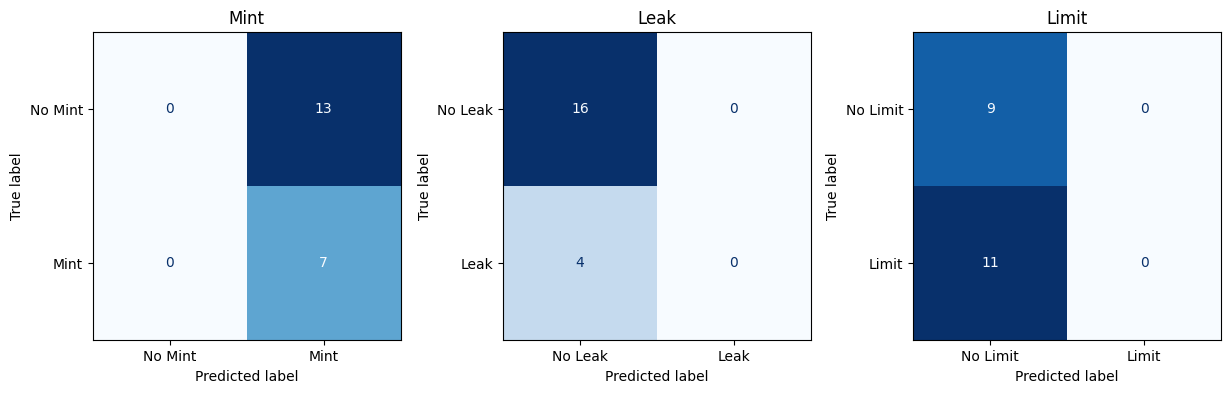

In [ ]:
# Model setup
tuned_cfg_gcn_model = GCN(in_channels=graph_feature.shape[1], hidden=study.best_params['hidden_dim'], out_channels=len(label_cols), dropout=study.best_params['dropout'])
optimizer = torch.optim.Adam(tuned_cfg_gcn_model.parameters(), lr=study.best_params['lr'])
criterion = nn.BCEWithLogitsLoss()

# Training
tuned_cfg_gcn_model.train()
for epoch in range(epochs):
    for batch in cfg_graph_train_loader:
        optimizer.zero_grad()
        out = tuned_cfg_gcn_model(batch)
        loss = criterion(out, batch.y.float())
        loss.backward()
        optimizer.step()

# Validation
tuned_cfg_gcn_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in cfg_graph_test_loader:
        out = tuned_cfg_gcn_model(batch)
        preds = (torch.sigmoid(out) > 0.5).cpu().int()
        y_true.append(batch.y.cpu())
        y_pred.append(preds)

y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

best_thresholds, _ = tune_thresholds(y_true, y_pred)
y_pred = (y_pred > thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

## Fusion

### Track Which Model Can Predict Which Address

In [ ]:
def predict(model, loader, thresholds=None):
    model.eval()
    y_true, y_probs, y_preds = [], [], []

    with torch.no_grad():
        for batch in loader:
            out = torch.sigmoid(model(batch))
            y_probs.append(out.cpu())
            y_true.append(batch.y.cpu())

    y_probs = torch.cat(y_probs).numpy()
    y_true = torch.cat(y_true).numpy()

    if thresholds is not None:
        y_preds = (y_probs > thresholds).astype(int)
    else:
        best_thresholds, _ = tune_thresholds(y_true, y_probs)
        y_preds = (y_probs > best_thresholds).astype(int)

    return y_true, y_preds, y_probs

In [ ]:
# For each model, create a dict of predictions and a set of supported addresses
available_preds = {}
available_prob = {}
available_y_true = {}
B_weights = {}
C_weights = {}
C_weights_normalized = {}

for model_name, model_obj, test_idx, X_test, y_test in [
    ("txn", tuned_txn_model, txn_test_idx, txn_X_test, txn_y_test),
    ("byte", tuned_byte_model, byte_test_idx, byte_X_test, byte_y_test),
    ("source", tuned_source_model, source_test_idx, source_X_test, source_y_test),
    ("timeseries", tuned_gru_model, ts_test_idx, ts_X_test, ts_y_test),
    ("txn_gcn", tuned_txn_gcn_model, txn_graph_test_idx, txn_graph_test_loader, txn_graph_y_test),
    ("cfg_gcn", tuned_cfg_gcn_model, cfg_graph_test_idx, cfg_graph_test_loader, cfg_graph_y_test)
]:
    print(f"Predicting {model_name}...")
    if model_name in ['txn_gcn', 'cfg_gcn']:
        _, y_pred, prob = predict(model_obj, X_test)
    else:
        y_pred = model_obj.predict(X_test)

        if model_name == 'timeseries':
            thresholds, _ = tune_thresholds(y_test, y_pred)
            prob = y_pred
            y_pred = (y_pred > thresholds).astype(int)
        else:
            proba = model_obj.predict_proba(X_test)
            prob = np.array([p[:, 1] for p in proba]).T  # shape: [n_samples, n_labels]

    available_prob[model_name] = {addr: prob for addr, prob in zip(test_idx, prob)}
    available_preds[model_name] = {addr: pred for addr, pred in zip(test_idx, y_pred)}
    y_test = np.array(y_test)
    available_y_true[model_name] = {addr: y for addr, y in zip(test_idx, y_test)}
    # avg weights
    B_weights[model_name] = f1_score(y_test, y_pred, average='macro')
    # per-lab weights
    C_weights[model_name] = f1_score(y_test, y_pred, average=None)
    C_weights_normalized[model_name] = C_weights[model_name] / np.sum(C_weights[model_name])

Predicting txn...
Predicting byte...
Predicting source...
Predicting timeseries...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Label 0: Best threshold = 0.28, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.13, Best f1 = 0.47058823529411764
Label 2: Best threshold = 0.41000000000000003, Best f1 = 0.8461538461538461
Predicting txn_gcn...
Label 0: Best threshold = 0.49, Best f1 = 0.6
Label 1: Best threshold = 0.49, Best f1 = 0.6666666666666666
Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Predicting cfg_gcn...
Label 0: Best threshold = 0.63, Best f1 = 0.6086956521739131
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


In [ ]:
B_weights

{'txn': 0.4488152749022314,
 'byte': 0.6,
 'source': 0.6295739348370927,
 'timeseries': 0.6813382695735637,
 'txn_gcn': 0.6444444444444444,
 'cfg_gcn': 0.550568801620695}

In [ ]:
C_weights

{'txn': array([0.22222222, 0.42857143, 0.69565217]),
 'byte': array([0.53333333, 0.66666667, 0.6       ]),
 'source': array([0.85714286, 0.4       , 0.63157895]),
 'timeseries': array([0.72727273, 0.47058824, 0.84615385]),
 'txn_gcn': array([0.6       , 0.66666667, 0.66666667]),
 'cfg_gcn': array([0.60869565, 0.33333333, 0.70967742])}

In [ ]:
C_weights_normalized

{'txn': array([0.16504357, 0.31829831, 0.51665812]),
 'byte': array([0.2962963 , 0.37037037, 0.33333333]),
 'source': array([0.45382166, 0.21178344, 0.3343949 ]),
 'timeseries': array([0.355806  , 0.23022741, 0.41396659]),
 'txn_gcn': array([0.31034483, 0.34482759, 0.34482759]),
 'cfg_gcn': array([0.36852533, 0.20181149, 0.42966318])}

In [ ]:
available_preds_df = pd.DataFrame(available_preds)
available_preds_df

,txn,byte,source,timeseries,txn_gcn,cfg_gcn
0x186ed770eecea82def7c92dcc077c4ba27acd5bd,"[1, 0, 0]","[0, 0, 0]","[0, 0, 0]","[1, 0, 1]","[1, 0, 0]","[1, 1, 1]"
0x93023f1d3525e273f291b6f76d2f5027a39bf302,"[0, 1, 1]","[0, 0, 0]",NaN,"[1, 1, 1]",NaN,NaN
0x16dfb898cf7029303c2376031392cb9bac450f94,"[0, 0, 0]","[1, 0, 0]","[0, 0, 0]","[0, 1, 0]","[0, 1, 1]","[1, 1, 1]"
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,"[0, 0, 0]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 1, 1]"
0xb504035a11e672e12a099f32b1672b9c4a78b22f,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[1, 0, 0]","[0, 1, 1]"
0x52e4339b4b9ff254738d6e971e83440f60dc029c,"[0, 1, 1]","[1, 0, 0]","[1, 0, 0]","[1, 1, 1]",NaN,"[1, 1, 1]"
0x5927b72440d8a8b8c6ca5a8be60e88975f9063fc,"[0, 1, 1]","[0, 0, 1]","[0, 0, 1]","[1, 1, 1]",NaN,"[1, 1, 1]"
0x8d07f605926837ea0f9e1e24dba0fb348cb3e97d,"[0, 1, 1]","[0, 1, 0]","[0, 0, 1]","[1, 1, 1]",NaN,"[1, 1, 1]"
0xaaf8c293ed36989d1871d2310b2845450d885673,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 1]","[1, 1, 1]"
0x1e4402fa427a7a835fc64ea6d051404ce767a569,"[0, 1, 1]","[1, 1, 1]","[0, 0, 1]","[1, 1, 1]",NaN,"[1, 1, 1]"


In [ ]:
available_y_true_df = pd.DataFrame(available_y_true)
available_y_true_df

,txn,byte,source,timeseries,txn_gcn,cfg_gcn
0x186ed770eecea82def7c92dcc077c4ba27acd5bd,"[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]"
0x93023f1d3525e273f291b6f76d2f5027a39bf302,"[1, 0, 1]","[1, 0, 1]",NaN,"[1, 0, 1]",NaN,NaN
0x16dfb898cf7029303c2376031392cb9bac450f94,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,"[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]"
0xb504035a11e672e12a099f32b1672b9c4a78b22f,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
0x52e4339b4b9ff254738d6e971e83440f60dc029c,"[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]",NaN,"[1, 0, 1]"
0x5927b72440d8a8b8c6ca5a8be60e88975f9063fc,"[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]",NaN,"[0, 0, 1]"
0x8d07f605926837ea0f9e1e24dba0fb348cb3e97d,"[0, 1, 1]","[0, 1, 1]","[0, 1, 1]","[0, 1, 1]",NaN,"[0, 1, 1]"
0xaaf8c293ed36989d1871d2310b2845450d885673,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
0x1e4402fa427a7a835fc64ea6d051404ce767a569,"[0, 1, 1]","[0, 1, 1]","[0, 1, 1]","[0, 1, 1]",NaN,"[0, 1, 1]"


### Option A: Majority Voting

In [ ]:
from collections import defaultdict, Counter

A_final_preds = {}
for addr in set.union(*[set(preds.keys()) for preds in available_preds.values()]):
    label_votes = []
    for model_name, preds in available_preds.items():
        if addr in preds:
            label_votes.append(preds[addr])

    # Majority vote across models
    if label_votes:
        # Convert to array and round mean for voting
        fused = np.round(np.mean(label_votes, axis=0)).astype(int)
        A_final_preds[addr] = fused


In [ ]:
A_final_preds['0x186ed770eecea82def7c92dcc077c4ba27acd5bd'], A_final_preds['0x93023f1d3525e273f291b6f76d2f5027a39bf302']

(array([1, 0, 0]), array([0, 1, 1]))

              precision    recall  f1-score   support

        Mint       0.88      0.88      0.88         8
        Leak       0.30      0.75      0.43         4
       Limit       0.75      0.75      0.75        12

   micro avg       0.63      0.79      0.70        24
   macro avg       0.64      0.79      0.68        24
weighted avg       0.72      0.79      0.74        24
 samples avg       0.45      0.55      0.47        24



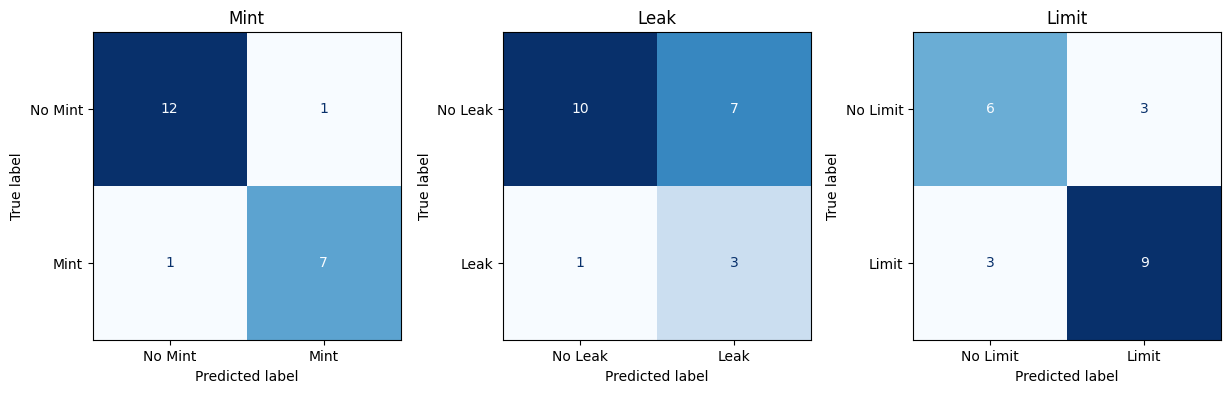

In [ ]:
# Build y_true and y_pred from common addresses
common_addrs = list(A_final_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([A_final_preds[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)

### Option B: Weighted Averaging

In [ ]:
def objective(trial):
    thresholds = np.array([
        trial.suggest_float(f"thresh_{label}", 0.3, 0.9)
        for label in label_cols
    ])

    y_pred = (y_probs > thresholds).astype(int)
    score = f1_score(y_true, y_pred, average='macro')
    return score


In [ ]:
B_final_preds = {}
B_probs = {}

for addr in set.union(*[set(preds.keys()) for preds in available_preds.values()]):
    weighted_sum = np.zeros(len(label_cols))
    total_weight = 0

    for model_name, preds in available_preds.items():
        if addr in preds:
            weighted_sum += B_weights[model_name] * preds[addr]
            total_weight += B_weights[model_name]

    fused_probs = weighted_sum / total_weight
    fused = fused_probs > 0.6
    B_probs[addr] = fused_probs
    B_final_preds[addr] = fused.astype(int)


              precision    recall  f1-score   support

        Mint       0.88      0.88      0.88         8
        Leak       0.75      0.75      0.75         4
       Limit       0.78      0.58      0.67        12

   micro avg       0.81      0.71      0.76        24
   macro avg       0.80      0.74      0.76        24
weighted avg       0.81      0.71      0.75        24
 samples avg       0.56      0.51      0.51        24



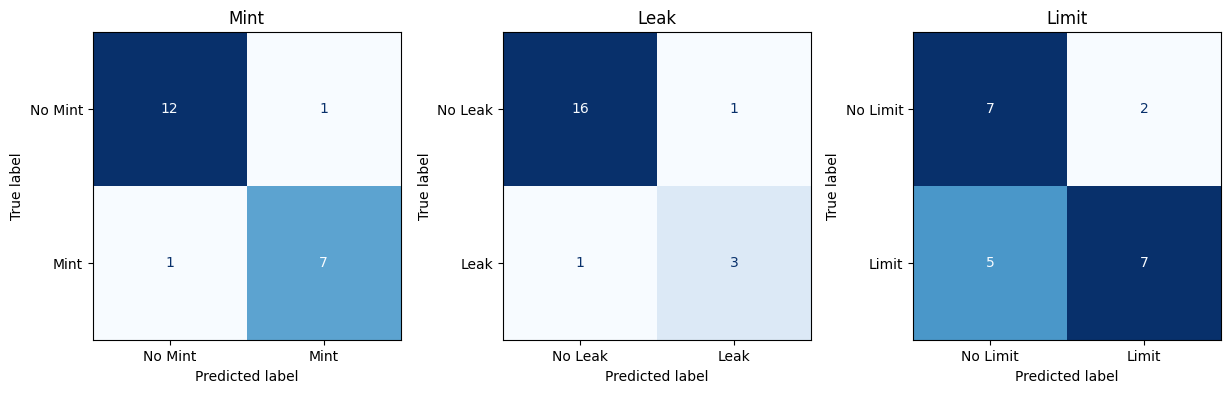

In [ ]:
# Build y_true and y_pred from common addresses
common_addrs = list(B_final_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([B_final_preds[addr] for addr in common_addrs])
y_probs = np.array([B_probs[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_thresholds = np.array([study.best_params[f"thresh_{label}"] for label in label_cols])
print("Best Thresholds:", best_thresholds)

[I 2025-07-30 12:42:14,320] A new study created in memory with name: no-name-67c2ea73-ef60-445a-9f69-3d9fa9f0124d
[I 2025-07-30 12:42:14,327] Trial 0 finished with value: 0.801098901098901 and parameters: {'thresh_Mint': 0.40635398407149037, 'thresh_Leak': 0.731645440818832, 'thresh_Limit': 0.4464209794320998}. Best is trial 0 with value: 0.801098901098901.
[I 2025-07-30 12:42:14,331] Trial 1 finished with value: 0.38888888888888884 and parameters: {'thresh_Mint': 0.8899519855349205, 'thresh_Leak': 0.49709339132995356, 'thresh_Limit': 0.6465916892543234}. Best is trial 0 with value: 0.801098901098901.
[I 2025-07-30 12:42:14,336] Trial 2 finished with value: 0.5411764705882353 and parameters: {'thresh_Mint': 0.4805615751250014, 'thresh_Leak': 0.8679533884533497, 'thresh_Limit': 0.515333194812563}. Best is trial 0 with value: 0.801098901098901.
[I 2025-07-30 12:42:14,340] Trial 3 finished with value: 0.5384615384615384 and parameters: {'thresh_Mint': 0.7012853235429675, 'thresh_Leak': 0.

Best Thresholds: [0.63672877 0.69080702 0.34837026]


              precision    recall  f1-score   support

        Mint       1.00      0.88      0.93         8
        Leak       1.00      0.75      0.86         4
       Limit       0.79      0.92      0.85        12

   micro avg       0.88      0.88      0.88        24
   macro avg       0.93      0.85      0.88        24
weighted avg       0.89      0.88      0.88        24
 samples avg       0.62      0.60      0.59        24



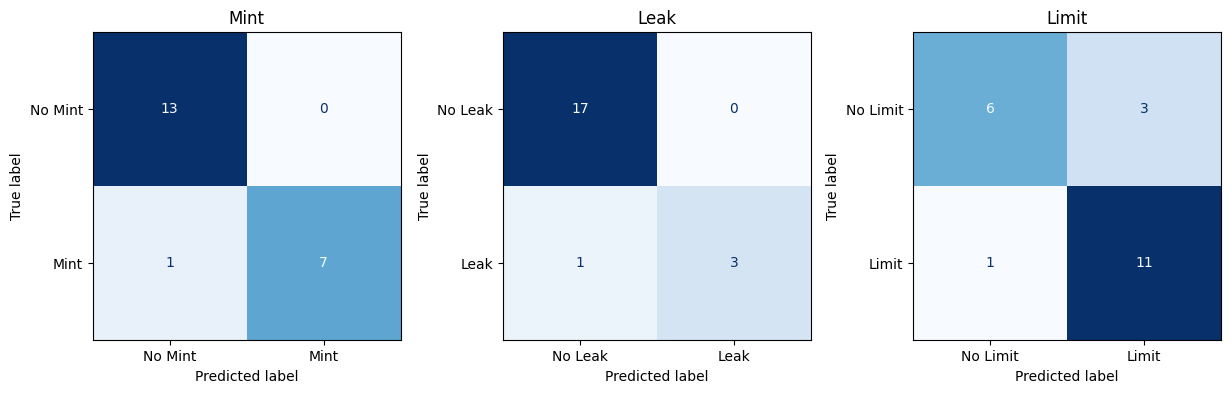

In [ ]:
y_pred = (y_probs > best_thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

### Option C: Per-label weight

#### available_preds + C_weights

In [ ]:
C_final_preds = {}
C_probs = {}

for addr in set.union(*[set(preds.keys()) for preds in available_preds.values()]):
    weighted_sum = np.zeros(len(label_cols))
    total_weight = np.zeros(len(label_cols))  # per-label weights

    for model_name, preds in available_preds.items():
        if addr in preds:
            model_weights = np.array(C_weights[model_name])
            prediction = np.array(preds[addr])

            weighted_sum += model_weights * prediction
            total_weight += model_weights

    fused_probs = (weighted_sum / np.maximum(total_weight, 1e-8))
    fused = fused_probs > 0.6
    C_probs[addr] = fused_probs
    C_final_preds[addr] = fused.astype(int)

              precision    recall  f1-score   support

        Mint       0.78      0.88      0.82         8
        Leak       1.00      0.75      0.86         4
       Limit       0.75      0.75      0.75        12

   micro avg       0.79      0.79      0.79        24
   macro avg       0.84      0.79      0.81        24
weighted avg       0.80      0.79      0.79        24
 samples avg       0.56      0.55      0.53        24



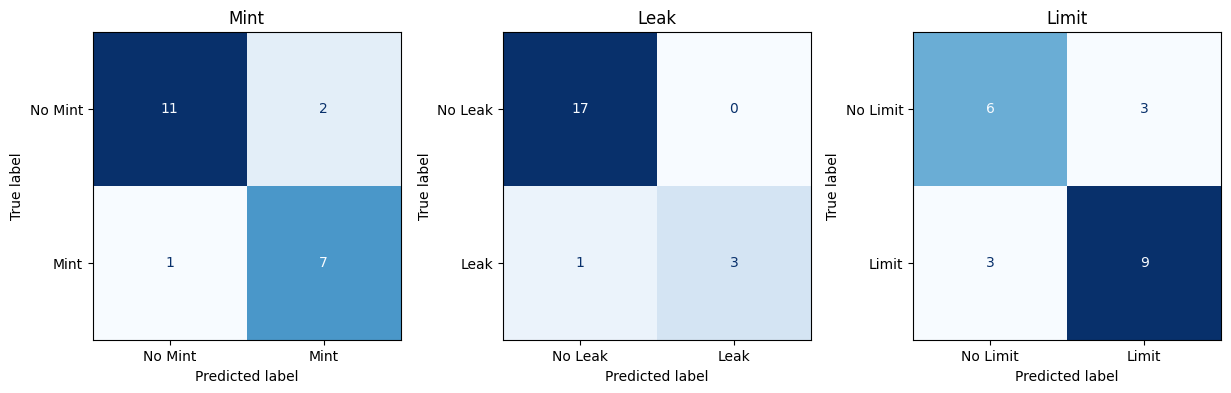

In [ ]:
# Build y_true and y_pred from common addresses
common_addrs = list(C_final_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([C_final_preds[addr] for addr in common_addrs])
y_probs = np.array([C_probs[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)


In [ ]:
C_final_preds

{'0x11cbc781dadaad13fc3a361772c80b1c027820af': array([0, 0, 1]),
 '0x91383a15c391c142b80045d8b4730c1c37ac0378': array([0, 0, 0]),
 '0xdf7ff95aa3d855a6fb21399432166a92fdcf1b1a': array([1, 0, 1]),
 '0x5927b72440d8a8b8c6ca5a8be60e88975f9063fc': array([0, 0, 1]),
 '0xb131f4a55907b10d1f0a50d8ab8fa09ec342cd74': array([1, 0, 0]),
 '0x6609f543d38816116fa5b9a98c918ca947f5455d': array([0, 0, 0]),
 '0x16dfb898cf7029303c2376031392cb9bac450f94': array([0, 0, 0]),
 '0xaaf8c293ed36989d1871d2310b2845450d885673': array([0, 0, 0]),
 '0x186ed770eecea82def7c92dcc077c4ba27acd5bd': array([1, 0, 0]),
 '0x1e4402fa427a7a835fc64ea6d051404ce767a569': array([1, 1, 1]),
 '0xb504035a11e672e12a099f32b1672b9c4a78b22f': array([0, 0, 0]),
 '0x52e4339b4b9ff254738d6e971e83440f60dc029c': array([1, 0, 1]),
 '0x8b2e68075a06959e3e35aa0e451a13e099e41b23': array([1, 0, 1]),
 '0xc71d244f7ad6c869ecbf13cbd9acae31718be4f8': array([0, 0, 1]),
 '0x8d07f605926837ea0f9e1e24dba0fb348cb3e97d': array([0, 1, 1]),
 '0x82902c20c5826984588dc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_thresholds = np.array([study.best_params[f"thresh_{label}"] for label in label_cols])
print("Best Thresholds:", best_thresholds)

[I 2025-07-30 12:42:16,693] A new study created in memory with name: no-name-ce0ee335-2d42-467b-a900-cf4744c6b691
[I 2025-07-30 12:42:16,698] Trial 0 finished with value: 0.5925925925925926 and parameters: {'thresh_Mint': 0.8010152629856653, 'thresh_Leak': 0.8049797826021816, 'thresh_Limit': 0.853369302984343}. Best is trial 0 with value: 0.5925925925925926.
[I 2025-07-30 12:42:16,703] Trial 1 finished with value: 0.6911764705882352 and parameters: {'thresh_Mint': 0.5171346026634078, 'thresh_Leak': 0.32481424348711935, 'thresh_Limit': 0.5841160367962052}. Best is trial 1 with value: 0.6911764705882352.
[I 2025-07-30 12:42:16,709] Trial 2 finished with value: 0.7129629629629629 and parameters: {'thresh_Mint': 0.4531922083275328, 'thresh_Leak': 0.4629847448832295, 'thresh_Limit': 0.5627910590300844}. Best is trial 2 with value: 0.7129629629629629.
[I 2025-07-30 12:42:16,713] Trial 3 finished with value: 0.7602240896358543 and parameters: {'thresh_Mint': 0.5779449764390403, 'thresh_Leak':

Best Thresholds: [0.46409744 0.64044065 0.36106914]


              precision    recall  f1-score   support

        Mint       0.80      1.00      0.89         8
        Leak       1.00      0.75      0.86         4
       Limit       0.80      1.00      0.89        12

   micro avg       0.82      0.96      0.88        24
   macro avg       0.87      0.92      0.88        24
weighted avg       0.83      0.96      0.88        24
 samples avg       0.60      0.64      0.61        24



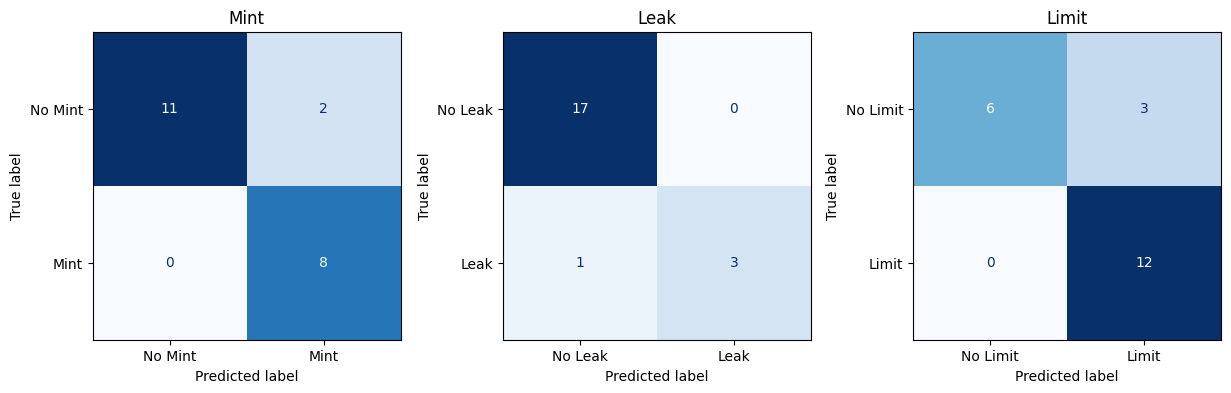

In [ ]:
y_pred = (y_probs > best_thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

#### available_preds + C_weights_normalized

In [ ]:
C_final_preds = {}
C_probs = {}

for addr in set.union(*[set(preds.keys()) for preds in available_preds.values()]):
    weighted_sum = np.zeros(len(label_cols))
    total_weight = np.zeros(len(label_cols))  # per-label weights

    for model_name, preds in available_preds.items():
        if addr in preds:
            model_weights = np.array(C_weights_normalized[model_name])
            prediction = np.array(preds[addr])

            weighted_sum += model_weights * prediction
            total_weight += model_weights

    fused_probs = (weighted_sum / np.maximum(total_weight, 1e-8))
    fused = fused_probs > 0.6
    C_probs[addr] = fused_probs
    C_final_preds[addr] = fused.astype(int)

              precision    recall  f1-score   support

        Mint       0.88      0.88      0.88         8
        Leak       1.00      0.75      0.86         4
       Limit       0.75      0.75      0.75        12

   micro avg       0.83      0.79      0.81        24
   macro avg       0.88      0.79      0.83        24
weighted avg       0.83      0.79      0.81        24
 samples avg       0.56      0.55      0.53        24



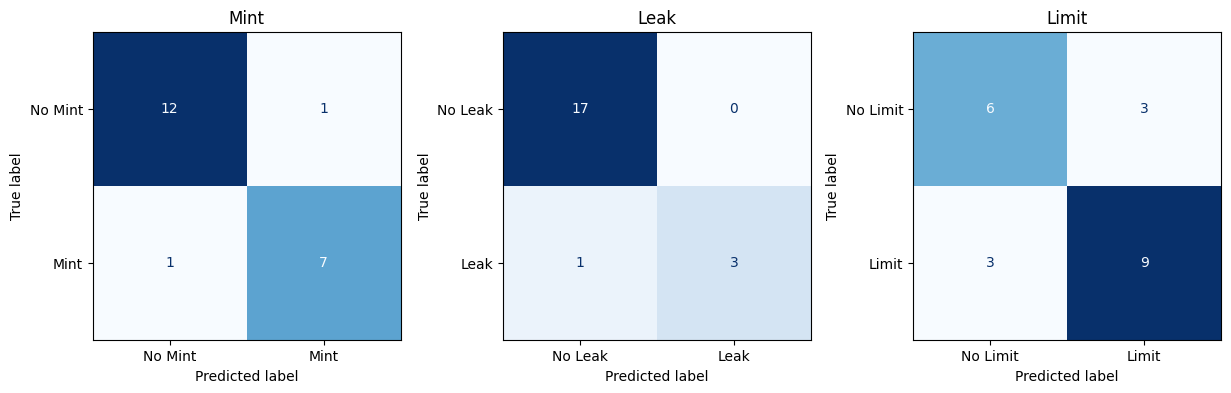

In [ ]:
# Build y_true and y_pred from common addresses
common_addrs = list(C_final_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([C_final_preds[addr] for addr in common_addrs])
y_probs = np.array([C_probs[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)


In [ ]:
C_final_preds

{'0x11cbc781dadaad13fc3a361772c80b1c027820af': array([0, 0, 1]),
 '0x91383a15c391c142b80045d8b4730c1c37ac0378': array([0, 0, 0]),
 '0xdf7ff95aa3d855a6fb21399432166a92fdcf1b1a': array([1, 0, 1]),
 '0x5927b72440d8a8b8c6ca5a8be60e88975f9063fc': array([0, 0, 1]),
 '0xb131f4a55907b10d1f0a50d8ab8fa09ec342cd74': array([0, 0, 0]),
 '0x6609f543d38816116fa5b9a98c918ca947f5455d': array([0, 0, 0]),
 '0x16dfb898cf7029303c2376031392cb9bac450f94': array([0, 0, 0]),
 '0xaaf8c293ed36989d1871d2310b2845450d885673': array([0, 0, 0]),
 '0x186ed770eecea82def7c92dcc077c4ba27acd5bd': array([1, 0, 0]),
 '0x1e4402fa427a7a835fc64ea6d051404ce767a569': array([1, 1, 1]),
 '0xb504035a11e672e12a099f32b1672b9c4a78b22f': array([0, 0, 0]),
 '0x52e4339b4b9ff254738d6e971e83440f60dc029c': array([1, 0, 1]),
 '0x8b2e68075a06959e3e35aa0e451a13e099e41b23': array([1, 0, 1]),
 '0xc71d244f7ad6c869ecbf13cbd9acae31718be4f8': array([0, 0, 1]),
 '0x8d07f605926837ea0f9e1e24dba0fb348cb3e97d': array([0, 1, 1]),
 '0x82902c20c5826984588dc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_thresholds = np.array([study.best_params[f"thresh_{label}"] for label in label_cols])
print("Best Thresholds:", best_thresholds)

[I 2025-07-30 12:42:19,498] A new study created in memory with name: no-name-a0b57e9a-d02e-4665-a7fc-d1854391764c
[I 2025-07-30 12:42:19,507] Trial 0 finished with value: 0.673076923076923 and parameters: {'thresh_Mint': 0.7226936510314113, 'thresh_Leak': 0.3482564696252345, 'thresh_Limit': 0.6232261630534253}. Best is trial 0 with value: 0.673076923076923.
[I 2025-07-30 12:42:19,515] Trial 1 finished with value: 0.565079365079365 and parameters: {'thresh_Mint': 0.8085483691511295, 'thresh_Leak': 0.5621522838983285, 'thresh_Limit': 0.7397437556575808}. Best is trial 0 with value: 0.673076923076923.
[I 2025-07-30 12:42:19,520] Trial 2 finished with value: 0.707936507936508 and parameters: {'thresh_Mint': 0.6582551707068773, 'thresh_Leak': 0.7528211201055381, 'thresh_Limit': 0.7372492919121314}. Best is trial 2 with value: 0.707936507936508.
[I 2025-07-30 12:42:19,525] Trial 3 finished with value: 0.6317460317460317 and parameters: {'thresh_Mint': 0.8741898074078707, 'thresh_Leak': 0.478

Best Thresholds: [0.58431608 0.67815758 0.34832039]


              precision    recall  f1-score   support

        Mint       0.88      0.88      0.88         8
        Leak       1.00      0.75      0.86         4
       Limit       0.80      1.00      0.89        12

   micro avg       0.85      0.92      0.88        24
   macro avg       0.89      0.88      0.87        24
weighted avg       0.86      0.92      0.88        24
 samples avg       0.60      0.62      0.59        24



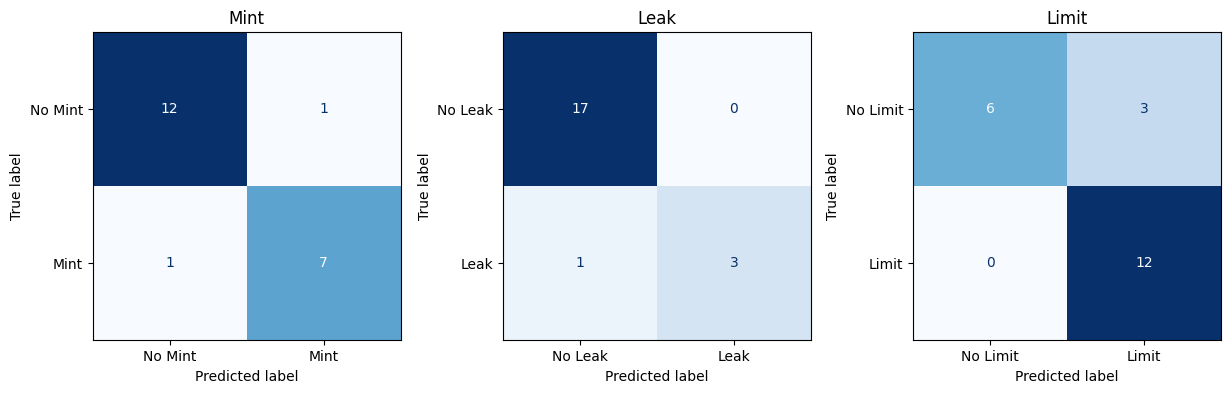

In [ ]:
y_pred = (y_probs > best_thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

#### available_prob + C_weights

In [ ]:
C_final_preds = {}
C_probs = {}

for addr in set.union(*[set(prob.keys()) for prob in available_prob.values()]):
    weighted_sum = np.zeros(len(label_cols))
    total_weight = np.zeros(len(label_cols))  # per-label weights

    for model_name, probs in available_prob.items():
        if addr in probs:
            model_weights = np.array(C_weights[model_name])
            prediction = np.array(probs[addr])

            weighted_sum += model_weights * prediction
            total_weight += model_weights

    fused_probs = (weighted_sum / np.maximum(total_weight, 1e-8))
    fused = fused_probs > 0.6
    C_probs[addr] = fused_probs
    C_final_preds[addr] = fused.astype(int)

              precision    recall  f1-score   support

        Mint       1.00      0.25      0.40         8
        Leak       0.00      0.00      0.00         4
       Limit       0.00      0.00      0.00        12

   micro avg       1.00      0.08      0.15        24
   macro avg       0.33      0.08      0.13        24
weighted avg       0.33      0.08      0.13        24
 samples avg       0.10      0.05      0.06        24



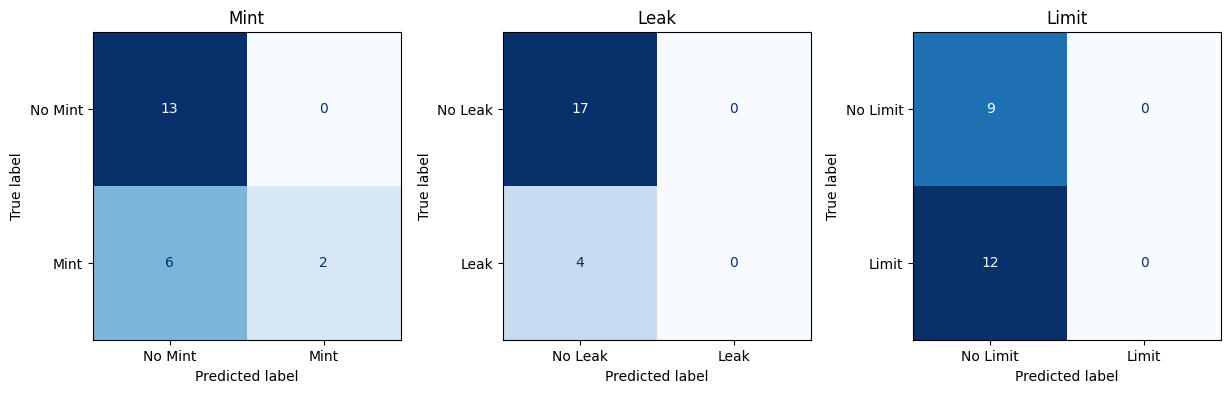

In [ ]:
# Build y_true and y_pred from common addresses
common_addrs = list(C_final_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([C_final_preds[addr] for addr in common_addrs])
y_probs = np.array([C_probs[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)


In [ ]:
C_final_preds

{'0x11cbc781dadaad13fc3a361772c80b1c027820af': array([0, 0, 0]),
 '0x91383a15c391c142b80045d8b4730c1c37ac0378': array([0, 0, 0]),
 '0xdf7ff95aa3d855a6fb21399432166a92fdcf1b1a': array([0, 0, 0]),
 '0x5927b72440d8a8b8c6ca5a8be60e88975f9063fc': array([0, 0, 0]),
 '0xb131f4a55907b10d1f0a50d8ab8fa09ec342cd74': array([0, 0, 0]),
 '0x6609f543d38816116fa5b9a98c918ca947f5455d': array([0, 0, 0]),
 '0x16dfb898cf7029303c2376031392cb9bac450f94': array([0, 0, 0]),
 '0xaaf8c293ed36989d1871d2310b2845450d885673': array([0, 0, 0]),
 '0x186ed770eecea82def7c92dcc077c4ba27acd5bd': array([1, 0, 0]),
 '0x1e4402fa427a7a835fc64ea6d051404ce767a569': array([0, 0, 0]),
 '0xb504035a11e672e12a099f32b1672b9c4a78b22f': array([0, 0, 0]),
 '0x52e4339b4b9ff254738d6e971e83440f60dc029c': array([0, 0, 0]),
 '0x8b2e68075a06959e3e35aa0e451a13e099e41b23': array([0, 0, 0]),
 '0xc71d244f7ad6c869ecbf13cbd9acae31718be4f8': array([0, 0, 0]),
 '0x8d07f605926837ea0f9e1e24dba0fb348cb3e97d': array([0, 0, 0]),
 '0x82902c20c5826984588dc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_thresholds = np.array([study.best_params[f"thresh_{label}"] for label in label_cols])
print("Best Thresholds:", best_thresholds)

[I 2025-07-30 12:42:22,367] A new study created in memory with name: no-name-b9d6d50e-bf23-4003-bfc9-6a75c65fe6a5
[I 2025-07-30 12:42:22,374] Trial 0 finished with value: 0.2222222222222222 and parameters: {'thresh_Mint': 0.7327354987420286, 'thresh_Leak': 0.3899409850491145, 'thresh_Limit': 0.8061799867945958}. Best is trial 0 with value: 0.2222222222222222.
[I 2025-07-30 12:42:22,380] Trial 1 finished with value: 0.37606837606837606 and parameters: {'thresh_Mint': 0.5595393396702075, 'thresh_Leak': 0.6928454350094544, 'thresh_Limit': 0.3827161239036695}. Best is trial 1 with value: 0.37606837606837606.
[I 2025-07-30 12:42:22,386] Trial 2 finished with value: 0.19999999999999998 and parameters: {'thresh_Mint': 0.8946983907196924, 'thresh_Leak': 0.31461045264082416, 'thresh_Limit': 0.5562815257912508}. Best is trial 1 with value: 0.37606837606837606.
[I 2025-07-30 12:42:22,392] Trial 3 finished with value: 0.3434343434343434 and parameters: {'thresh_Mint': 0.5672746842149751, 'thresh_L

Best Thresholds: [0.48263114 0.34567169 0.30411781]


              precision    recall  f1-score   support

        Mint       0.64      0.88      0.74         8
        Leak       0.75      0.75      0.75         4
       Limit       0.80      0.67      0.73        12

   micro avg       0.72      0.75      0.73        24
   macro avg       0.73      0.76      0.74        24
weighted avg       0.74      0.75      0.73        24
 samples avg       0.56      0.52      0.51        24



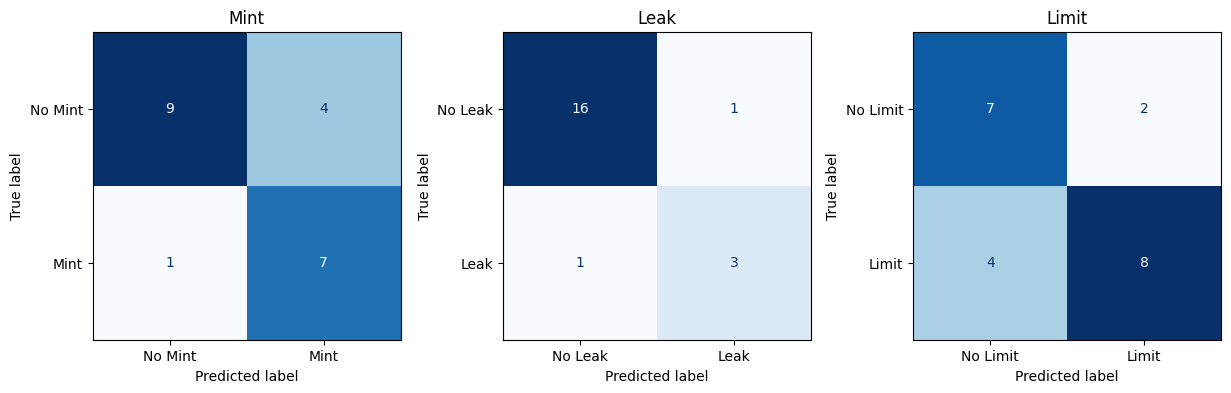

In [ ]:
y_pred = (y_probs > best_thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

#### available_prob + C_weights_normalized

In [ ]:
C_final_preds = {}
C_probs = {}

for addr in set.union(*[set(prob.keys()) for prob in available_prob.values()]):
    weighted_sum = np.zeros(len(label_cols))
    total_weight = np.zeros(len(label_cols))  # per-label weights

    for model_name, probs in available_prob.items():
        if addr in probs:
            model_weights = np.array(C_weights_normalized[model_name])
            prediction = np.array(probs[addr])

            weighted_sum += model_weights * prediction
            total_weight += model_weights

    fused_probs = (weighted_sum / np.maximum(total_weight, 1e-8))
    fused = fused_probs > 0.6
    C_probs[addr] = fused_probs
    C_final_preds[addr] = fused.astype(int)

              precision    recall  f1-score   support

        Mint       1.00      0.25      0.40         8
        Leak       0.00      0.00      0.00         4
       Limit       0.00      0.00      0.00        12

   micro avg       1.00      0.08      0.15        24
   macro avg       0.33      0.08      0.13        24
weighted avg       0.33      0.08      0.13        24
 samples avg       0.10      0.05      0.06        24



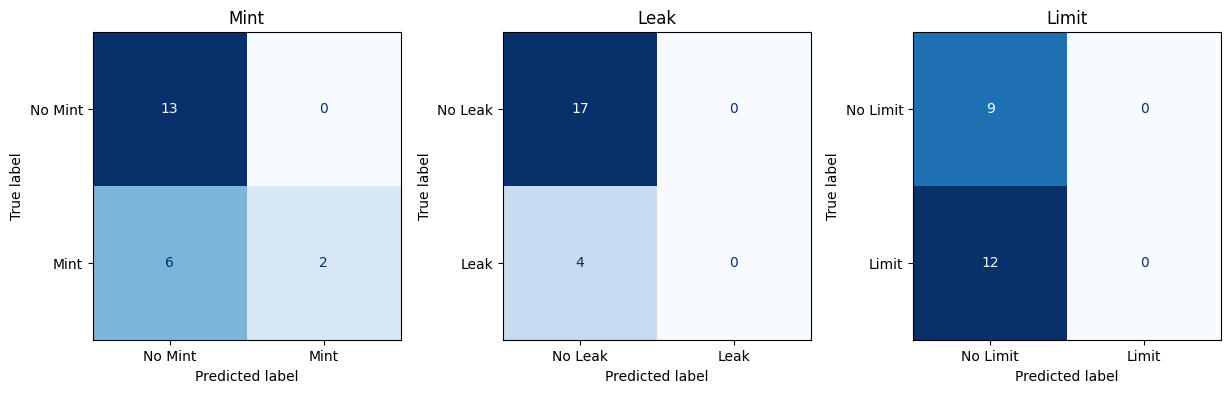

In [ ]:
# Build y_true and y_pred from common addresses
common_addrs = list(C_final_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([C_final_preds[addr] for addr in common_addrs])
y_probs = np.array([C_probs[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)


In [ ]:
C_final_preds

{'0x11cbc781dadaad13fc3a361772c80b1c027820af': array([0, 0, 0]),
 '0x91383a15c391c142b80045d8b4730c1c37ac0378': array([0, 0, 0]),
 '0xdf7ff95aa3d855a6fb21399432166a92fdcf1b1a': array([0, 0, 0]),
 '0x5927b72440d8a8b8c6ca5a8be60e88975f9063fc': array([0, 0, 0]),
 '0xb131f4a55907b10d1f0a50d8ab8fa09ec342cd74': array([0, 0, 0]),
 '0x6609f543d38816116fa5b9a98c918ca947f5455d': array([0, 0, 0]),
 '0x16dfb898cf7029303c2376031392cb9bac450f94': array([0, 0, 0]),
 '0xaaf8c293ed36989d1871d2310b2845450d885673': array([0, 0, 0]),
 '0x186ed770eecea82def7c92dcc077c4ba27acd5bd': array([1, 0, 0]),
 '0x1e4402fa427a7a835fc64ea6d051404ce767a569': array([0, 0, 0]),
 '0xb504035a11e672e12a099f32b1672b9c4a78b22f': array([0, 0, 0]),
 '0x52e4339b4b9ff254738d6e971e83440f60dc029c': array([0, 0, 0]),
 '0x8b2e68075a06959e3e35aa0e451a13e099e41b23': array([0, 0, 0]),
 '0xc71d244f7ad6c869ecbf13cbd9acae31718be4f8': array([0, 0, 0]),
 '0x8d07f605926837ea0f9e1e24dba0fb348cb3e97d': array([0, 0, 0]),
 '0x82902c20c5826984588dc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_thresholds = np.array([study.best_params[f"thresh_{label}"] for label in label_cols])
print("Best Thresholds:", best_thresholds)

[I 2025-07-30 12:42:24,681] A new study created in memory with name: no-name-90e1cb5c-e434-4a39-a50f-bfbf7b10423b
[I 2025-07-30 12:42:24,692] Trial 0 finished with value: 0.3434343434343434 and parameters: {'thresh_Mint': 0.5735361698125117, 'thresh_Leak': 0.6366484134505768, 'thresh_Limit': 0.33244804531098293}. Best is trial 0 with value: 0.3434343434343434.
[I 2025-07-30 12:42:24,697] Trial 1 finished with value: 0.19999999999999998 and parameters: {'thresh_Mint': 0.8109967210473528, 'thresh_Leak': 0.317117456921402, 'thresh_Limit': 0.6004594316721383}. Best is trial 0 with value: 0.3434343434343434.
[I 2025-07-30 12:42:24,703] Trial 2 finished with value: 0.0 and parameters: {'thresh_Mint': 0.8123840300990461, 'thresh_Leak': 0.6289388160843202, 'thresh_Limit': 0.5796189978625192}. Best is trial 0 with value: 0.3434343434343434.
[I 2025-07-30 12:42:24,709] Trial 3 finished with value: 0.1839080459770115 and parameters: {'thresh_Mint': 0.31333816875519976, 'thresh_Leak': 0.4714381020

Best Thresholds: [0.49309913 0.37184731 0.40621301]


              precision    recall  f1-score   support

        Mint       0.64      0.88      0.74         8
        Leak       1.00      0.75      0.86         4
       Limit       0.78      0.58      0.67        12

   micro avg       0.74      0.71      0.72        24
   macro avg       0.80      0.74      0.75        24
weighted avg       0.77      0.71      0.72        24
 samples avg       0.56      0.51      0.50        24



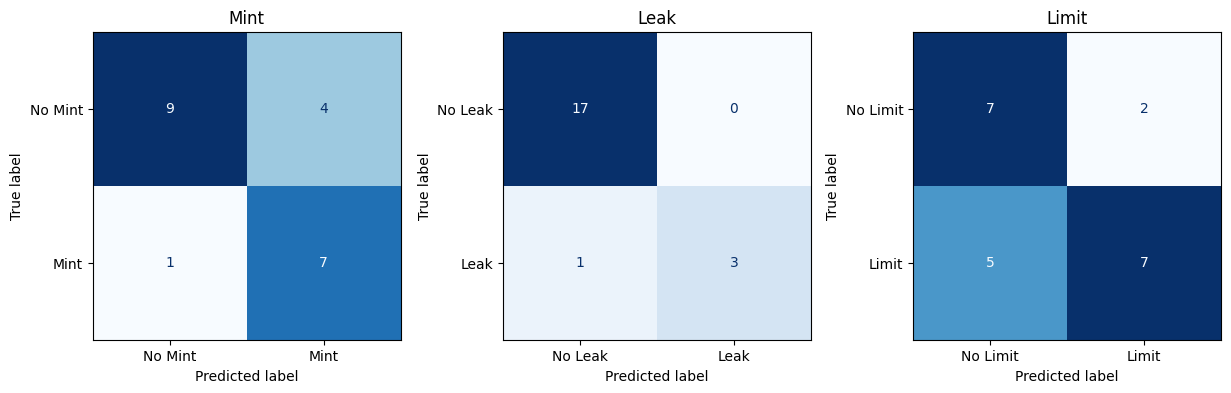

In [ ]:
y_pred = (y_probs > best_thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

### Option D: Stacking

In [ ]:
meta_features = []
meta_targets = []
meta_addresses = []

for addr in set.intersection(*[set(preds.keys()) for preds in available_prob.values()]):  # Only common addresses
    feature_row = []
    for model_name in available_preds.keys():
        pred = available_preds[model_name][addr]  # prediction vector for addr
        feature_row.extend(pred.tolist())         # flatten and concatenate

    meta_features.append(feature_row)
    meta_targets.append(y.loc[addr].values.tolist())
    meta_addresses.append(addr)

In [ ]:
from utils.comparing import report_for_multiple_model

In [ ]:
X_meta = np.array(meta_features)
y_meta = np.array(meta_targets)
X_meta_df = pd.DataFrame(X_meta)
y_meta_df = pd.DataFrame(y_meta, columns=label_cols)

In [ ]:
available_prob

{'txn': {'0x186ed770eecea82def7c92dcc077c4ba27acd5bd': array([0.54281746, 0.00515588, 0.1911859 ]),
  '0x93023f1d3525e273f291b6f76d2f5027a39bf302': array([0.45698893, 0.61342437, 0.57703364]),
  '0x16dfb898cf7029303c2376031392cb9bac450f94': array([0.19617979, 0.19529656, 0.10495865]),
  '0x10f6f2b97f3ab29583d9d38babf2994df7220c21': array([0.35235043, 0.00327245, 0.35726732]),
  '0xb504035a11e672e12a099f32b1672b9c4a78b22f': array([0.34869048, 0.00555556, 0.34942766]),
  '0x52e4339b4b9ff254738d6e971e83440f60dc029c': array([0.45698893, 0.61342437, 0.57703364]),
  '0x5927b72440d8a8b8c6ca5a8be60e88975f9063fc': array([0.45698893, 0.61342437, 0.57703364]),
  '0x8d07f605926837ea0f9e1e24dba0fb348cb3e97d': array([0.45698893, 0.61342437, 0.57703364]),
  '0xaaf8c293ed36989d1871d2310b2845450d885673': array([0.08492063, 0.310844  , 0.03539562]),
  '0x1e4402fa427a7a835fc64ea6d051404ce767a569': array([0.45698893, 0.61342437, 0.57703364]),
  '0x9db8a10c7fe60d84397860b3af2e686d4f90c2b7': array([0.456988

In [ ]:
report_df, _ = report_for_multiple_model(X_meta_df, y_meta_df)
report_df

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 7
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 8, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125000 -> initscore=-1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because ther

,micro avg f1,macro avg f1,Mint f1,Leak f1,Limit f1
MultiOutput(LogisticRegression),0.4,0.222222,0.666667,0.0,0.0
MultiOutput(DecisionTree),0.0,0.000000,0.000000,0.0,0.0
MultiOutput(RandomForest),0.0,0.000000,0.000000,0.0,0.0
MultiOutput(AdaBoost),0.0,0.000000,0.000000,0.0,0.0
MultiOutput(ExtraTrees),0.4,0.222222,0.666667,0.0,0.0
MultiOutput(XGBoost),0.0,0.000000,0.000000,0.0,0.0
MultiOutput(LightGBM),0.0,0.000000,0.000000,0.0,0.0
MultiOutput(SVC),0.0,0.000000,0.000000,0.0,0.0
MultiOutput(GaussianNB),0.0,0.000000,0.000000,0.0,0.0
MultiOutput(KNN),0.0,0.000000,0.000000,0.0,0.0


### Option E: Dynamic Fusion

In [ ]:
C_dynamic_preds = {}

for addr in set.union(*[set(m.keys()) for m in available_prob.values()]):  # all unique addresses
    weighted_sum = np.zeros(len(label_cols))
    total_weight = np.zeros(len(label_cols))

    for model_name in available_prob:
        if addr in available_prob[model_name]:
            prob = np.array(available_prob[model_name][addr])  # e.g., shape (3,)
            weight = np.array(C_weights[model_name])           # per-label F1

            weighted_sum += prob * weight
            total_weight += weight

    final_prob = weighted_sum / np.maximum(total_weight, 1e-8)
    pred = (final_prob > 0.6).astype(int)
    C_dynamic_preds[addr] = pred


              precision    recall  f1-score   support

        Mint       1.00      0.25      0.40         8
        Leak       0.00      0.00      0.00         4
       Limit       0.00      0.00      0.00        12

   micro avg       1.00      0.08      0.15        24
   macro avg       0.33      0.08      0.13        24
weighted avg       0.33      0.08      0.13        24
 samples avg       0.10      0.05      0.06        24



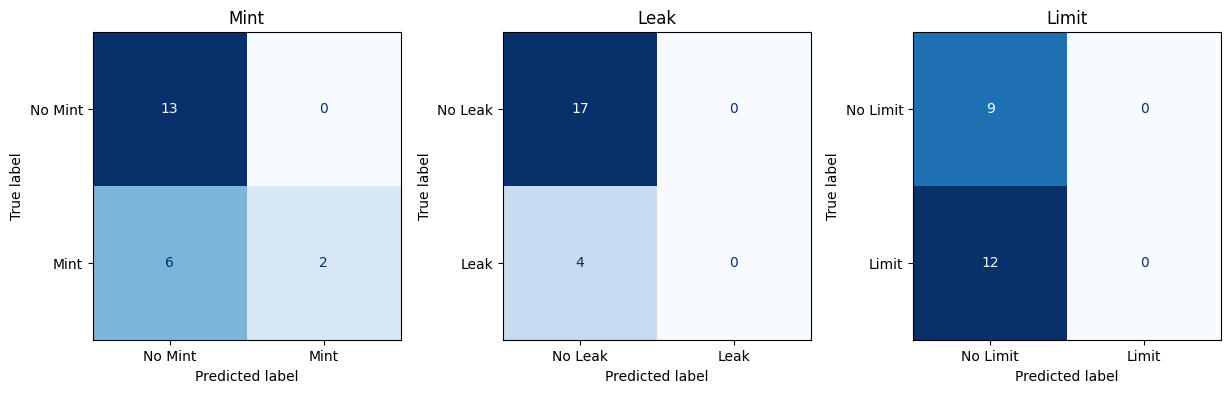

In [ ]:
common_addrs = list(C_dynamic_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([C_dynamic_preds[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)


### Option F: Bayesian Fusion

In [ ]:
C_bayes_preds = {}
C_bayes_probs = {}

for addr in set.union(*[set(prob.keys()) for prob in available_prob.values()]):
    prob_list = []

    for model_name in available_prob:
        if addr in available_prob[model_name]:
            prob_list.append(np.array(available_prob[model_name][addr]))

    if len(prob_list) == 0:
        continue

    probs = np.stack(prob_list)  # shape: (n_models, n_labels)

    # Product of experts
    product = np.prod(probs + 1e-8, axis=0)
    complement = np.prod(1 - probs + 1e-8, axis=0)
    fused_probs = product / (product + complement)

    fused = fused_probs > 0.5  # you can tune this threshold

    C_bayes_probs[addr] = fused_probs
    C_bayes_preds[addr] = fused.astype(int)


              precision    recall  f1-score   support

        Mint       0.50      0.62      0.56         8
        Leak       0.00      0.00      0.00         4
       Limit       0.00      0.00      0.00        12

   micro avg       0.50      0.21      0.29        24
   macro avg       0.17      0.21      0.19        24
weighted avg       0.17      0.21      0.19        24
 samples avg       0.24      0.17      0.19        24



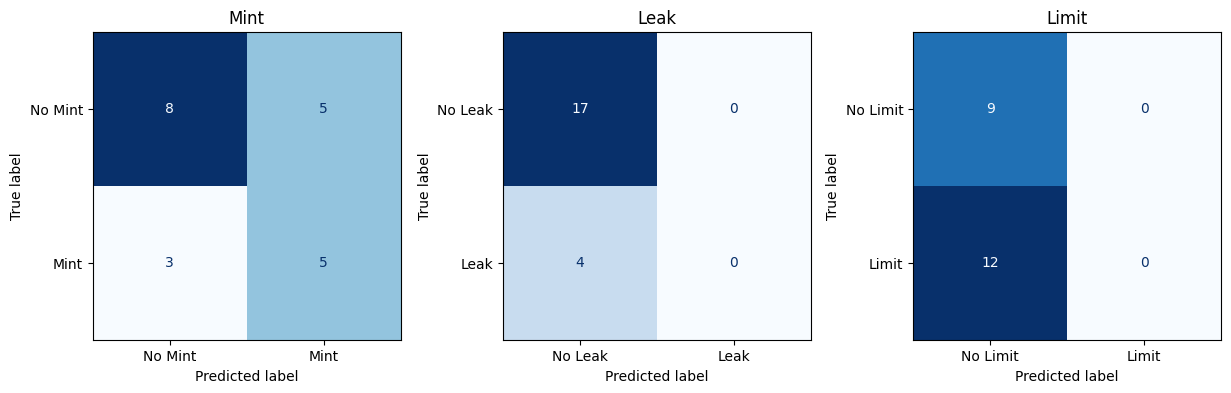

In [ ]:
# Build y_true and y_pred from common addresses
common_addrs = list(C_bayes_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([C_bayes_preds[addr] for addr in common_addrs])
y_probs = np.array([C_bayes_probs[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)


In [ ]:
C_final_preds

{'0x11cbc781dadaad13fc3a361772c80b1c027820af': array([0, 0, 0]),
 '0x91383a15c391c142b80045d8b4730c1c37ac0378': array([0, 0, 0]),
 '0xdf7ff95aa3d855a6fb21399432166a92fdcf1b1a': array([0, 0, 0]),
 '0x5927b72440d8a8b8c6ca5a8be60e88975f9063fc': array([0, 0, 0]),
 '0xb131f4a55907b10d1f0a50d8ab8fa09ec342cd74': array([0, 0, 0]),
 '0x6609f543d38816116fa5b9a98c918ca947f5455d': array([0, 0, 0]),
 '0x16dfb898cf7029303c2376031392cb9bac450f94': array([0, 0, 0]),
 '0xaaf8c293ed36989d1871d2310b2845450d885673': array([0, 0, 0]),
 '0x186ed770eecea82def7c92dcc077c4ba27acd5bd': array([1, 0, 0]),
 '0x1e4402fa427a7a835fc64ea6d051404ce767a569': array([0, 0, 0]),
 '0xb504035a11e672e12a099f32b1672b9c4a78b22f': array([0, 0, 0]),
 '0x52e4339b4b9ff254738d6e971e83440f60dc029c': array([0, 0, 0]),
 '0x8b2e68075a06959e3e35aa0e451a13e099e41b23': array([0, 0, 0]),
 '0xc71d244f7ad6c869ecbf13cbd9acae31718be4f8': array([0, 0, 0]),
 '0x8d07f605926837ea0f9e1e24dba0fb348cb3e97d': array([0, 0, 0]),
 '0x82902c20c5826984588dc

### Oprion G: Confidence-Based Fusion

In [ ]:
C_confidence_preds = {}
C_confidence_probs = {}

for addr in set.union(*[set(prob.keys()) for prob in available_prob.values()]):
    weighted_sum = np.zeros(len(label_cols))
    total_weight = np.zeros(len(label_cols))

    for model_name, prob_dict in available_prob.items():
        if addr in prob_dict:
            prob = np.array(prob_dict[addr])                   # shape: (n_labels,)
            confidence = np.abs(prob - 0.5)                    # Confidence per label

            weighted_sum += prob * confidence
            total_weight += confidence

    fused_probs = weighted_sum / np.maximum(total_weight, 1e-8)  # Avoid division by zero
    fused = fused_probs > 0.3  # Threshold can be tuned

    C_confidence_probs[addr] = fused_probs
    C_confidence_preds[addr] = fused.astype(int)


              precision    recall  f1-score   support

        Mint       0.39      0.88      0.54         8
        Leak       0.00      0.00      0.00         4
       Limit       0.80      0.33      0.47        12

   micro avg       0.48      0.46      0.47        24
   macro avg       0.40      0.40      0.34        24
weighted avg       0.53      0.46      0.41        24
 samples avg       0.43      0.35      0.36        24



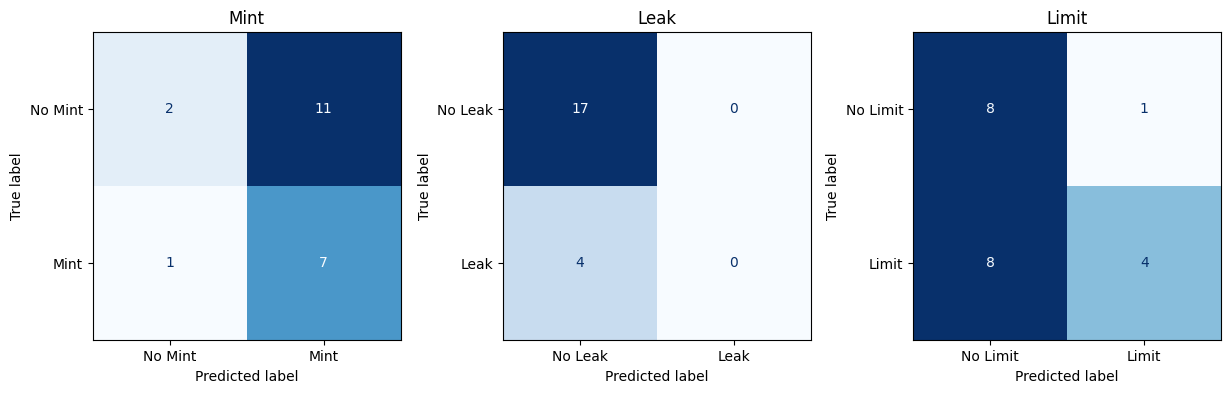

In [ ]:
# Build y_true and y_pred from common addresses
common_addrs = list(C_confidence_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([C_confidence_preds[addr] for addr in common_addrs])
y_probs = np.array([C_confidence_probs[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_thresholds = np.array([study.best_params[f"thresh_{label}"] for label in label_cols])
print("Best Thresholds:", best_thresholds)

[I 2025-07-30 12:42:31,655] A new study created in memory with name: no-name-62ae3f14-6551-4478-b9e3-dc48a90c468c
[I 2025-07-30 12:42:31,662] Trial 0 finished with value: 0.18666666666666668 and parameters: {'thresh_Mint': 0.3279358312445083, 'thresh_Leak': 0.4392829181973733, 'thresh_Limit': 0.7530522344962449}. Best is trial 0 with value: 0.18666666666666668.
[I 2025-07-30 12:42:31,668] Trial 1 finished with value: 0.19047619047619047 and parameters: {'thresh_Mint': 0.6211750569507051, 'thresh_Leak': 0.5694475997626998, 'thresh_Limit': 0.6163965442575319}. Best is trial 1 with value: 0.19047619047619047.
[I 2025-07-30 12:42:31,673] Trial 2 finished with value: 0.36111111111111116 and parameters: {'thresh_Mint': 0.35969256557623674, 'thresh_Leak': 0.30439701623035614, 'thresh_Limit': 0.4094654805858249}. Best is trial 2 with value: 0.36111111111111116.
[I 2025-07-30 12:42:31,678] Trial 3 finished with value: 0.35555555555555557 and parameters: {'thresh_Mint': 0.47778351602816505, 'thr

Best Thresholds: [0.50067183 0.38213967 0.38793251]


              precision    recall  f1-score   support

        Mint       0.64      0.88      0.74         8
        Leak       0.00      0.00      0.00         4
       Limit       1.00      0.33      0.50        12

   micro avg       0.73      0.46      0.56        24
   macro avg       0.55      0.40      0.41        24
weighted avg       0.71      0.46      0.50        24
 samples avg       0.48      0.35      0.39        24



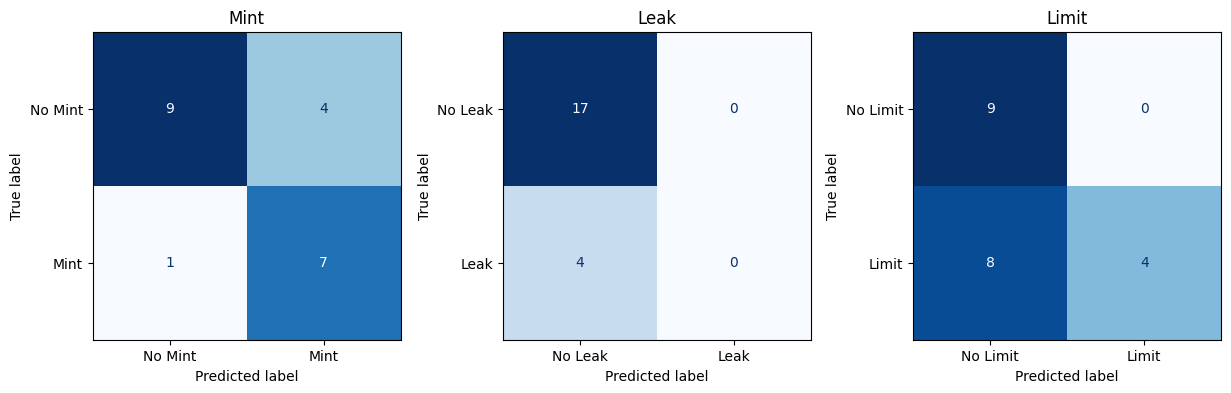

In [ ]:
y_pred = (y_probs > best_thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)